# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

from tqdm import tqdm

from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module, ZINB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mirna
from base.dgd.latent import RepresentationLayer

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=False, filter_group_size=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
    
    return df

tcga_mirna = data_filtering(tcga_mirna_raw)

## Data Loader

In [7]:
# shuffle the data
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# Count the number of zeros in the entire DataFrame
(tcga_mirna == 0).sum().sum()

13138816

In [9]:
# make data split for train, validation, and test sets
train_ratio= 0.70
batch_size = 256
scaling_type = "sum"

train_mirna, val_mirna = train_test_split(tcga_mirna, train_size=train_ratio, stratify=tcga_mirna['cancer_type'], random_state=seed) 
val_mirna, test_mirna = train_test_split(val_mirna, test_size=0.50, stratify=val_mirna['cancer_type'], random_state=seed)

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mirna, scaling_type=scaling_type)
validation_dataset = GeneExpressionDataset(val_mirna, scaling_type=scaling_type)
test_dataset = GeneExpressionDataset(test_mirna, scaling_type=scaling_type)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [10]:
# make data split for train and validation sets
mirna_out_dim = tcga_mirna.shape[1]-4

In [11]:
print(train_mirna.shape)
print(val_mirna.shape)
print(test_mirna.shape)
print(mirna_out_dim)

(7473, 2028)
(1601, 2028)
(1602, 2028)
2024


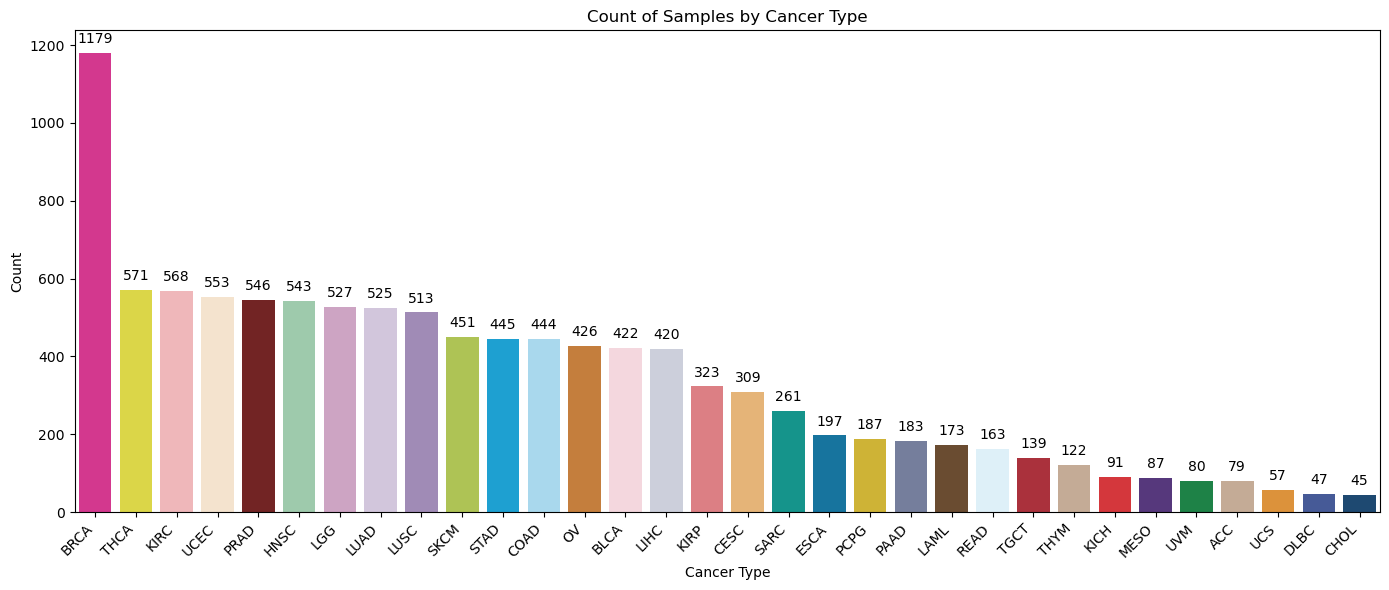

In [12]:
color_mapping = dict(zip(tcga_mirna['cancer_type'], tcga_mirna['color']))

primary_site_counts = tcga_mirna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [13]:
# This one is used for n GMM mixture component 
# n_tissues = len(np.unique(train_dataset.label))
n_tissues = 22

# Hyperparameters for Decoder
latent_dim = 22 # For the representation layer 
hidden_dims = [64, 128, 256] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "leaky_relu" # ["relu", "leaky_relu"]
r_init = 3
pi_init = 0.75

# Hyperparameters for GMM
gmm_mean = 2.5 # usually between 2 and 10
sd_mean = 0.4 # default 0.2

In [14]:
# Output Module Setup
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, pi_init=pi_init, scaling_type=scaling_type)
# output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type=scaling_type)
output_mirna_layer.n_features = mirna_out_dim

# Set up the decoder
decoder = Decoder(latent_dim, hidden_dims, output_module=output_mirna_layer).to(device)

# Setup GMM init
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [15]:
# Init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

In [16]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=22, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): ReLU()
    )
    (out_module): ZINB_Module(
      (fc): Sequential(
        (0): Linear(in_features=256, out_features=2024, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

## Training loop

In [17]:
sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
sample_index

[1371, 1304, 34, 359]

In [18]:
# Training hyperparameters
learning_rates = {'dec':1e-3,'rep':1e-3,'gmm':1e-2}
weight_decay = 1e-4
betas = (0.5, 0.7)

nepochs = 601
pr = 5 # how often to print epoch
plot = 100 # how often to print plot
subset = 1287
sample_index = [1371, 1304, 34, 359, 
                765, 999, 70, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 1050, 56,
                1, 2, 3, 4]

  0%|                                                                             | 0/601 [00:00<?, ?it/s]

0 train_loss: 10.192225857146394 train_recon: 7.607414756364017 train_gmm: 2.584811100782376 train_mse: 411139.40625 train_mae: 547.6969604492188 train_r2: -904335.125 train_spearman: 0.197125643491745 train_pearson: 0.22394295036792755 train_msle: 35.825687408447266
0 test_loss: 7.362312809990298 test_recon: 5.459863257863786 test_gmm: 1.902449552126512 test_mse: 418628.6875 test_mae: 549.13720703125 test_r2: -963394.125 test_spearman: 0.15485739707946777 test_pearson: 0.1848607212305069 test_msle: 35.802345275878906


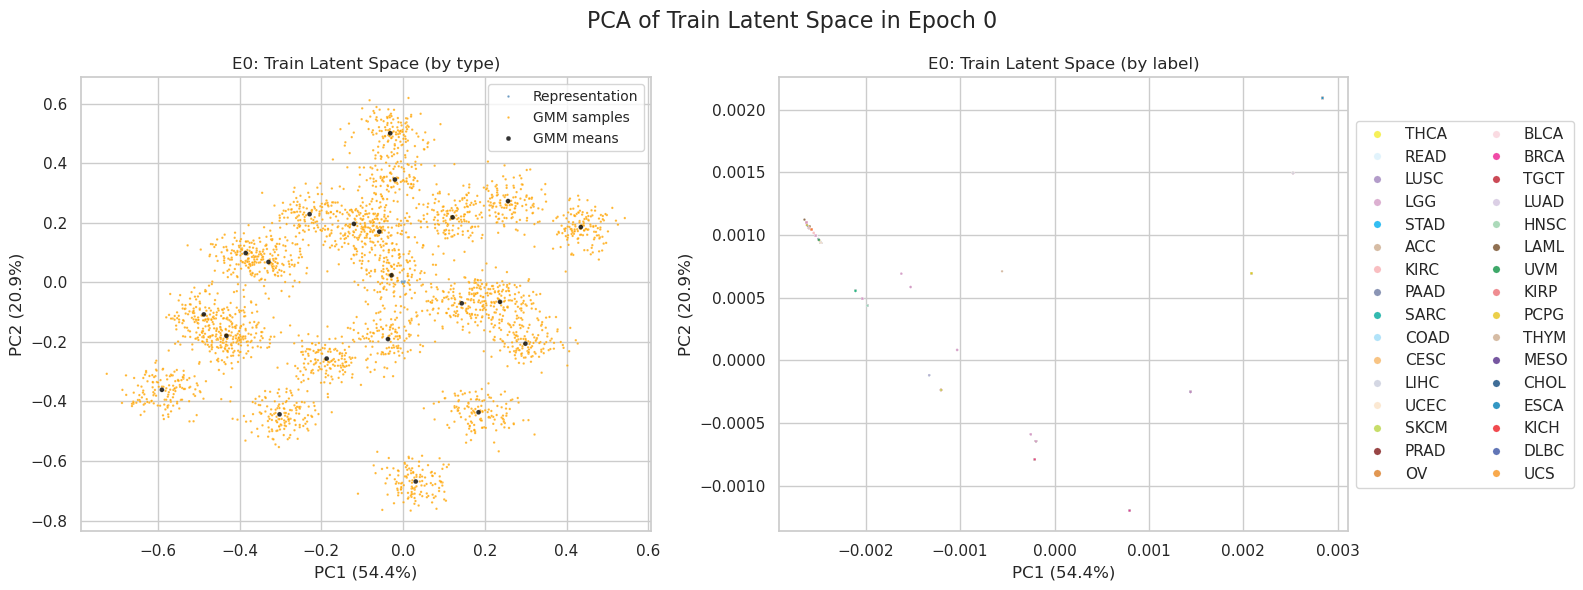

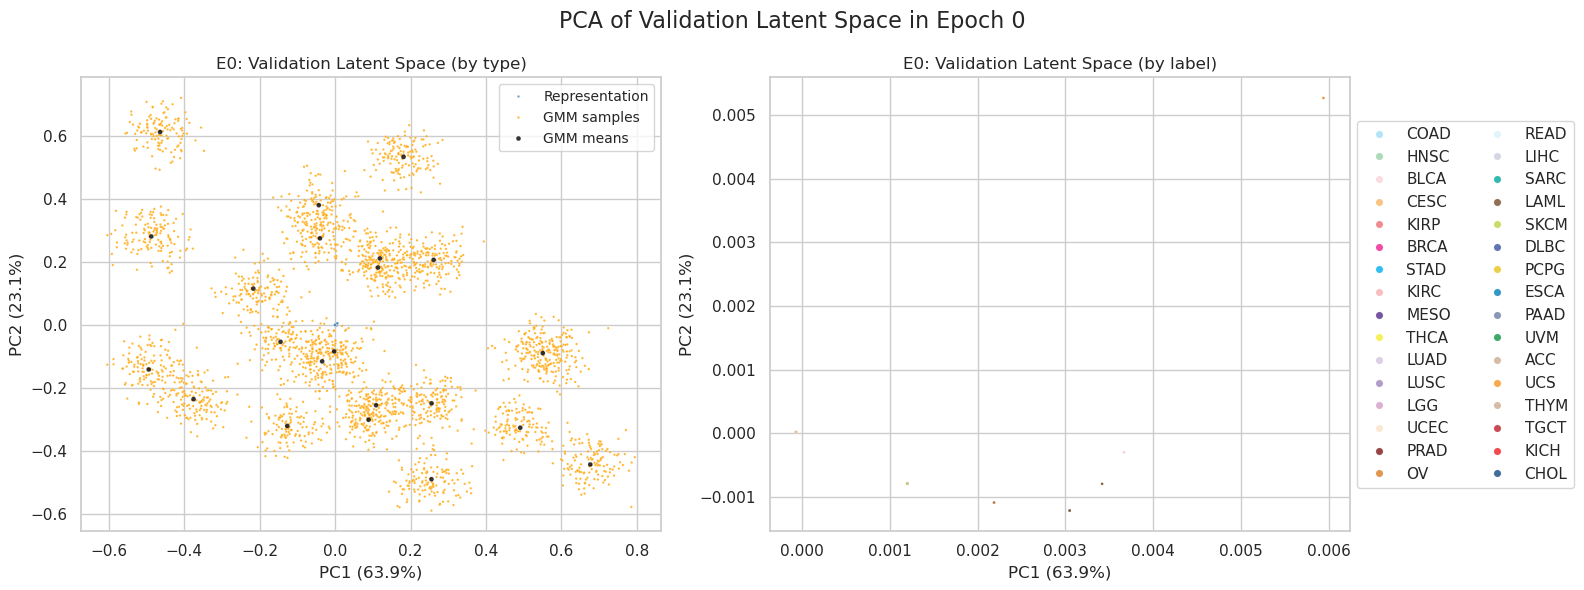

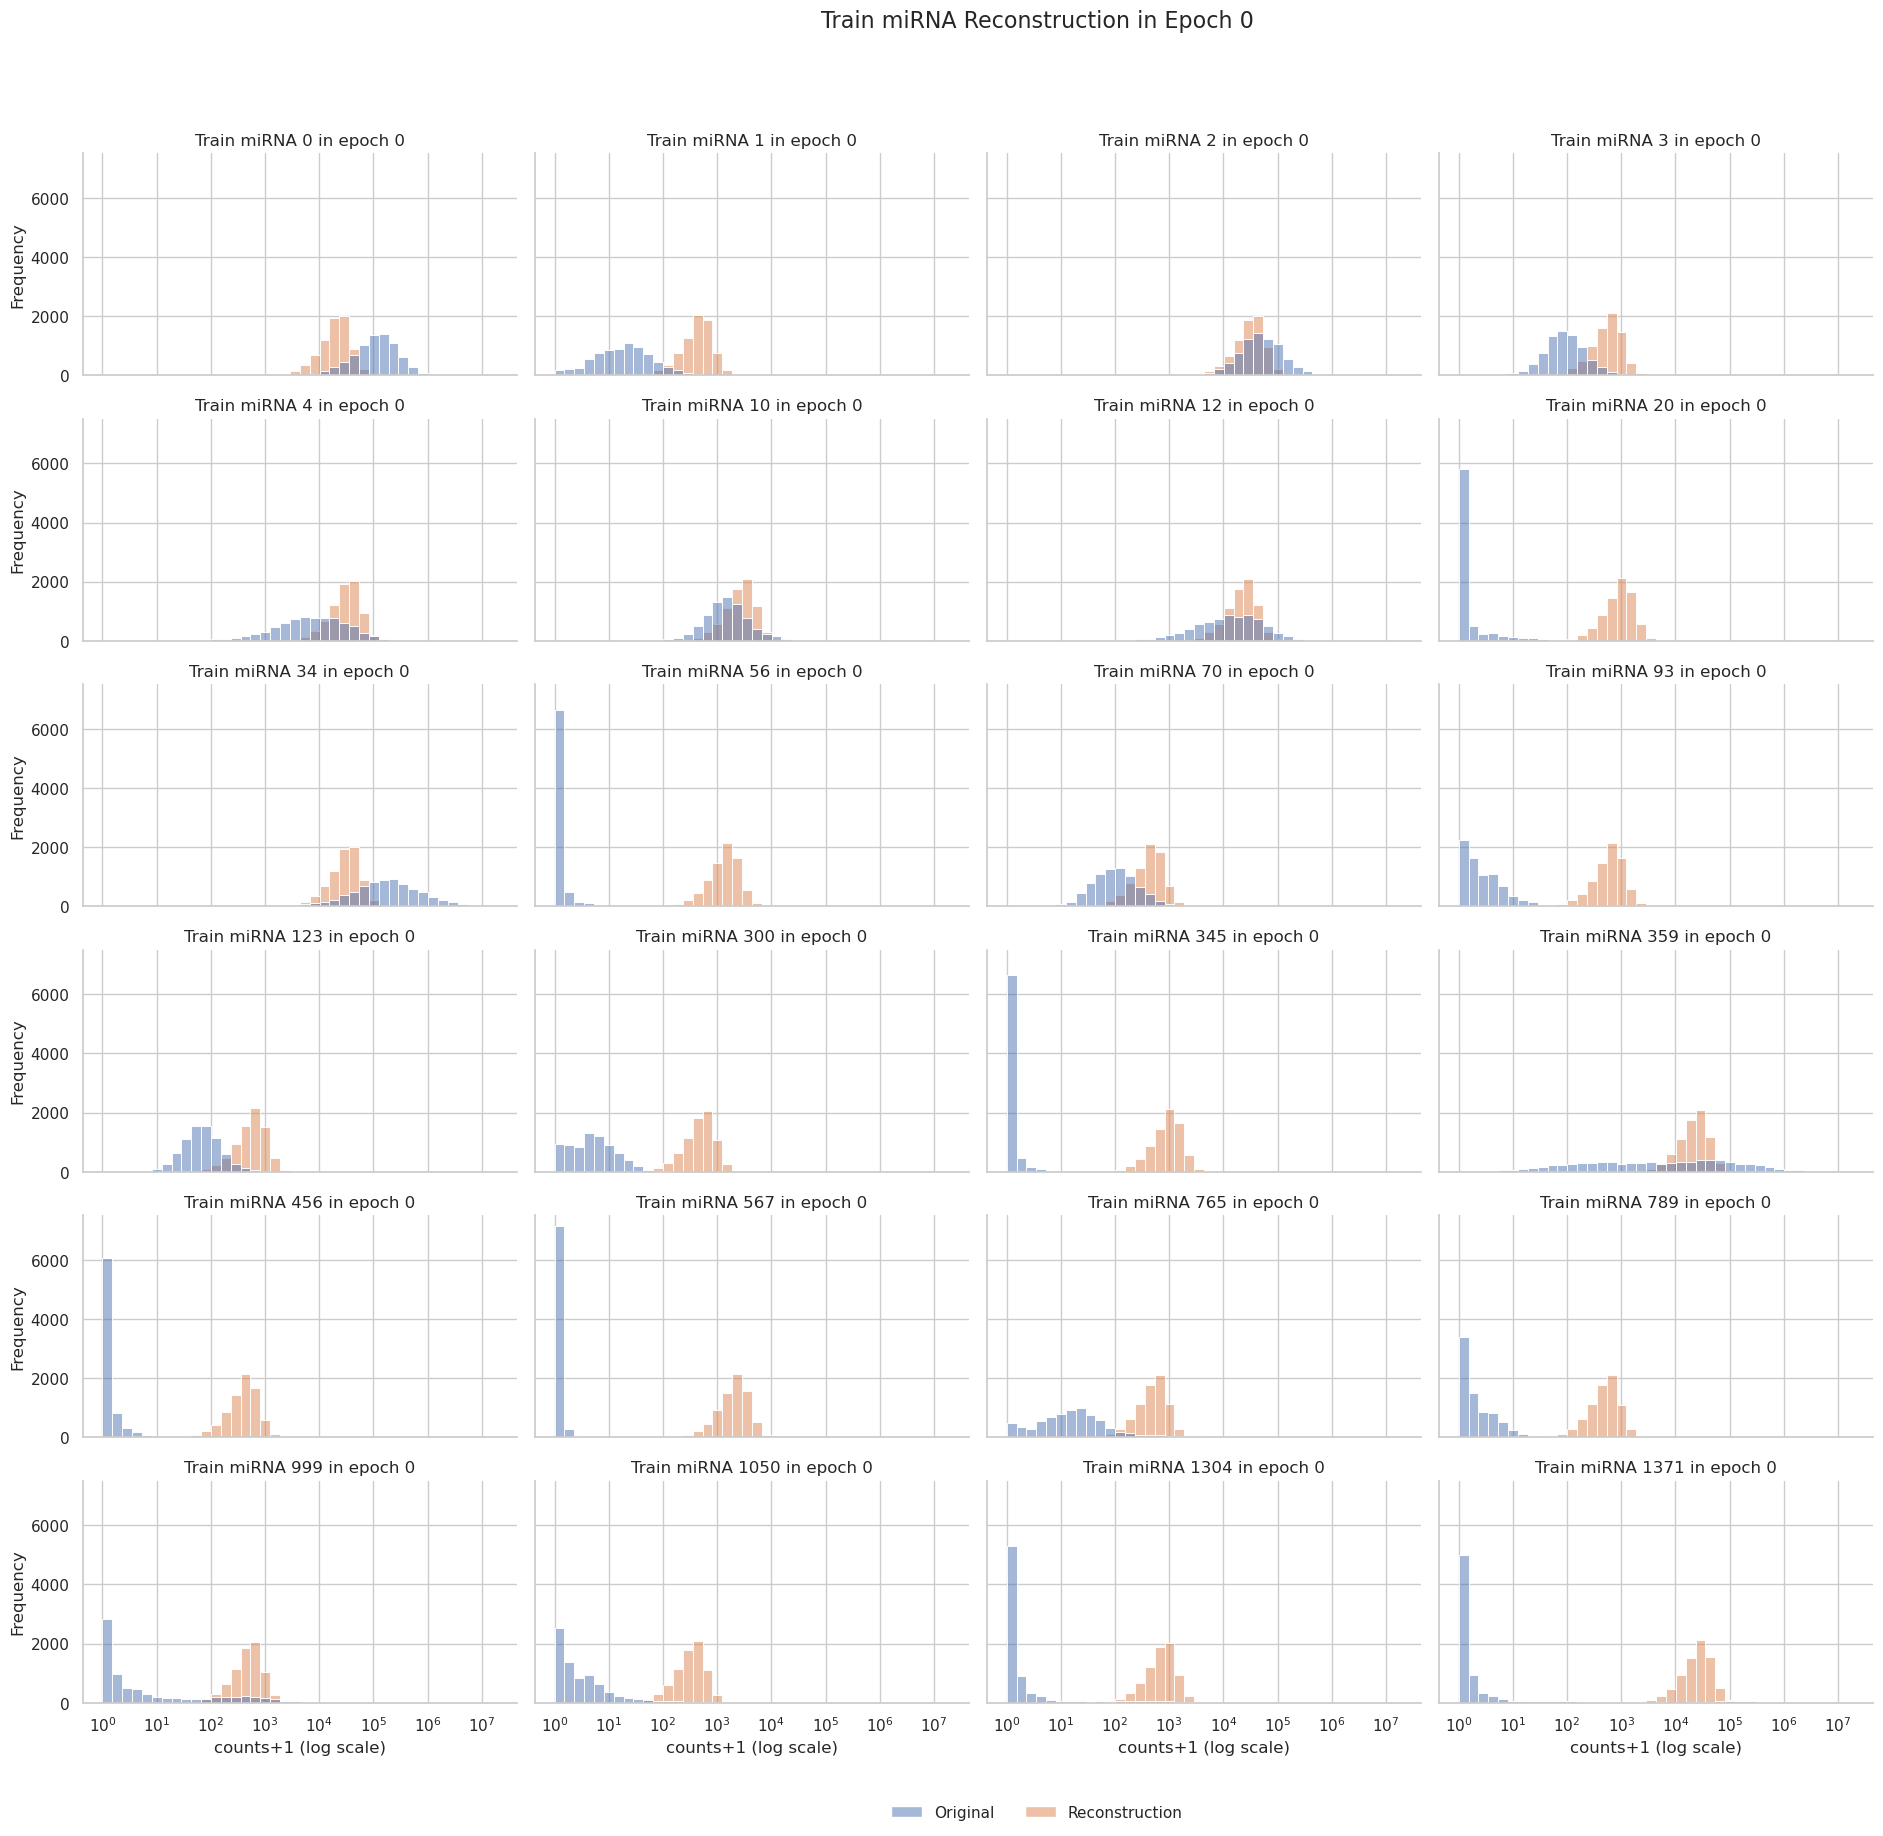

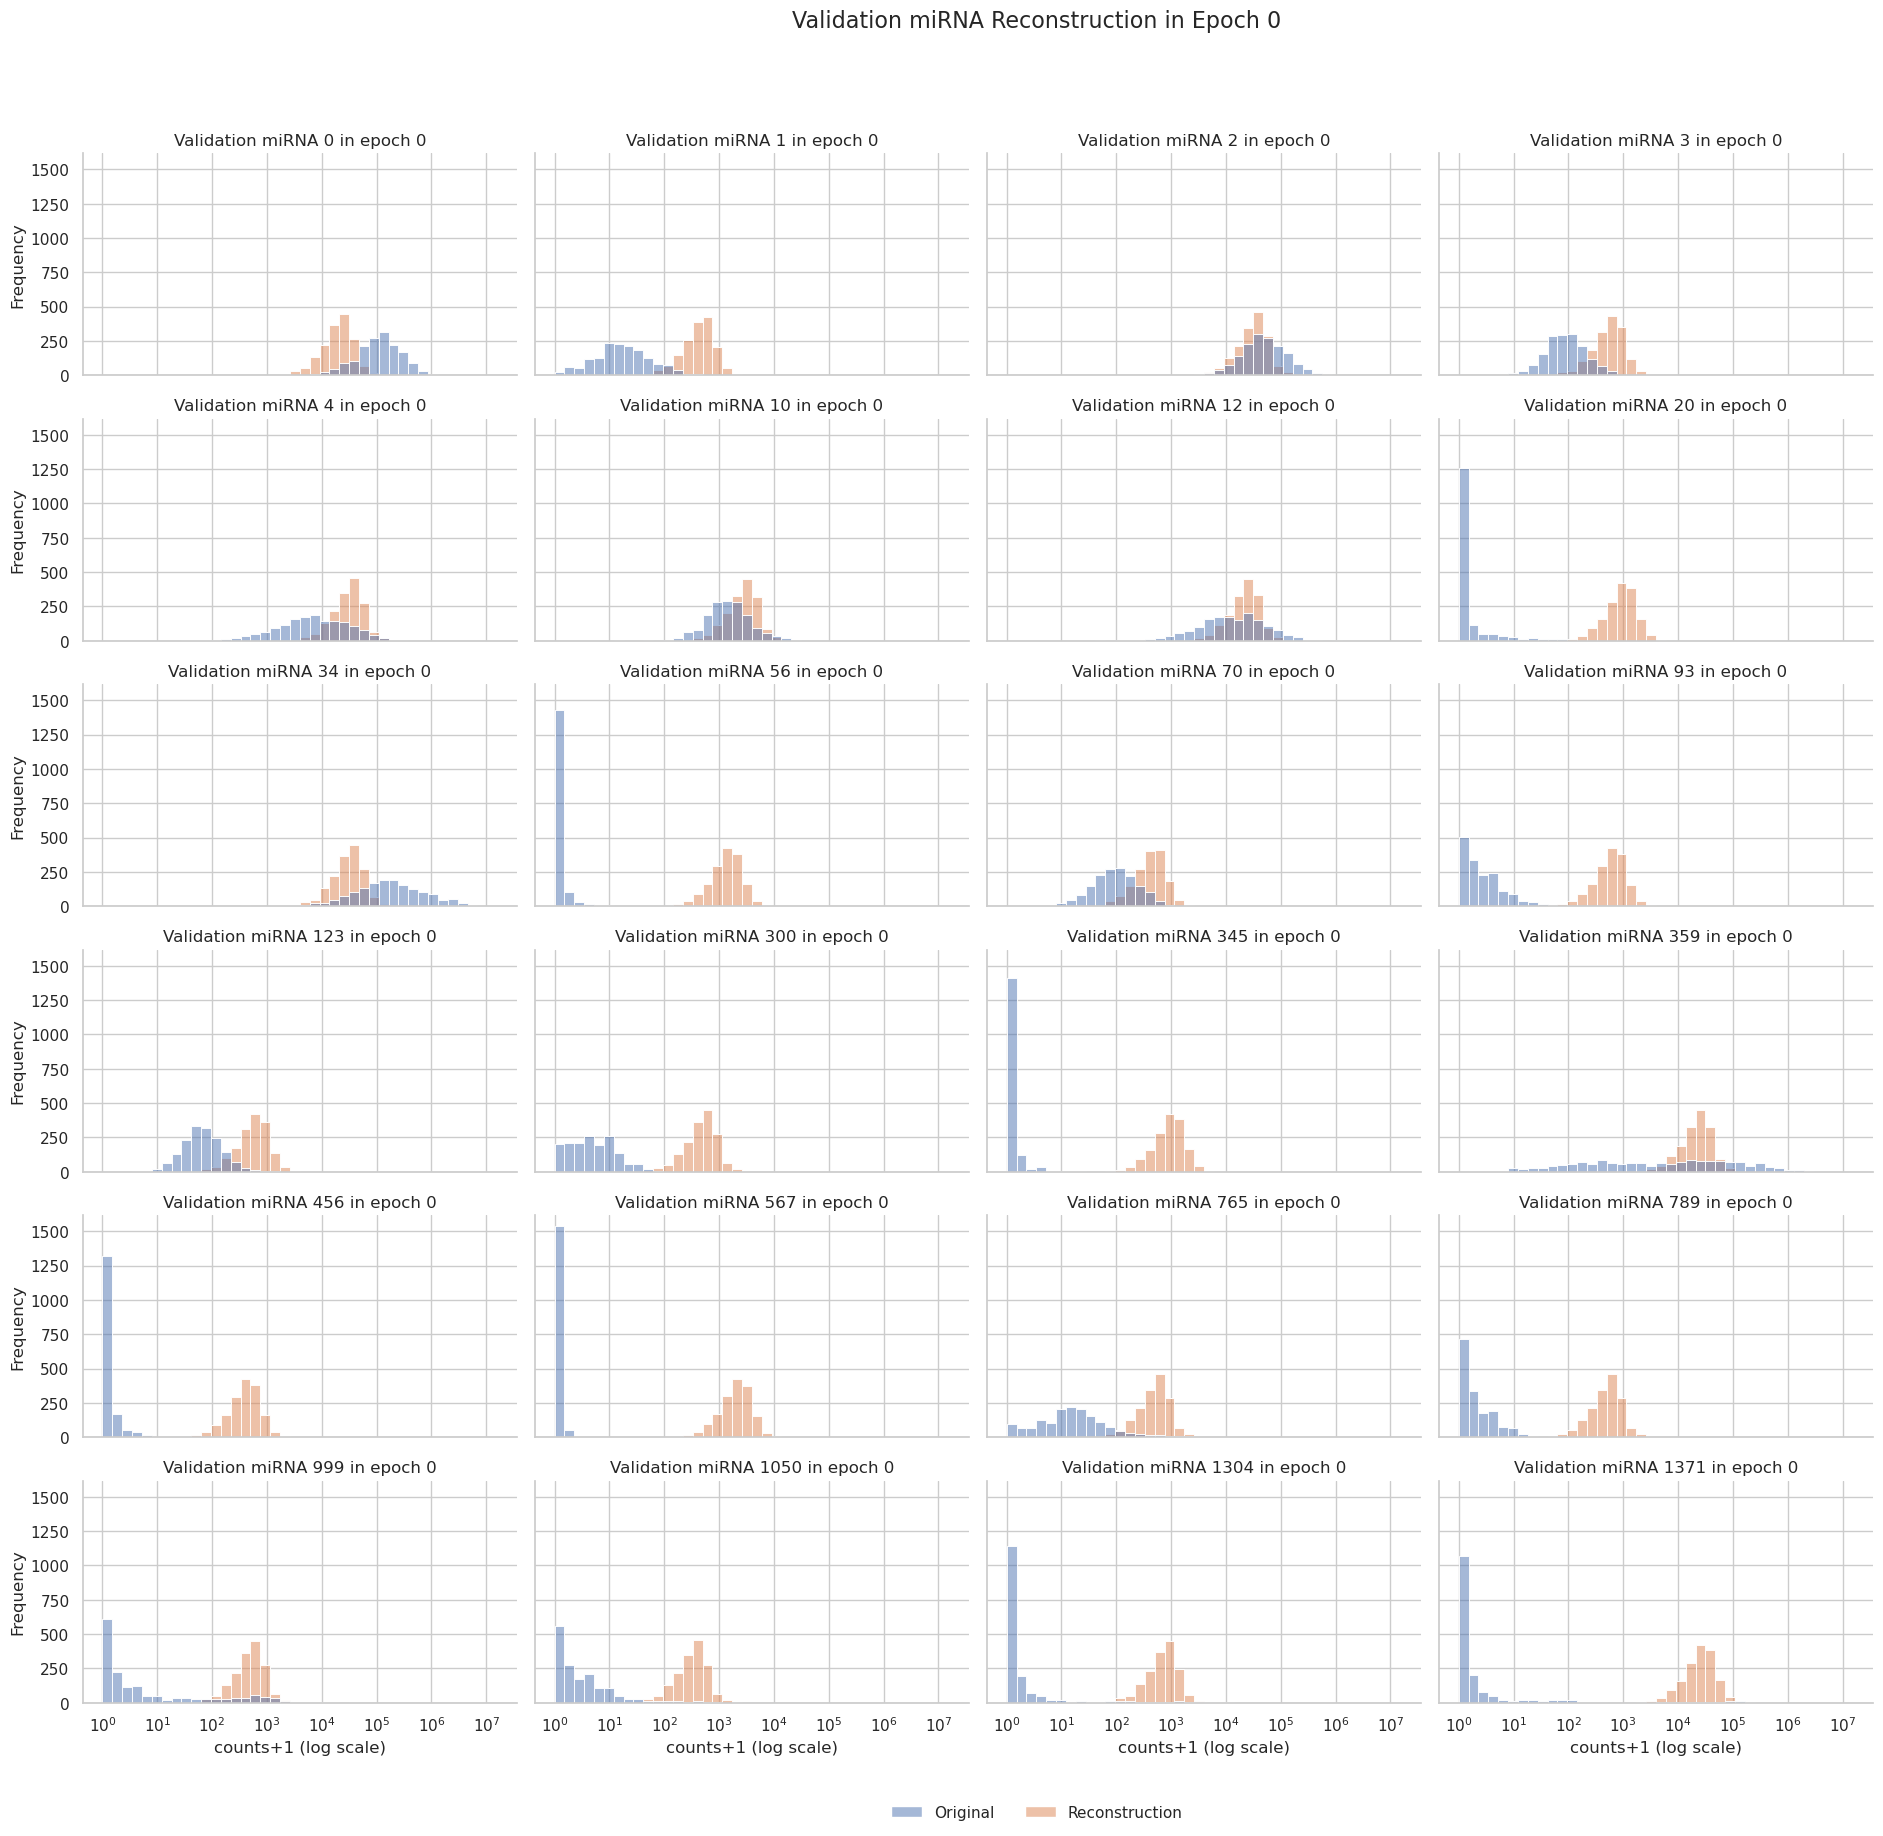

  1%|▋                                                                    | 6/601 [00:53<41:25,  4.18s/it]

5 train_loss: 4.059674955397131 train_recon: 2.6417729185327388 train_gmm: 1.4179020368643922 train_mse: 1.3542773723602295 train_mae: 0.880078911781311 train_r2: -1.9788484573364258 train_spearman: 0.27095288038253784 train_pearson: 0.3052734136581421 train_msle: 0.3804038166999817
5 test_loss: 4.034606469472191 test_recon: 2.617171433429699 test_gmm: 1.4174350360424914 test_mse: 1.1960439682006836 test_mae: 0.8124377131462097 test_r2: -1.7524700164794922 test_spearman: 0.19323211908340454 test_pearson: 0.2788465917110443 test_msle: 0.34540367126464844


  2%|█▏                                                                  | 11/601 [01:02<20:42,  2.11s/it]

10 train_loss: 3.947866259828877 train_recon: 2.532871092438047 train_gmm: 1.41499516739083 train_mse: 1.070316195487976 train_mae: 0.6432414054870605 train_r2: -1.3542516231536865 train_spearman: 0.2548726201057434 train_pearson: 0.23907802999019623 train_msle: 0.242501363158226
10 test_loss: 3.9304487673018182 test_recon: 2.5154342649295276 test_gmm: 1.4150145023722907 test_mse: 1.2372922897338867 test_mae: 0.7052491903305054 test_r2: -1.8473949432373047 test_spearman: 0.21083220839500427 test_pearson: 0.26501062512397766 test_msle: 0.28014302253723145


  3%|█▊                                                                  | 16/601 [01:10<16:25,  1.68s/it]

15 train_loss: 3.8858461384053467 train_recon: 2.4712650736987807 train_gmm: 1.4145810647065662 train_mse: 3.0914969444274902 train_mae: 1.0344676971435547 train_r2: -5.800010681152344 train_spearman: 0.2605642080307007 train_pearson: 0.22414511442184448 train_msle: 0.4554123282432556
15 test_loss: 3.886372174194853 test_recon: 2.471768837195379 test_gmm: 1.4146033369994735 test_mse: 3.2647287845611572 test_mae: 0.9964911341667175 test_r2: -6.513158321380615 test_spearman: 0.20516443252563477 test_pearson: 0.2282840460538864 test_msle: 0.43546974658966064


  3%|██▍                                                                 | 21/601 [01:19<16:47,  1.74s/it]

20 train_loss: 3.8309941309641617 train_recon: 2.4164129690585052 train_gmm: 1.4145811619056565 train_mse: 2.0839309692382812 train_mae: 0.8340267539024353 train_r2: -3.5837836265563965 train_spearman: 0.2591886818408966 train_pearson: 0.2118847519159317 train_msle: 0.34384191036224365
20 test_loss: 3.8139266287690354 test_recon: 2.39932331193387 test_gmm: 1.414603316835165 test_mse: 1.5264922380447388 test_mae: 0.7500254511833191 test_r2: -2.512934446334839 test_spearman: 0.20728164911270142 test_pearson: 0.23649083077907562 test_msle: 0.3043679893016815


  4%|██▉                                                                 | 26/601 [01:27<16:30,  1.72s/it]

25 train_loss: 3.7782349038002403 train_recon: 2.363606138100125 train_gmm: 1.4146287657001155 train_mse: 0.8623086810112 train_mae: 0.5803134441375732 train_r2: -0.896721363067627 train_spearman: 0.26059943437576294 train_pearson: 0.22167207300662994 train_msle: 0.2093784064054489
25 test_loss: 3.8032157439469763 test_recon: 2.3886021937252657 test_gmm: 1.4146135502217105 test_mse: 0.7556787133216858 test_mae: 0.5647267699241638 test_r2: -0.7390521764755249 test_spearman: 0.20972706377506256 test_pearson: 0.24875901639461517 test_msle: 0.20290429890155792


  5%|███▌                                                                | 31/601 [01:36<16:20,  1.72s/it]

30 train_loss: 3.7152689895869857 train_recon: 2.3005067522560796 train_gmm: 1.4147622373309063 train_mse: 0.5698571801185608 train_mae: 0.5792016983032227 train_r2: -0.2534494400024414 train_spearman: 0.27594828605651855 train_pearson: 0.30946314334869385 train_msle: 0.2026955783367157
30 test_loss: 3.695502977975539 test_recon: 2.2805235614999764 test_gmm: 1.4149794164755627 test_mse: 0.5715845227241516 test_mae: 0.5863164067268372 test_r2: -0.31539416313171387 test_spearman: 0.22579465806484222 test_pearson: 0.3051639199256897 test_msle: 0.20925144851207733


  6%|████                                                                | 36/601 [01:45<16:48,  1.78s/it]

35 train_loss: 3.663168796202756 train_recon: 2.248239739313174 train_gmm: 1.414929056889582 train_mse: 0.6390049457550049 train_mae: 0.65357506275177 train_r2: -0.40554583072662354 train_spearman: 0.28237485885620117 train_pearson: 0.3365539312362671 train_msle: 0.2461598962545395
35 test_loss: 3.659644105058053 test_recon: 2.24468730789551 test_gmm: 1.414956797162543 test_mse: 0.6964900493621826 test_mae: 0.6874678730964661 test_r2: -0.602840781211853 test_spearman: 0.23378071188926697 test_pearson: 0.3157474398612976 test_msle: 0.2687021791934967


  7%|████▋                                                               | 41/601 [01:53<16:03,  1.72s/it]

40 train_loss: 3.622428801386513 train_recon: 2.2073620274258743 train_gmm: 1.4150667739606384 train_mse: 0.6076525449752808 train_mae: 0.6306380033493042 train_r2: -0.3365834951400757 train_spearman: 0.2800888419151306 train_pearson: 0.327519953250885 train_msle: 0.23236018419265747
40 test_loss: 3.6117757895245557 test_recon: 2.1967431191103386 test_gmm: 1.4150326704142169 test_mse: 0.6206613183021545 test_mae: 0.6472782492637634 test_r2: -0.4283350706100464 test_spearman: 0.2324618101119995 test_pearson: 0.31842973828315735 test_msle: 0.24316540360450745


  8%|█████▏                                                              | 46/601 [02:02<15:54,  1.72s/it]

45 train_loss: 3.58974404523926 train_recon: 2.1745623041946396 train_gmm: 1.4151817410446201 train_mse: 0.4586311876773834 train_mae: 0.4949120581150055 train_r2: -0.008798360824584961 train_spearman: 0.2674494683742523 train_pearson: 0.2949344217777252 train_msle: 0.15624447166919708
45 test_loss: 3.5999511214532696 test_recon: 2.184704522849479 test_gmm: 1.415246598603791 test_mse: 0.43808218836784363 test_mae: 0.4947480857372284 test_r2: -0.008163690567016602 test_spearman: 0.21767042577266693 test_pearson: 0.2928624451160431 test_msle: 0.1563940942287445


  8%|█████▊                                                              | 51/601 [02:11<16:02,  1.75s/it]

50 train_loss: 3.561053773420973 train_recon: 2.145790190742338 train_gmm: 1.4152635826786348 train_mse: 0.6826109886169434 train_mae: 0.643933892250061 train_r2: -0.5014610290527344 train_spearman: 0.26418232917785645 train_pearson: 0.29126760363578796 train_msle: 0.24212391674518585
50 test_loss: 3.5685695298337645 test_recon: 2.15326497396637 test_gmm: 1.4153045558673945 test_mse: 0.7076735496520996 test_mae: 0.671247661113739 test_r2: -0.628577470779419 test_spearman: 0.21973468363285065 test_pearson: 0.29139307141304016 test_msle: 0.2594630718231201


  9%|██████▎                                                             | 56/601 [02:20<16:46,  1.85s/it]

55 train_loss: 3.535848660632523 train_recon: 2.120506813246396 train_gmm: 1.4153418473861272 train_mse: 0.534961998462677 train_mae: 0.5359060168266296 train_r2: -0.17669451236724854 train_spearman: 0.25731873512268066 train_pearson: 0.2730291485786438 train_msle: 0.18117813766002655
55 test_loss: 3.5222283187498977 test_recon: 2.106729242839826 test_gmm: 1.4154990759100716 test_mse: 0.47104641795158386 test_mae: 0.5049587488174438 test_r2: -0.08402454853057861 test_spearman: 0.2195456624031067 test_pearson: 0.28079766035079956 test_msle: 0.16569335758686066


 10%|██████▉                                                             | 61/601 [02:29<15:54,  1.77s/it]

60 train_loss: 3.51158573811621 train_recon: 2.096171580006865 train_gmm: 1.4154141581093451 train_mse: 0.579842746257782 train_mae: 0.5606873035430908 train_r2: -0.27541351318359375 train_spearman: 0.26042860746383667 train_pearson: 0.27544355392456055 train_msle: 0.19561418890953064
60 test_loss: 3.496765148266652 test_recon: 2.081127442735889 test_gmm: 1.4156377055307634 test_mse: 0.5109346508979797 test_mae: 0.5296632051467896 test_r2: -0.17581987380981445 test_spearman: 0.2222389280796051 test_pearson: 0.28090977668762207 test_msle: 0.18004301190376282


 11%|███████▍                                                            | 66/601 [02:37<15:25,  1.73s/it]

65 train_loss: 3.4874238682819354 train_recon: 2.071924253812407 train_gmm: 1.4154996144695282 train_mse: 0.4356623888015747 train_mae: 0.45792776346206665 train_r2: 0.04172348976135254 train_spearman: 0.2688392400741577 train_pearson: 0.29366058111190796 train_msle: 0.14141520857810974
65 test_loss: 3.484925730222902 test_recon: 2.0694125695433683 test_gmm: 1.415513160679534 test_mse: 0.4266333281993866 test_mae: 0.4654220938682556 test_r2: 0.018183767795562744 test_spearman: 0.2277645766735077 test_pearson: 0.2969520092010498 test_msle: 0.14632129669189453


 12%|████████                                                            | 71/601 [02:46<15:41,  1.78s/it]

70 train_loss: 3.465014535938944 train_recon: 2.049413575217952 train_gmm: 1.4156009607209923 train_mse: 0.43506109714508057 train_mae: 0.485443115234375 train_r2: 0.04304605722427368 train_spearman: 0.28558140993118286 train_pearson: 0.3423072099685669 train_msle: 0.15163028240203857
70 test_loss: 3.4534971084223853 test_recon: 2.037807706645797 test_gmm: 1.4156894017765884 test_mse: 0.44264161586761475 test_mae: 0.5038556456565857 test_r2: -0.018656253814697266 test_spearman: 0.23533305525779724 test_pearson: 0.33129361271858215 test_msle: 0.16322089731693268


 13%|████████▌                                                           | 76/601 [02:55<15:18,  1.75s/it]

75 train_loss: 3.4450867332782495 train_recon: 2.029369870202029 train_gmm: 1.4157168630762205 train_mse: 0.4166482985019684 train_mae: 0.4714675843715668 train_r2: 0.08354663848876953 train_spearman: 0.29623961448669434 train_pearson: 0.3687027096748352 train_msle: 0.14403636753559113
75 test_loss: 3.4322876198506878 test_recon: 2.0163929454139335 test_gmm: 1.4158946744367544 test_mse: 0.41599810123443604 test_mae: 0.4788855016231537 test_r2: 0.04265868663787842 test_spearman: 0.24199804663658142 test_pearson: 0.34533363580703735 test_msle: 0.15007954835891724


 13%|█████████▏                                                          | 81/601 [03:03<14:38,  1.69s/it]

80 train_loss: 3.4273650211803934 train_recon: 2.0115033314596578 train_gmm: 1.4158616897207357 train_mse: 0.41176241636276245 train_mae: 0.4662167727947235 train_r2: 0.09429353475570679 train_spearman: 0.305582195520401 train_pearson: 0.37863612174987793 train_msle: 0.14142780005931854
80 test_loss: 3.4201795525060916 test_recon: 2.0042075126588372 test_gmm: 1.4159720398472546 test_mse: 0.397354394197464 test_mae: 0.4551319479942322 test_r2: 0.08556365966796875 test_spearman: 0.2507901191711426 test_pearson: 0.35615912079811096 test_msle: 0.13890060782432556


 14%|█████████▋                                                          | 86/601 [03:11<14:24,  1.68s/it]

85 train_loss: 3.4100545672612506 train_recon: 1.99401395129515 train_gmm: 1.4160406159661005 train_mse: 0.509067952632904 train_mae: 0.5443769693374634 train_r2: -0.11973834037780762 train_spearman: 0.3126852512359619 train_pearson: 0.3744351863861084 train_msle: 0.18355701863765717
85 test_loss: 3.4154915647051687 test_recon: 1.9995501746067799 test_gmm: 1.4159413900983888 test_mse: 0.5390259027481079 test_mae: 0.5805686116218567 test_r2: -0.24046659469604492 test_spearman: 0.2529052793979645 test_pearson: 0.3648364841938019 test_msle: 0.20397740602493286


 15%|██████████▎                                                         | 91/601 [03:20<13:48,  1.62s/it]

90 train_loss: 3.394369939939324 train_recon: 1.9781977563646123 train_gmm: 1.4161721835747119 train_mse: 0.5511234998703003 train_mae: 0.5627546906471252 train_r2: -0.2122429609298706 train_spearman: 0.31405889987945557 train_pearson: 0.3713821470737457 train_msle: 0.19466358423233032
90 test_loss: 3.3906243543037746 test_recon: 1.974450903261425 test_gmm: 1.4161734510423496 test_mse: 0.48002973198890686 test_mae: 0.5297662019729614 test_r2: -0.1046980619430542 test_spearman: 0.2551003098487854 test_pearson: 0.3712707459926605 test_msle: 0.1773555874824524


 16%|██████████▊                                                         | 96/601 [03:28<13:56,  1.66s/it]

95 train_loss: 3.3803656266298643 train_recon: 1.9640686275433457 train_gmm: 1.4162969990865186 train_mse: 0.4058022201061249 train_mae: 0.4289097487926483 train_r2: 0.1074034571647644 train_spearman: 0.317251056432724 train_pearson: 0.36779195070266724 train_msle: 0.12788724899291992
95 test_loss: 3.3745393042910994 test_recon: 1.9581414345776973 test_gmm: 1.4163978697134023 test_mse: 0.39078083634376526 test_mae: 0.4392026662826538 test_r2: 0.10069155693054199 test_spearman: 0.25995010137557983 test_pearson: 0.36864376068115234 test_msle: 0.13352324068546295


 17%|███████████▏                                                       | 100/601 [03:34<13:16,  1.59s/it]

100 train_loss: 3.365906262208957 train_recon: 1.9495154951600466 train_gmm: 1.4163907670489104 train_mse: 0.3938898742198944 train_mae: 0.4183398485183716 train_r2: 0.1336057186126709 train_spearman: 0.32050612568855286 train_pearson: 0.38362330198287964 train_msle: 0.12299957126379013
100 test_loss: 3.372808000054019 test_recon: 1.9562658698367867 test_gmm: 1.4165421302172325 test_mse: 0.3810661733150482 test_mae: 0.41491588950157166 test_r2: 0.12304800748825073 test_spearman: 0.2598339021205902 test_pearson: 0.36769887804985046 test_msle: 0.12477447092533112


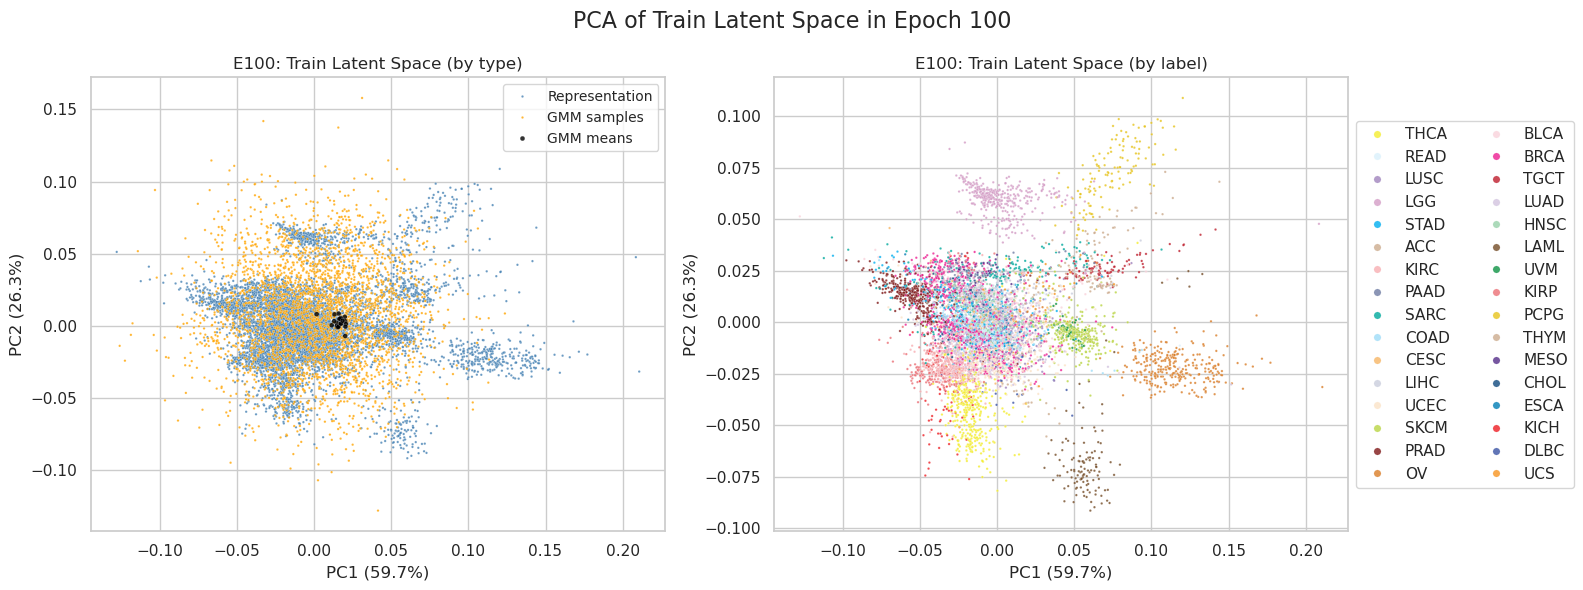

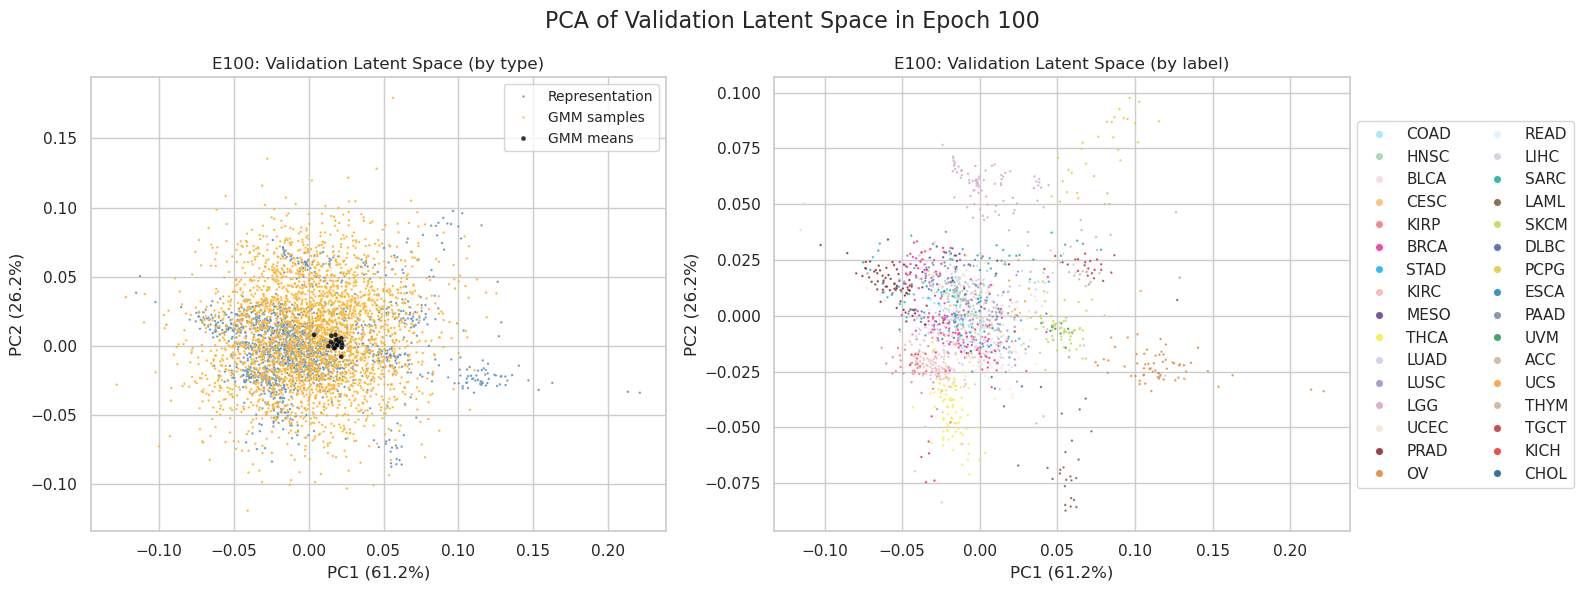

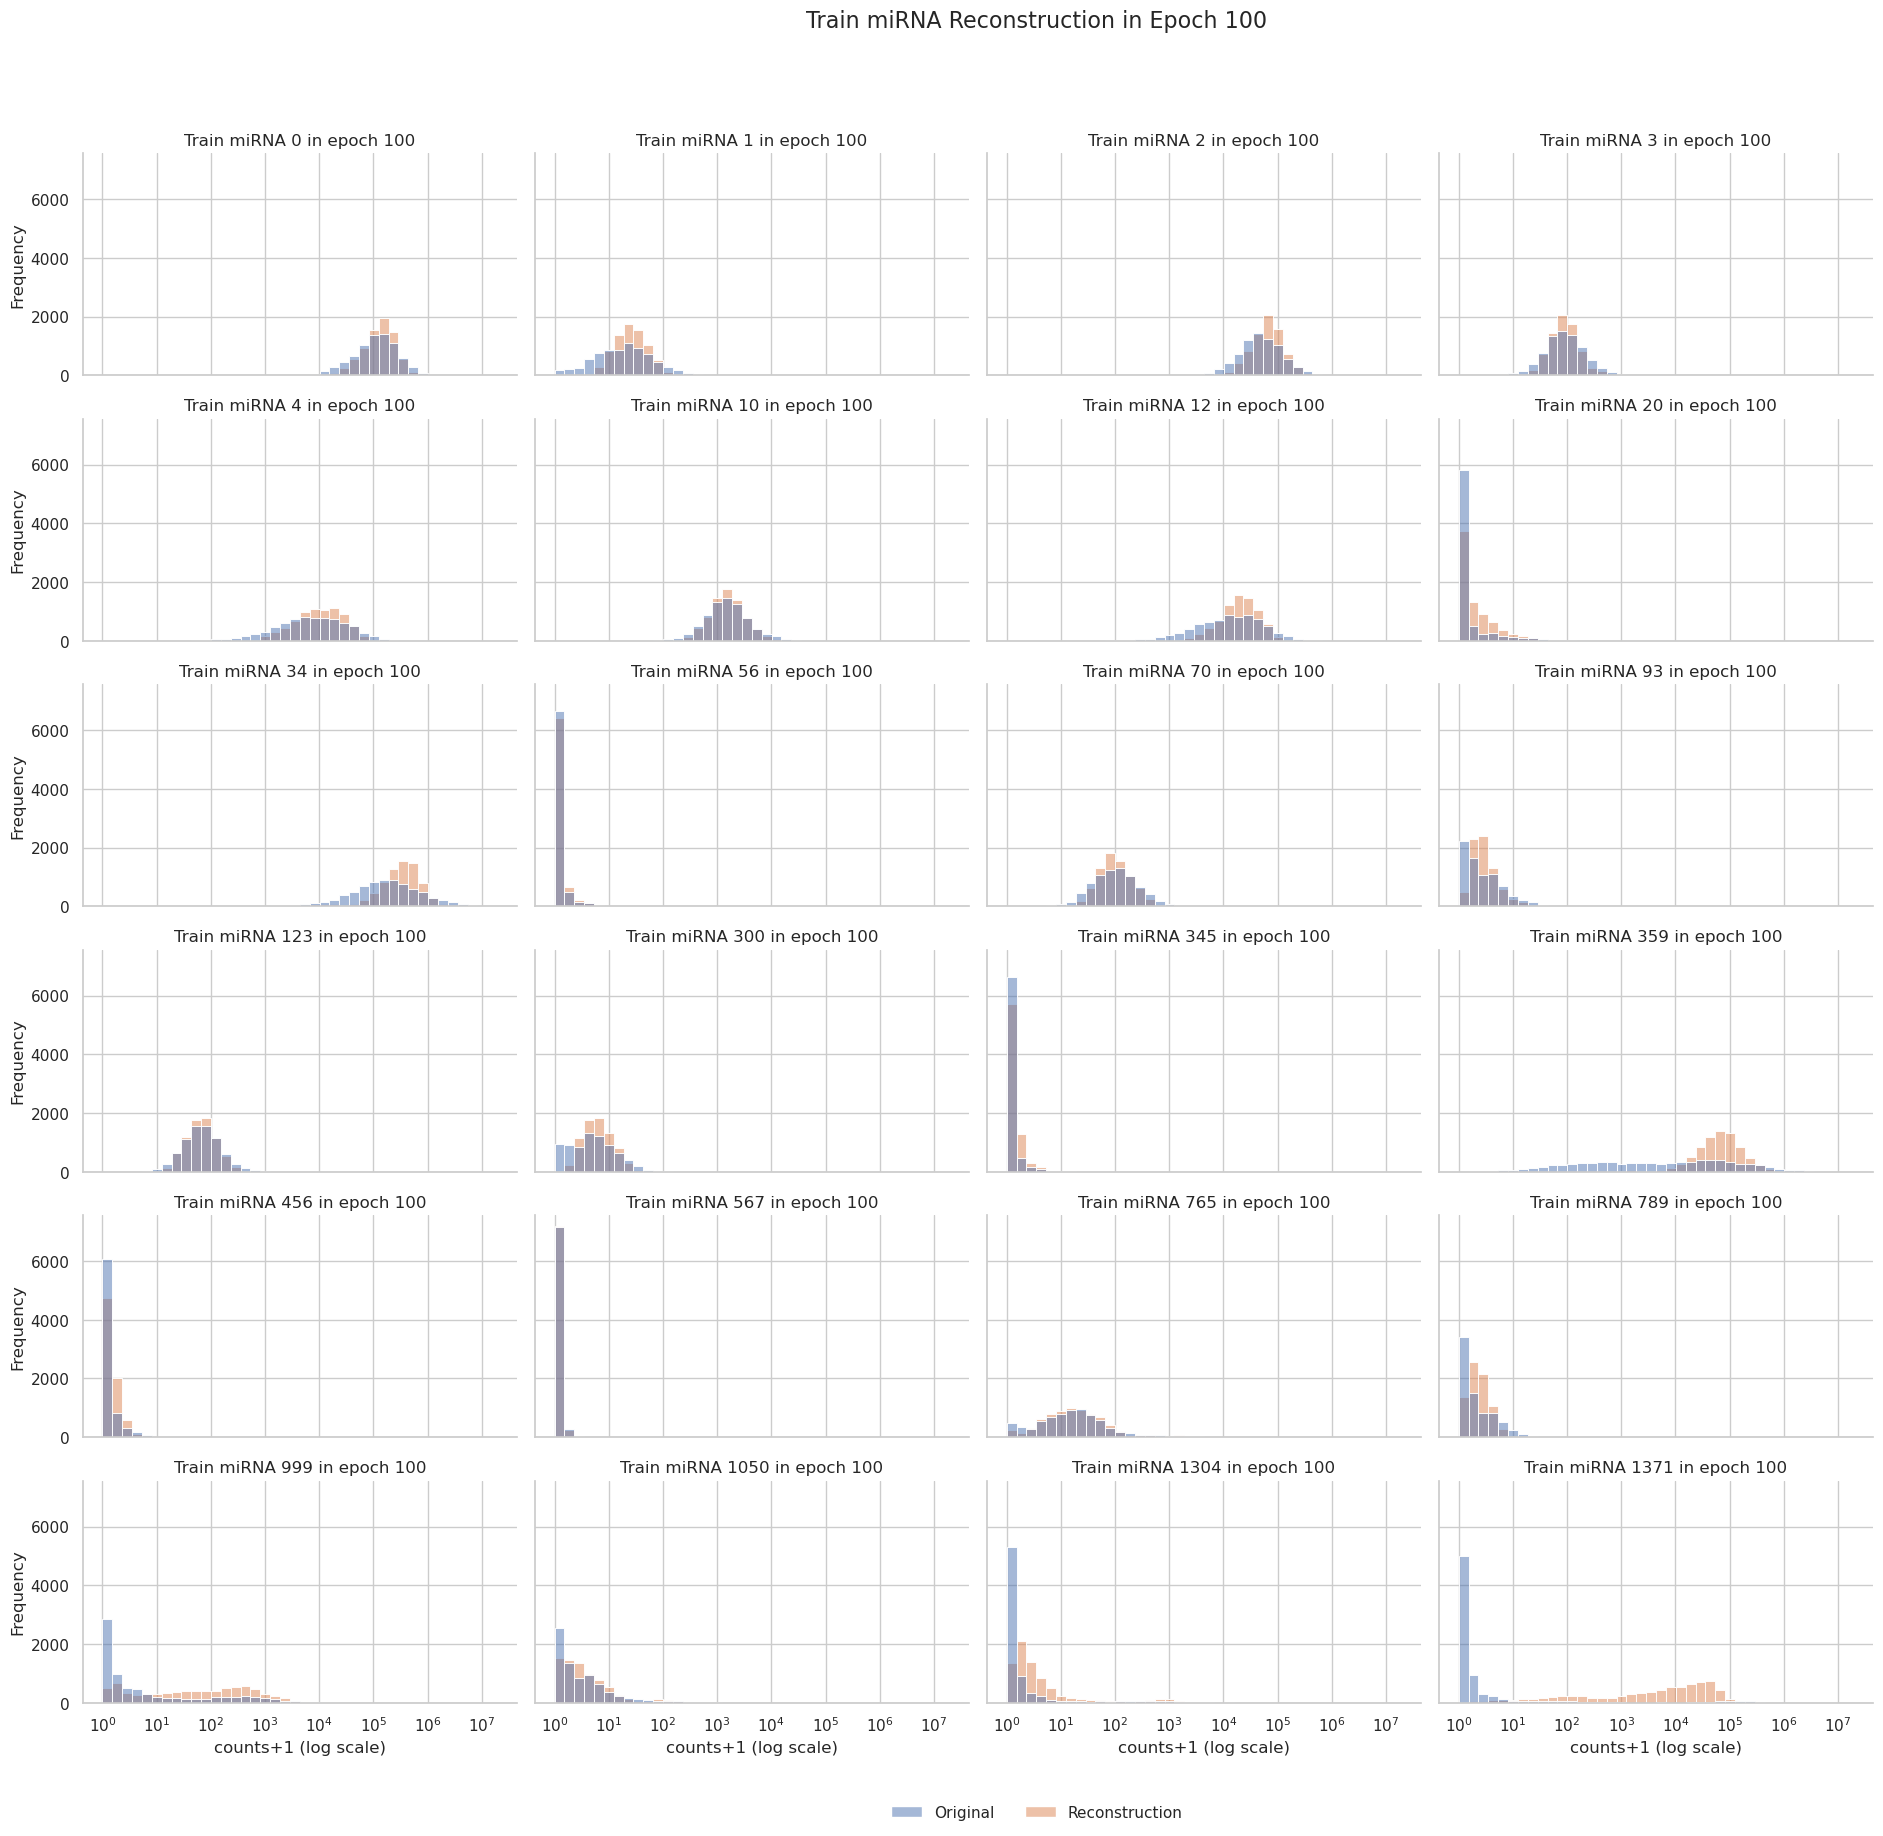

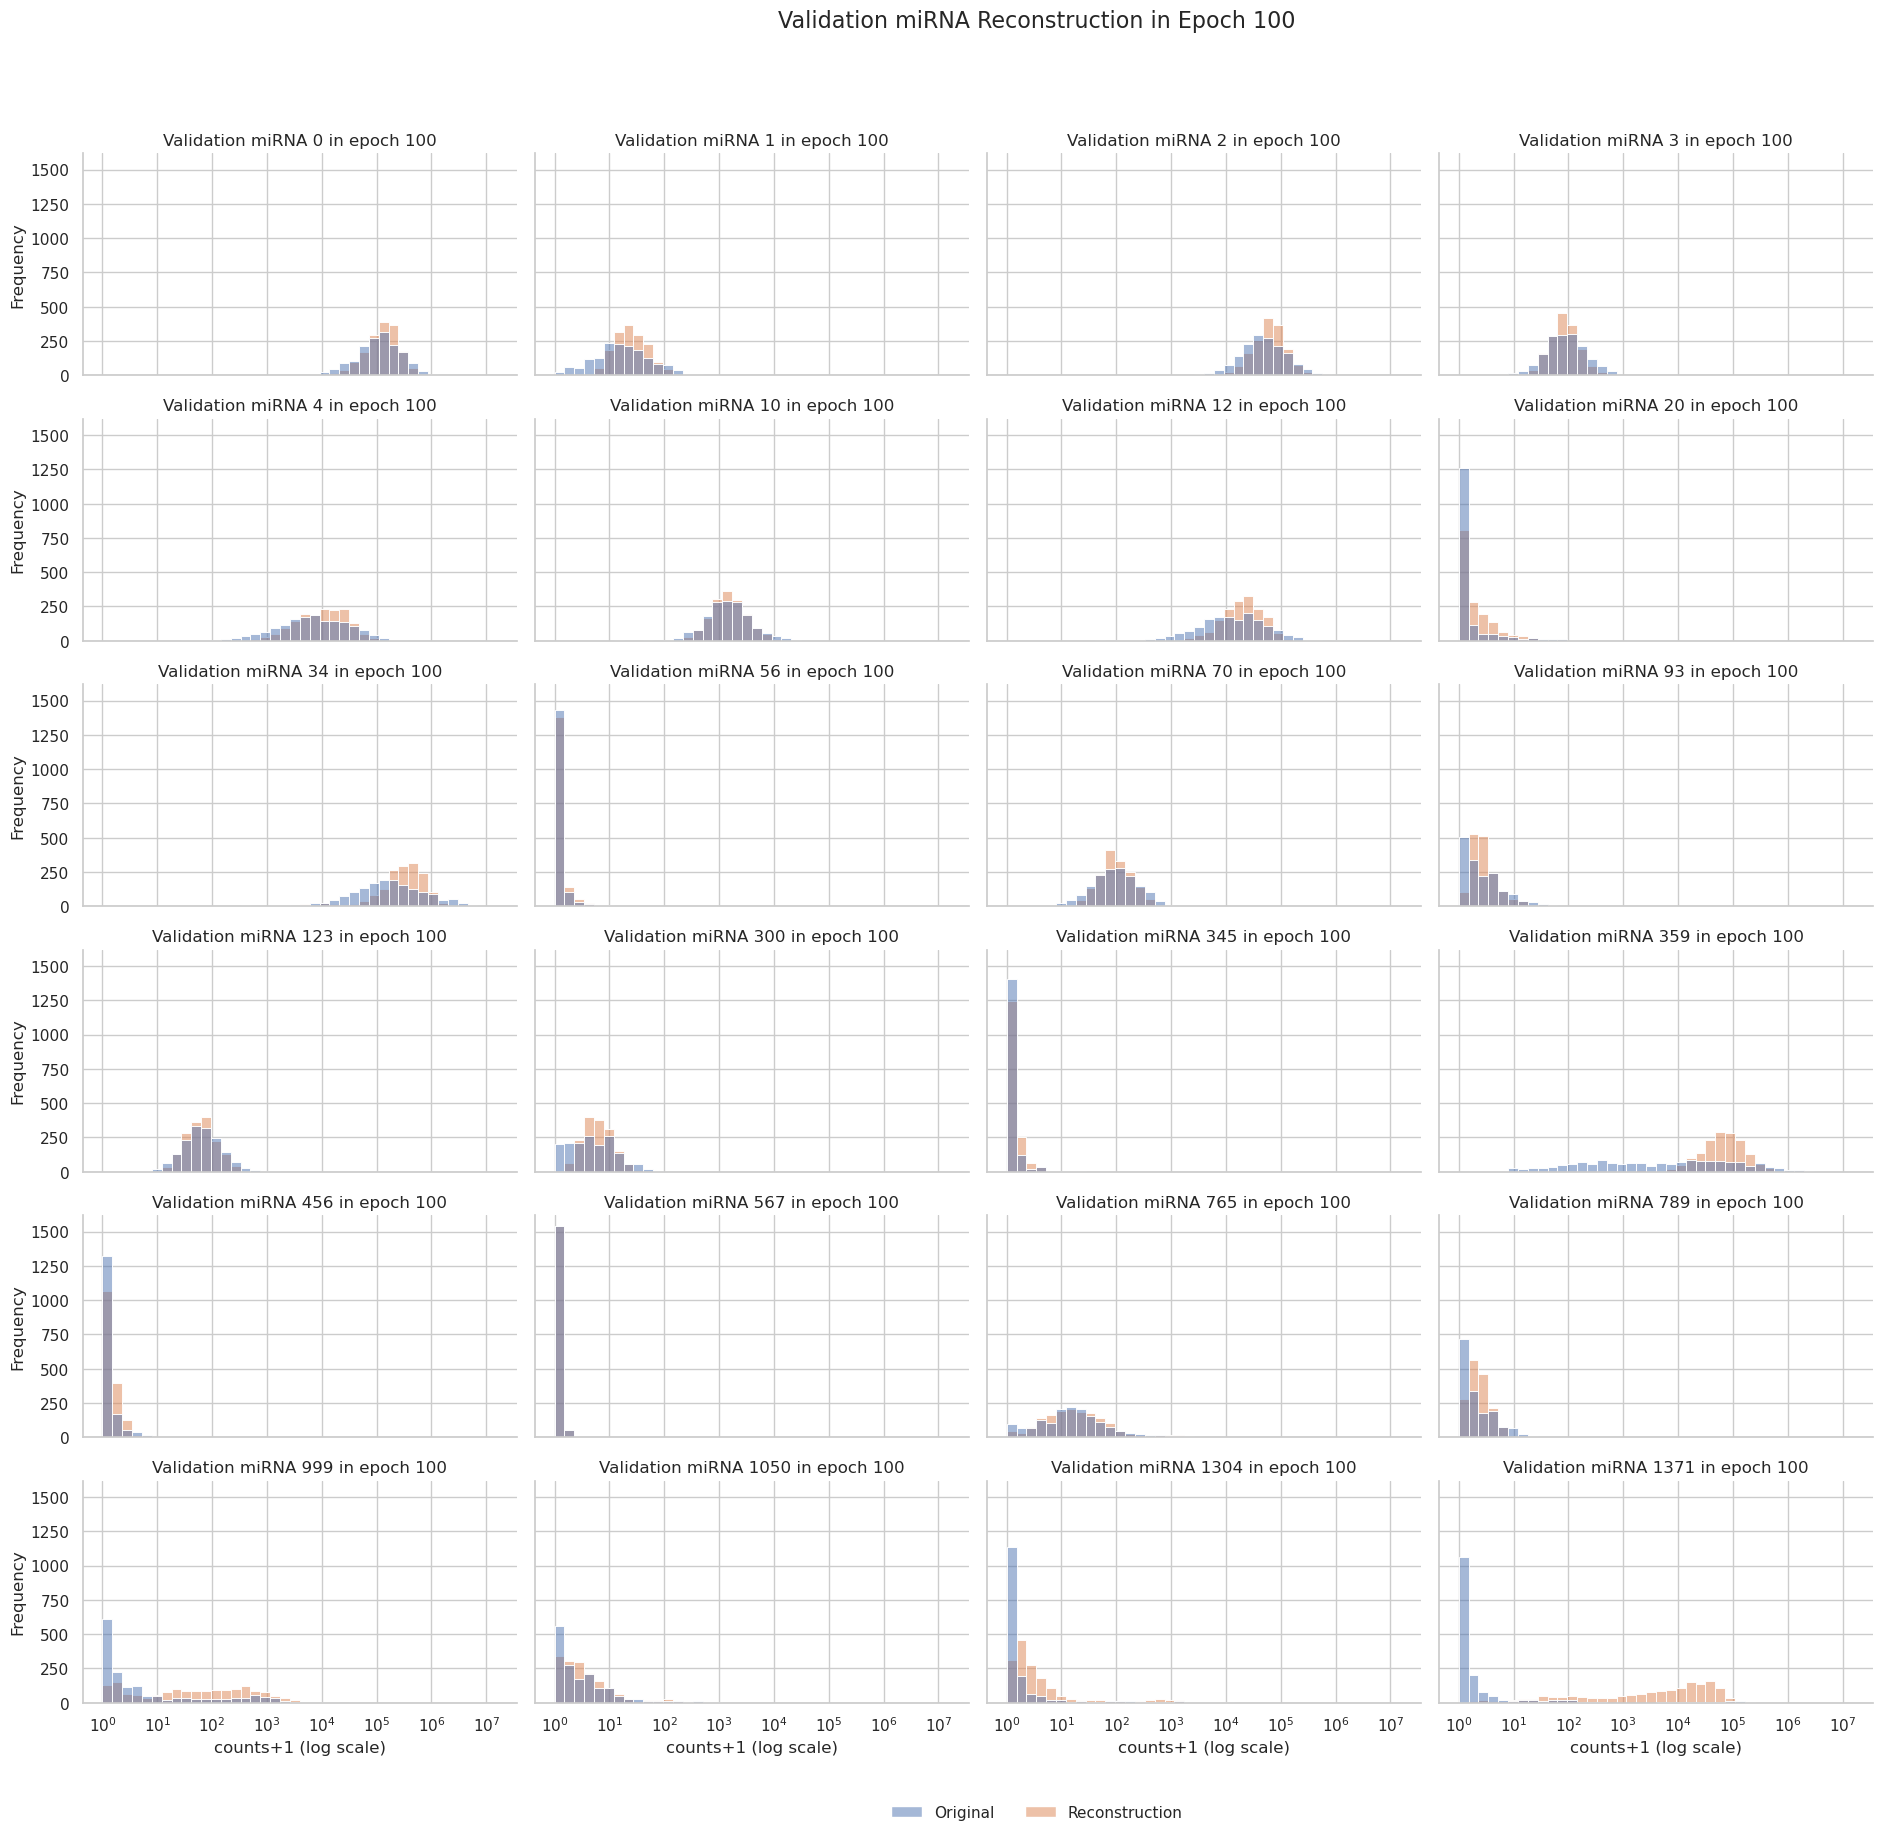

 18%|███████████▊                                                       | 106/601 [04:30<32:45,  3.97s/it]

105 train_loss: 3.3547575122323825 train_recon: 1.938235404372738 train_gmm: 1.4165221078596446 train_mse: 0.3892098069190979 train_mae: 0.4151909351348877 train_r2: 0.14389991760253906 train_spearman: 0.324421226978302 train_pearson: 0.39144137501716614 train_msle: 0.12124209851026535
105 test_loss: 3.345384303173681 test_recon: 1.9285033571224013 test_gmm: 1.41688094605128 test_mse: 0.3887501060962677 test_mae: 0.44145822525024414 test_r2: 0.10536479949951172 test_spearman: 0.26166993379592896 test_pearson: 0.37759873270988464 test_msle: 0.13395686447620392


 18%|████████████▎                                                      | 111/601 [04:39<17:22,  2.13s/it]

110 train_loss: 3.344935008249951 train_recon: 1.928312946245813 train_gmm: 1.4166220620041379 train_mse: 0.3891907036304474 train_mae: 0.4209963381290436 train_r2: 0.14394187927246094 train_spearman: 0.3258253037929535 train_pearson: 0.3997125029563904 train_msle: 0.12353701144456863
110 test_loss: 3.3354478053854004 test_recon: 1.9187061342126832 test_gmm: 1.4167416711727174 test_mse: 0.3876192271709442 test_mae: 0.4402761459350586 test_r2: 0.1079673171043396 test_spearman: 0.261701375246048 test_pearson: 0.3795715868473053 test_msle: 0.13358084857463837


 19%|████████████▉                                                      | 116/601 [04:47<13:59,  1.73s/it]

115 train_loss: 3.338158169393347 train_recon: 1.921462230680648 train_gmm: 1.416695938712699 train_mse: 0.40012991428375244 train_mae: 0.441131055355072 train_r2: 0.11988019943237305 train_spearman: 0.32669419050216675 train_pearson: 0.40749627351760864 train_msle: 0.13200129568576813
115 test_loss: 3.32359457983143 test_recon: 1.9065636163662534 test_gmm: 1.4170309634651768 test_mse: 0.38794004917144775 test_mae: 0.4394400417804718 test_r2: 0.10722905397415161 test_spearman: 0.2638322114944458 test_pearson: 0.3816535770893097 test_msle: 0.1332225352525711


 20%|█████████████▍                                                     | 121/601 [04:55<13:43,  1.72s/it]

120 train_loss: 3.331221655674676 train_recon: 1.9144103762014928 train_gmm: 1.4168112794731833 train_mse: 0.4827398657798767 train_mae: 0.5209973454475403 train_r2: -0.06182742118835449 train_spearman: 0.32595324516296387 train_pearson: 0.41058602929115295 train_msle: 0.17142607271671295
120 test_loss: 3.3259795118807967 test_recon: 1.909003198732635 test_gmm: 1.4169763131481616 test_mse: 0.42635464668273926 test_mae: 0.48019665479660034 test_r2: 0.018825113773345947 test_spearman: 0.26481711864471436 test_pearson: 0.3782178461551666 test_msle: 0.15213391184806824


 21%|██████████████                                                     | 126/601 [05:04<13:32,  1.71s/it]

125 train_loss: 3.3246413514534163 train_recon: 1.9077546282063387 train_gmm: 1.4168867232470779 train_mse: 0.39917677640914917 train_mae: 0.4477269649505615 train_r2: 0.12197673320770264 train_spearman: 0.3254755139350891 train_pearson: 0.41504377126693726 train_msle: 0.13470874726772308
125 test_loss: 3.314253976371821 test_recon: 1.8974250794417644 test_gmm: 1.4168288969300566 test_mse: 0.4108043909072876 test_mae: 0.4711885154247284 test_r2: 0.054611027240753174 test_spearman: 0.2648664712905884 test_pearson: 0.38248127698898315 test_msle: 0.14663809537887573


 22%|██████████████▌                                                    | 131/601 [05:13<14:15,  1.82s/it]

130 train_loss: 3.3197716551019623 train_recon: 1.9027874876069 train_gmm: 1.416984167495062 train_mse: 0.38288623094558716 train_mae: 0.41625964641571045 train_r2: 0.15780913829803467 train_spearman: 0.3253524601459503 train_pearson: 0.41386908292770386 train_msle: 0.12216733396053314
130 test_loss: 3.30741079528236 test_recon: 1.8903740345784996 test_gmm: 1.41703676070386 test_mse: 0.3884735107421875 test_mae: 0.4376954734325409 test_r2: 0.10600143671035767 test_spearman: 0.26488345861434937 test_pearson: 0.38271817564964294 test_msle: 0.13266584277153015


 23%|███████████████▏                                                   | 136/601 [05:22<13:35,  1.75s/it]

135 train_loss: 3.312898100755771 train_recon: 1.895821114609432 train_gmm: 1.417076986146339 train_mse: 0.38703179359436035 train_mae: 0.4278659522533417 train_r2: 0.1486905813217163 train_spearman: 0.327924907207489 train_pearson: 0.41136816143989563 train_msle: 0.125685915350914
135 test_loss: 3.3019018227033925 test_recon: 1.8848573037818508 test_gmm: 1.4170445189215417 test_mse: 0.3842862844467163 test_mae: 0.43547073006629944 test_r2: 0.11563748121261597 test_spearman: 0.2664894461631775 test_pearson: 0.382785826921463 test_msle: 0.13110089302062988


 23%|███████████████▋                                                   | 141/601 [05:31<13:40,  1.78s/it]

140 train_loss: 3.3090963843391425 train_recon: 1.8919097975785952 train_gmm: 1.4171865867605473 train_mse: 0.4162423312664032 train_mae: 0.4608050584793091 train_r2: 0.08443951606750488 train_spearman: 0.3287469744682312 train_pearson: 0.4156329929828644 train_msle: 0.14160118997097015
140 test_loss: 3.307244666586 test_recon: 1.890211782470442 test_gmm: 1.417032884115558 test_mse: 0.4443102478981018 test_mae: 0.4957495629787445 test_r2: -0.022496342658996582 test_spearman: 0.2665027976036072 test_pearson: 0.3824300169944763 test_msle: 0.1597357839345932


 24%|████████████████▎                                                  | 146/601 [05:39<13:10,  1.74s/it]

145 train_loss: 3.305145383173637 train_recon: 1.8878915594823842 train_gmm: 1.4172538236912526 train_mse: 0.42034435272216797 train_mae: 0.46555468440055847 train_r2: 0.07541680335998535 train_spearman: 0.32827088236808777 train_pearson: 0.41241195797920227 train_msle: 0.14343495666980743
145 test_loss: 3.293327450691498 test_recon: 1.8759763334597572 test_gmm: 1.4173511172317406 test_mse: 0.398204505443573 test_mae: 0.4502958357334137 test_r2: 0.08360731601715088 test_spearman: 0.2659502327442169 test_pearson: 0.38237306475639343 test_msle: 0.13840597867965698


 25%|████████████████▊                                                  | 151/601 [05:48<13:13,  1.76s/it]

150 train_loss: 3.301202422720702 train_recon: 1.8838504603479642 train_gmm: 1.4173519623727375 train_mse: 0.4836517870426178 train_mae: 0.5072326064109802 train_r2: -0.06383335590362549 train_spearman: 0.3293863832950592 train_pearson: 0.40986812114715576 train_msle: 0.165716752409935
150 test_loss: 3.29352058268455 test_recon: 1.8760958153161438 test_gmm: 1.4174247673684062 test_mse: 0.49940744042396545 test_mae: 0.5298893451690674 test_r2: -0.14929211139678955 test_spearman: 0.266390860080719 test_pearson: 0.37701383233070374 test_msle: 0.17758555710315704


 26%|█████████████████▍                                                 | 156/601 [05:57<13:09,  1.77s/it]

155 train_loss: 3.2971959758132634 train_recon: 1.8797604470626534 train_gmm: 1.4174355287506097 train_mse: 0.4150077998638153 train_mae: 0.4560137689113617 train_r2: 0.08715498447418213 train_spearman: 0.3288027346134186 train_pearson: 0.40678709745407104 train_msle: 0.13970832526683807
155 test_loss: 3.292982728687665 test_recon: 1.8750771937947008 test_gmm: 1.4179055348929646 test_mse: 0.4283865988254547 test_mae: 0.48437029123306274 test_r2: 0.014148890972137451 test_spearman: 0.2661389410495758 test_pearson: 0.3856680393218994 test_msle: 0.15433642268180847


 27%|█████████████████▉                                                 | 161/601 [06:06<12:48,  1.75s/it]

160 train_loss: 3.2927999463590245 train_recon: 1.8752758303575348 train_gmm: 1.4175241160014898 train_mse: 0.37834006547927856 train_mae: 0.37441205978393555 train_r2: 0.16780883073806763 train_spearman: 0.3293614685535431 train_pearson: 0.41353195905685425 train_msle: 0.10994008183479309
160 test_loss: 3.298481705249066 test_recon: 1.8809213026597753 test_gmm: 1.4175604025892907 test_mse: 0.36967894434928894 test_mae: 0.388813316822052 test_r2: 0.14925354719161987 test_spearman: 0.2633286714553833 test_pearson: 0.3874201476573944 test_msle: 0.11638373881578445


 28%|██████████████████▌                                                | 166/601 [06:14<12:09,  1.68s/it]

165 train_loss: 3.2905507858932053 train_recon: 1.8729406594967177 train_gmm: 1.4176101263964873 train_mse: 0.3792738616466522 train_mae: 0.4006805121898651 train_r2: 0.16575485467910767 train_spearman: 0.3329809904098511 train_pearson: 0.41627272963523865 train_msle: 0.11755842715501785
165 test_loss: 3.2820895839416524 test_recon: 1.8645049035249708 test_gmm: 1.4175846804166816 test_mse: 0.3752724528312683 test_mae: 0.4107920229434967 test_r2: 0.1363811492919922 test_spearman: 0.26436933875083923 test_pearson: 0.38837751746177673 test_msle: 0.12386762350797653


 28%|███████████████████                                                | 171/601 [06:23<12:38,  1.76s/it]

170 train_loss: 3.2872498097951857 train_recon: 1.869551587543219 train_gmm: 1.4176982222519665 train_mse: 0.4080984890460968 train_mae: 0.4444277882575989 train_r2: 0.10235261917114258 train_spearman: 0.3314458131790161 train_pearson: 0.41491323709487915 train_msle: 0.1353679597377777
170 test_loss: 3.277134662778698 test_recon: 1.8592096088351402 test_gmm: 1.417925053943558 test_mse: 0.3820004165172577 test_mae: 0.4207897186279297 test_r2: 0.12089800834655762 test_spearman: 0.2635958194732666 test_pearson: 0.38509634137153625 test_msle: 0.12806425988674164


 29%|███████████████████▌                                               | 176/601 [06:32<12:28,  1.76s/it]

175 train_loss: 3.284945756964863 train_recon: 1.8671837170301888 train_gmm: 1.417762039934674 train_mse: 0.3901667594909668 train_mae: 0.4213846027851105 train_r2: 0.14179497957229614 train_spearman: 0.33160462975502014 train_pearson: 0.4134519100189209 train_msle: 0.12555015087127686
175 test_loss: 3.2747705128985087 test_recon: 1.8568718842811929 test_gmm: 1.4178986286173156 test_mse: 0.37772804498672485 test_mae: 0.41360610723495483 test_r2: 0.13073009252548218 test_spearman: 0.2649891674518585 test_pearson: 0.3841347396373749 test_msle: 0.12476998567581177


 30%|████████████████████▏                                              | 181/601 [06:40<12:09,  1.74s/it]

180 train_loss: 3.28184499789207 train_recon: 1.8640010493640082 train_gmm: 1.4178439485280618 train_mse: 0.4328913986682892 train_mae: 0.4659785032272339 train_r2: 0.04781848192214966 train_spearman: 0.333848237991333 train_pearson: 0.4177388846874237 train_msle: 0.1461179554462433
180 test_loss: 3.277898807001309 test_recon: 1.8601440255194999 test_gmm: 1.417754781481809 test_mse: 0.4584820866584778 test_mae: 0.498708039522171 test_r2: -0.05511021614074707 test_spearman: 0.26744115352630615 test_pearson: 0.38260799646377563 test_msle: 0.16258637607097626


 31%|████████████████████▋                                              | 186/601 [06:49<11:58,  1.73s/it]

185 train_loss: 3.2794165752570734 train_recon: 1.8614867070531649 train_gmm: 1.4179298682039088 train_mse: 0.3760733902454376 train_mae: 0.3850439786911011 train_r2: 0.17279458045959473 train_spearman: 0.3345310091972351 train_pearson: 0.4168582558631897 train_msle: 0.11290444433689117
185 test_loss: 3.272384607921259 test_recon: 1.854366536022755 test_gmm: 1.4180180718985036 test_mse: 0.37323281168937683 test_mae: 0.4009298086166382 test_r2: 0.14107495546340942 test_spearman: 0.26702263951301575 test_pearson: 0.3873600363731384 test_msle: 0.12066833674907684


 32%|█████████████████████▎                                             | 191/601 [06:58<12:04,  1.77s/it]

190 train_loss: 3.2764993814088363 train_recon: 1.8584898553104747 train_gmm: 1.4180095260983618 train_mse: 0.645366370677948 train_mae: 0.5976620316505432 train_r2: -0.41953837871551514 train_spearman: 0.3354610502719879 train_pearson: 0.4234793782234192 train_msle: 0.2146124541759491
190 test_loss: 3.32524399418171 test_recon: 1.9073144536795186 test_gmm: 1.4179295405021912 test_mse: 0.7029720544815063 test_mae: 0.6330076456069946 test_r2: -0.6177577972412109 test_spearman: 0.2696453928947449 test_pearson: 0.37553870677948 test_msle: 0.23622097074985504


 33%|█████████████████████▊                                             | 196/601 [07:07<11:49,  1.75s/it]

195 train_loss: 3.2745923531008794 train_recon: 1.8565223432486067 train_gmm: 1.4180700098522725 train_mse: 0.44563668966293335 train_mae: 0.4785657823085785 train_r2: 0.019784152507781982 train_spearman: 0.33576831221580505 train_pearson: 0.42143648862838745 train_msle: 0.15188486874103546
195 test_loss: 3.267597332380521 test_recon: 1.8487368763316159 test_gmm: 1.4188604560489053 test_mse: 0.40153592824935913 test_mae: 0.4454585611820221 test_r2: 0.07594066858291626 test_spearman: 0.26756006479263306 test_pearson: 0.38336655497550964 test_msle: 0.13825465738773346


 33%|██████████████████████▎                                            | 200/601 [07:14<11:33,  1.73s/it]

200 train_loss: 3.270757567158978 train_recon: 1.8525956825665941 train_gmm: 1.4181618845923838 train_mse: 0.37516555190086365 train_mae: 0.4033658802509308 train_r2: 0.1747913956642151 train_spearman: 0.33796027302742004 train_pearson: 0.4264734089374542 train_msle: 0.11761478334665298
200 test_loss: 3.273805813806381 test_recon: 1.8553311715534757 test_gmm: 1.4184746422529049 test_mse: 0.37587761878967285 test_mae: 0.4089735746383667 test_r2: 0.13498848676681519 test_spearman: 0.2695227265357971 test_pearson: 0.38329535722732544 test_msle: 0.12223275005817413


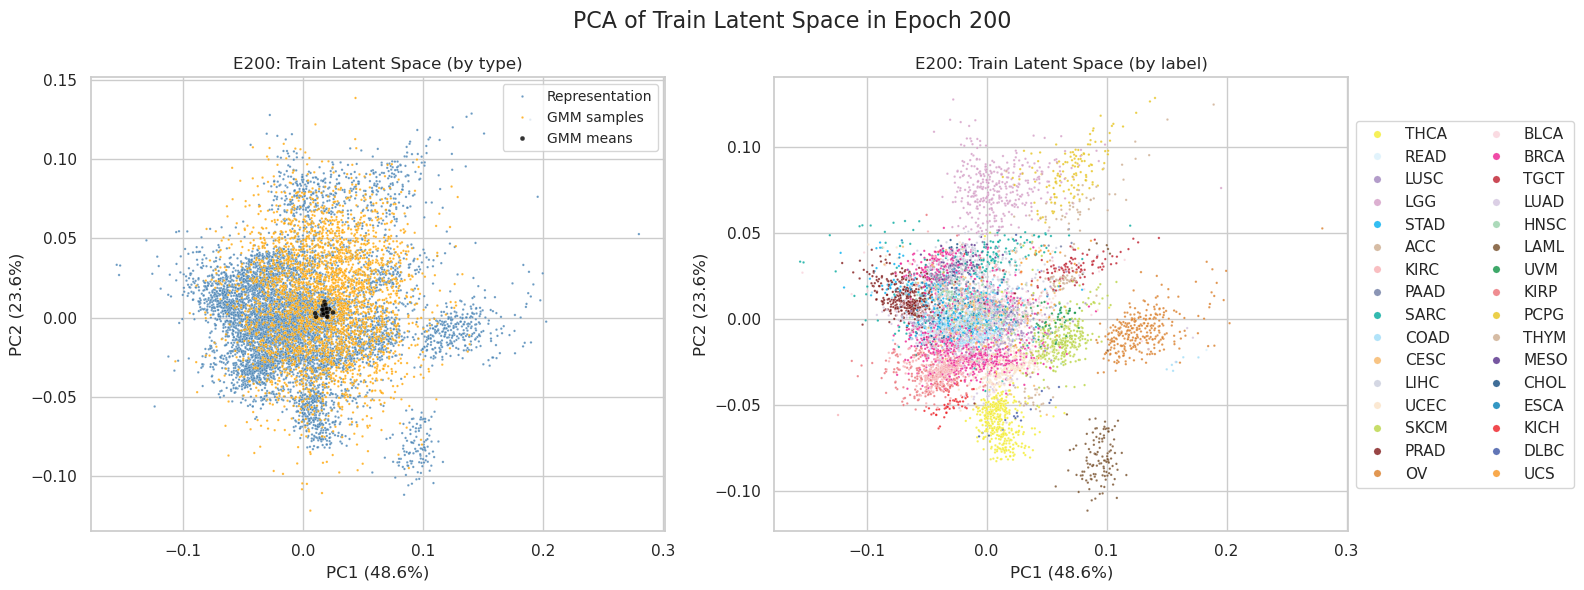

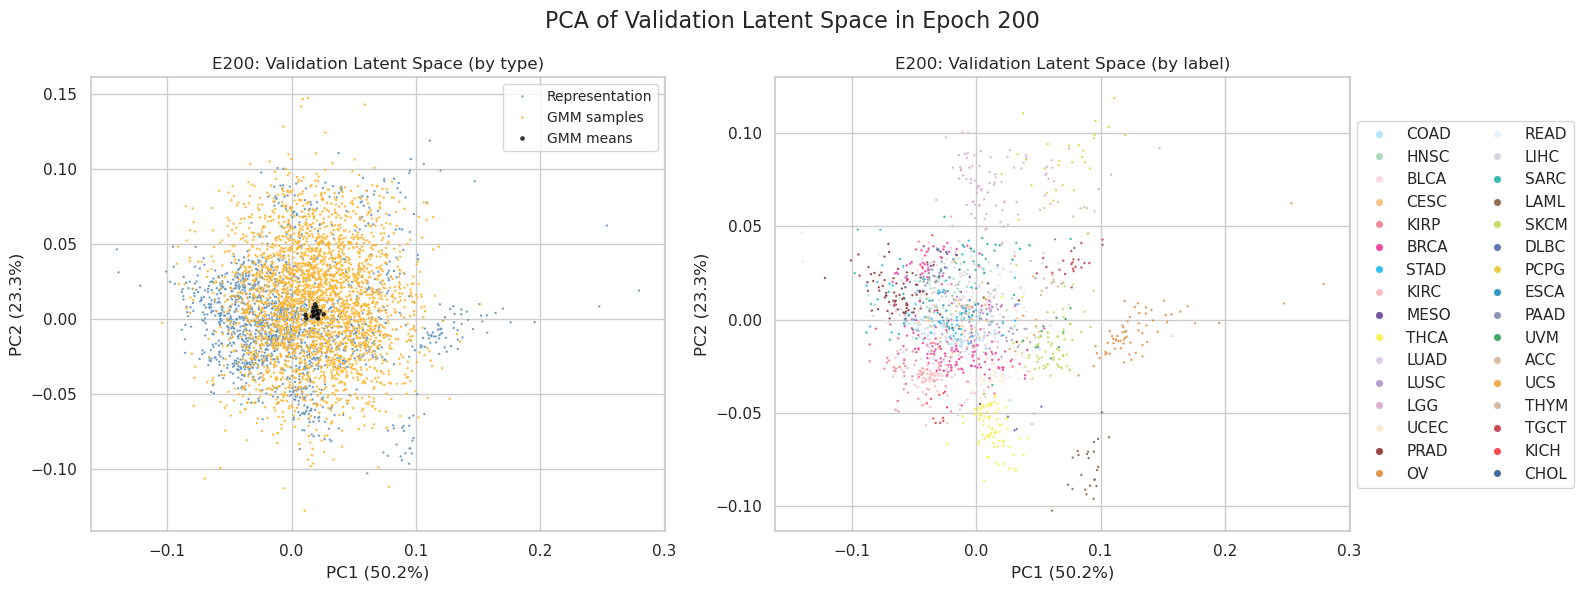

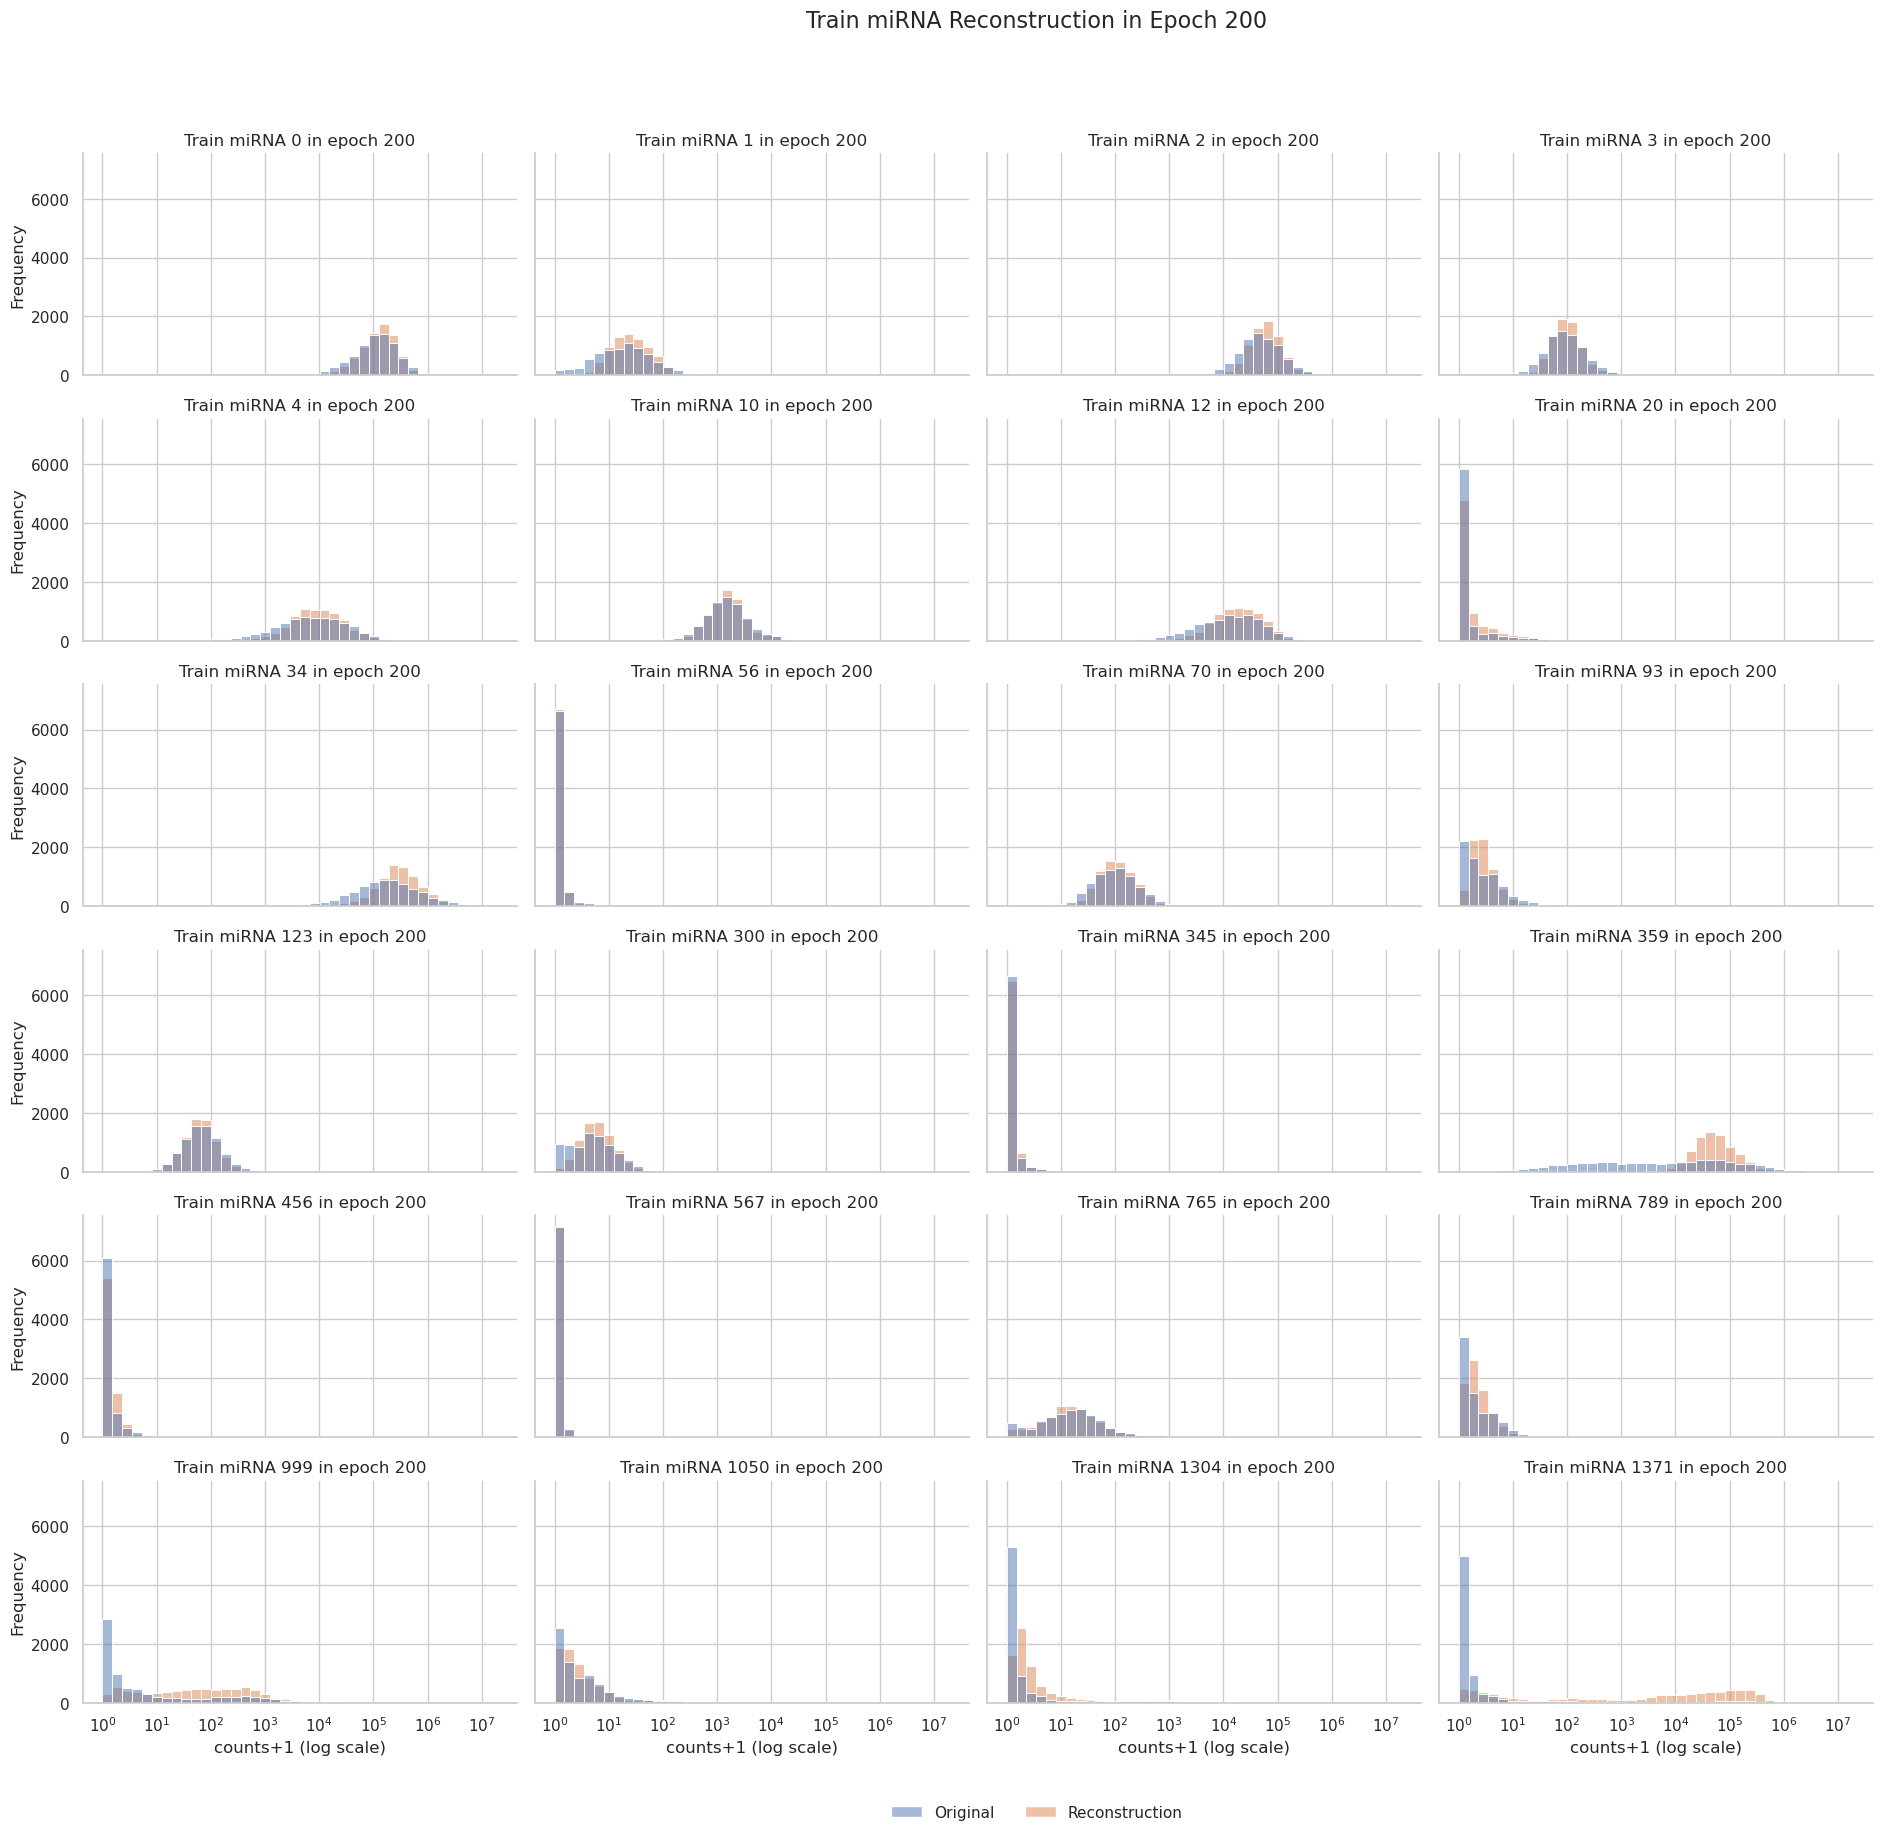

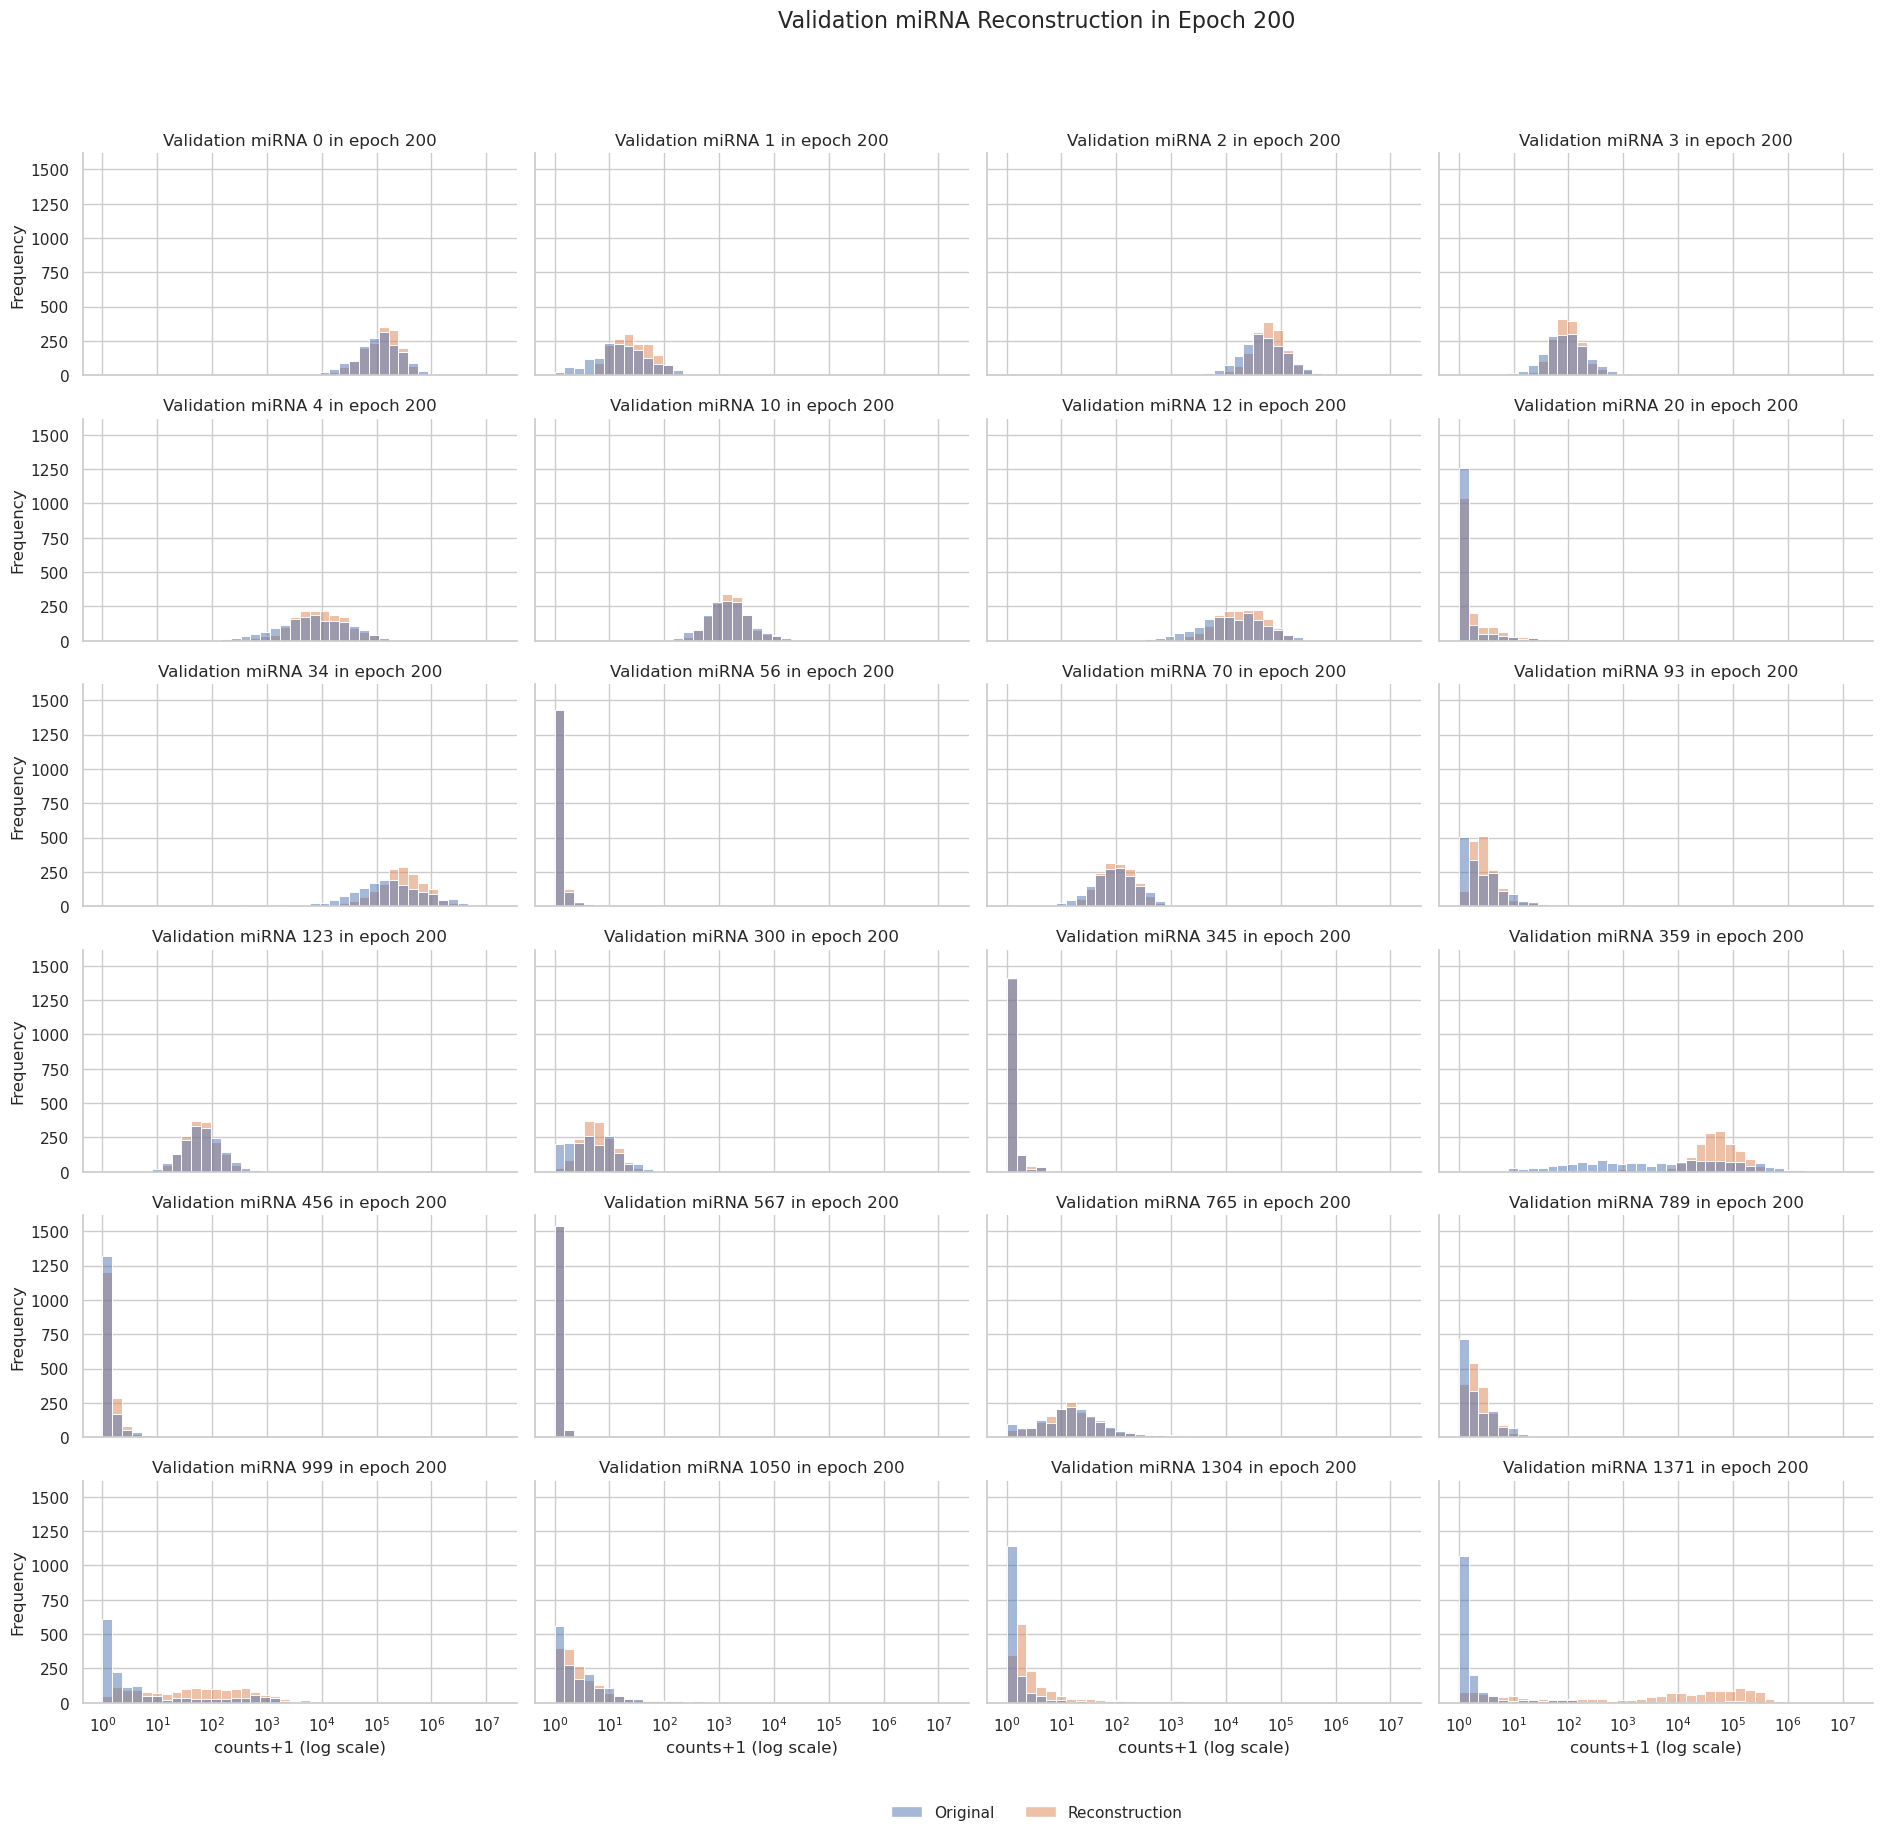

 34%|██████████████████████▉                                            | 206/601 [08:07<26:15,  3.99s/it]

205 train_loss: 3.2691723877656775 train_recon: 1.8509187040324748 train_gmm: 1.4182536837332027 train_mse: 0.3709382116794586 train_mae: 0.3789934515953064 train_r2: 0.1840897798538208 train_spearman: 0.3393609821796417 train_pearson: 0.4303019046783447 train_msle: 0.10978563874959946
205 test_loss: 3.2680893932328834 test_recon: 1.849757161408507 test_gmm: 1.4183322318243763 test_mse: 0.3674637973308563 test_mae: 0.3869871497154236 test_r2: 0.15435129404067993 test_spearman: 0.2694997787475586 test_pearson: 0.39324939250946045 test_msle: 0.11485617607831955


 35%|███████████████████████▌                                           | 211/601 [08:16<13:48,  2.12s/it]

210 train_loss: 3.266917977468993 train_recon: 1.8485485350192181 train_gmm: 1.418369442449775 train_mse: 0.4222128391265869 train_mae: 0.46728935837745667 train_r2: 0.07130688428878784 train_spearman: 0.33910655975341797 train_pearson: 0.4307557940483093 train_msle: 0.14532089233398438
210 test_loss: 3.2786643925336203 test_recon: 1.860214844762599 test_gmm: 1.4184495477710213 test_mse: 0.43443378806114197 test_mae: 0.48150670528411865 test_r2: 0.00023251771926879883 test_spearman: 0.2724739909172058 test_pearson: 0.38520804047584534 test_msle: 0.15436074137687683


 36%|████████████████████████                                           | 216/601 [08:25<11:54,  1.86s/it]

215 train_loss: 3.263712308037225 train_recon: 1.8452484733909003 train_gmm: 1.4184638346463245 train_mse: 0.3720255494117737 train_mae: 0.3676277995109558 train_r2: 0.18169814348220825 train_spearman: 0.34100279211997986 train_pearson: 0.4322391748428345 train_msle: 0.10761766880750656
215 test_loss: 3.2941359717351384 test_recon: 1.875603412547247 test_gmm: 1.4185325591878915 test_mse: 0.3723900318145752 test_mae: 0.36395692825317383 test_r2: 0.14301449060440063 test_spearman: 0.27011585235595703 test_pearson: 0.3878156542778015 test_msle: 0.11061619967222214


 37%|████████████████████████▋                                          | 221/601 [08:34<11:19,  1.79s/it]

220 train_loss: 3.2613713965136153 train_recon: 1.8428549598796113 train_gmm: 1.4185164366340037 train_mse: 0.4211709499359131 train_mae: 0.45638900995254517 train_r2: 0.07359862327575684 train_spearman: 0.341036856174469 train_pearson: 0.43152740597724915 train_msle: 0.14136481285095215
220 test_loss: 3.2535105318025304 test_recon: 1.8345040407906497 test_gmm: 1.4190064910118805 test_mse: 0.4119655191898346 test_mae: 0.450995534658432 test_r2: 0.05193895101547241 test_spearman: 0.2738761901855469 test_pearson: 0.3843187987804413 test_msle: 0.1409238576889038


 38%|█████████████████████████▏                                         | 226/601 [08:43<11:31,  1.84s/it]

225 train_loss: 3.2594232241124796 train_recon: 1.8408438661873787 train_gmm: 1.4185793579251007 train_mse: 0.3707659840583801 train_mae: 0.39608776569366455 train_r2: 0.18446862697601318 train_spearman: 0.3432794511318207 train_pearson: 0.4338656961917877 train_msle: 0.11483076959848404
225 test_loss: 3.261716298940635 test_recon: 1.8429914428250747 test_gmm: 1.4187248561155605 test_mse: 0.3695288896560669 test_mae: 0.3924582004547119 test_r2: 0.1495988368988037 test_spearman: 0.27355167269706726 test_pearson: 0.3912421762943268 test_msle: 0.11691565811634064


 38%|█████████████████████████▊                                         | 231/601 [08:52<10:57,  1.78s/it]

230 train_loss: 3.2575299645486986 train_recon: 1.838868229314597 train_gmm: 1.4186617352341018 train_mse: 0.3724112808704376 train_mae: 0.3698675036430359 train_r2: 0.18084973096847534 train_spearman: 0.3394790589809418 train_pearson: 0.4311646521091461 train_msle: 0.10792756080627441
230 test_loss: 3.2910397721977405 test_recon: 1.8723809995620944 test_gmm: 1.418658772635646 test_mse: 0.3667466640472412 test_mae: 0.37464967370033264 test_r2: 0.15600162744522095 test_spearman: 0.2720877230167389 test_pearson: 0.39716780185699463 test_msle: 0.11190018802881241


 39%|██████████████████████████▎                                        | 236/601 [09:02<11:12,  1.84s/it]

235 train_loss: 3.2546164888708797 train_recon: 1.835889962883178 train_gmm: 1.4187265259877018 train_mse: 0.372221440076828 train_mae: 0.36583617329597473 train_r2: 0.18126726150512695 train_spearman: 0.34226253628730774 train_pearson: 0.43292489647865295 train_msle: 0.10729376971721649
235 test_loss: 3.270701661860244 test_recon: 1.8520889646694383 test_gmm: 1.4186126971908053 test_mse: 0.36569759249687195 test_mae: 0.37796100974082947 test_r2: 0.15841585397720337 test_spearman: 0.27530354261398315 test_pearson: 0.39914339780807495 test_msle: 0.11289109289646149


 40%|██████████████████████████▊                                        | 241/601 [09:11<11:05,  1.85s/it]

240 train_loss: 3.2526803435189175 train_recon: 1.8339014347814848 train_gmm: 1.4187789087374327 train_mse: 0.3852789103984833 train_mae: 0.43178918957710266 train_r2: 0.152546226978302 train_spearman: 0.34330055117607117 train_pearson: 0.4371694326400757 train_msle: 0.12813854217529297
240 test_loss: 3.2521178226879908 test_recon: 1.8334287330145684 test_gmm: 1.418689089673422 test_mse: 0.4021492302417755 test_mae: 0.4530467092990875 test_r2: 0.07452929019927979 test_spearman: 0.2773323953151703 test_pearson: 0.3923301100730896 test_msle: 0.1401202529668808


 41%|███████████████████████████▍                                       | 246/601 [09:20<11:00,  1.86s/it]

245 train_loss: 3.2500429382381255 train_recon: 1.8311928624867706 train_gmm: 1.418850075751355 train_mse: 0.3678242862224579 train_mae: 0.37717509269714355 train_r2: 0.19093918800354004 train_spearman: 0.34572261571884155 train_pearson: 0.43828603625297546 train_msle: 0.10885956883430481
245 test_loss: 3.2465345628240456 test_recon: 1.8277431392851675 test_gmm: 1.418791423538878 test_mse: 0.3685237467288971 test_mae: 0.39856934547424316 test_r2: 0.15191203355789185 test_spearman: 0.27592936158180237 test_pearson: 0.3971914052963257 test_msle: 0.11846821755170822


 42%|███████████████████████████▉                                       | 251/601 [09:30<10:50,  1.86s/it]

250 train_loss: 3.248278334677164 train_recon: 1.8293609237160233 train_gmm: 1.4189174109611407 train_mse: 0.3962676227092743 train_mae: 0.4409855604171753 train_r2: 0.1283755898475647 train_spearman: 0.3444842994213104 train_pearson: 0.43648210167884827 train_msle: 0.1328830122947693
250 test_loss: 3.2507778566098984 test_recon: 1.831611961698531 test_gmm: 1.4191658949113675 test_mse: 0.4126577079296112 test_mae: 0.4594433605670929 test_r2: 0.05034595727920532 test_spearman: 0.27883660793304443 test_pearson: 0.39065855741500854 test_msle: 0.14365409314632416


 43%|████████████████████████████▌                                      | 256/601 [09:39<10:27,  1.82s/it]

255 train_loss: 3.2462623285335175 train_recon: 1.8272752387845255 train_gmm: 1.4189870897489918 train_mse: 0.39527428150177 train_mae: 0.4465976059436798 train_r2: 0.13056057691574097 train_spearman: 0.3468864858150482 train_pearson: 0.4423118531703949 train_msle: 0.13481669127941132
255 test_loss: 3.248240116581685 test_recon: 1.8290352541442108 test_gmm: 1.4192048624374745 test_mse: 0.39267498254776 test_mae: 0.44213083386421204 test_r2: 0.09633249044418335 test_spearman: 0.2800807058811188 test_pearson: 0.3962135910987854 test_msle: 0.13550250232219696


 43%|█████████████████████████████                                      | 261/601 [09:48<10:25,  1.84s/it]

260 train_loss: 3.2447828059130757 train_recon: 1.8257442103661454 train_gmm: 1.4190385955469305 train_mse: 0.38019055128097534 train_mae: 0.4229332208633423 train_r2: 0.16373854875564575 train_spearman: 0.3470284938812256 train_pearson: 0.44434577226638794 train_msle: 0.12510162591934204
260 test_loss: 3.2395677661949627 test_recon: 1.8204640378465904 test_gmm: 1.419103728348372 test_mse: 0.38873884081840515 test_mae: 0.434420645236969 test_r2: 0.10539078712463379 test_spearman: 0.28008824586868286 test_pearson: 0.39539507031440735 test_msle: 0.13212640583515167


 44%|█████████████████████████████▋                                     | 266/601 [09:57<10:05,  1.81s/it]

265 train_loss: 3.243425451608348 train_recon: 1.824337757560948 train_gmm: 1.4190876940473998 train_mse: 0.3684317469596863 train_mae: 0.3979758322238922 train_r2: 0.1896030306816101 train_spearman: 0.3469262719154358 train_pearson: 0.4435798227787018 train_msle: 0.1158209890127182
265 test_loss: 3.23485798954368 test_recon: 1.8157561566403038 test_gmm: 1.4191018329033764 test_mse: 0.3702428638935089 test_mae: 0.4036176800727844 test_r2: 0.1479557752609253 test_spearman: 0.2783783972263336 test_pearson: 0.40086129307746887 test_msle: 0.12095455825328827


 45%|██████████████████████████████▏                                    | 271/601 [10:06<10:16,  1.87s/it]

270 train_loss: 3.241679025169434 train_recon: 1.8225202688671311 train_gmm: 1.4191587563023027 train_mse: 0.41341301798820496 train_mae: 0.4614868760108948 train_r2: 0.0906628966331482 train_spearman: 0.3487200140953064 train_pearson: 0.45049160718917847 train_msle: 0.14283470809459686
270 test_loss: 3.2493002621128646 test_recon: 1.830051864933416 test_gmm: 1.4192483971794487 test_mse: 0.40859511494636536 test_mae: 0.4580332934856415 test_r2: 0.059695303440093994 test_spearman: 0.2812488079071045 test_pearson: 0.40086033940315247 test_msle: 0.14324736595153809


 46%|██████████████████████████████▊                                    | 276/601 [10:15<09:47,  1.81s/it]

275 train_loss: 3.239838642474238 train_recon: 1.8206410367755408 train_gmm: 1.419197605698697 train_mse: 0.38643550872802734 train_mae: 0.4339633584022522 train_r2: 0.15000218152999878 train_spearman: 0.34934043884277344 train_pearson: 0.4514441192150116 train_msle: 0.13004466891288757
275 test_loss: 3.233832492650583 test_recon: 1.8145413320139587 test_gmm: 1.4192911606366243 test_mse: 0.3816465437412262 test_mae: 0.4307720959186554 test_r2: 0.121712327003479 test_spearman: 0.28026947379112244 test_pearson: 0.40808242559432983 test_msle: 0.13086025416851044


 47%|███████████████████████████████▎                                   | 281/601 [10:25<09:35,  1.80s/it]

280 train_loss: 3.237906063577592 train_recon: 1.8186313314807483 train_gmm: 1.4192747320968433 train_mse: 0.3625795543193817 train_mae: 0.3765498995780945 train_r2: 0.20247536897659302 train_spearman: 0.3493399918079376 train_pearson: 0.4507286548614502 train_msle: 0.10844091325998306
280 test_loss: 3.240782286164908 test_recon: 1.8215946238825536 test_gmm: 1.4191876622823545 test_mse: 0.36126089096069336 test_mae: 0.38441741466522217 test_r2: 0.16862612962722778 test_spearman: 0.2761971354484558 test_pearson: 0.4113243520259857 test_msle: 0.11411052942276001


 48%|███████████████████████████████▉                                   | 286/601 [10:33<08:57,  1.71s/it]

285 train_loss: 3.236051992714856 train_recon: 1.816737234032636 train_gmm: 1.4193147586822201 train_mse: 0.37419137358665466 train_mae: 0.4183029532432556 train_r2: 0.17693418264389038 train_spearman: 0.3510952889919281 train_pearson: 0.45467308163642883 train_msle: 0.12337961792945862
285 test_loss: 3.2306850060713153 test_recon: 1.8110549489434098 test_gmm: 1.4196300571279057 test_mse: 0.3691580295562744 test_mae: 0.4157255291938782 test_r2: 0.15045231580734253 test_spearman: 0.27785491943359375 test_pearson: 0.41474446654319763 test_msle: 0.12469734251499176


 48%|████████████████████████████████▍                                  | 291/601 [10:42<09:03,  1.75s/it]

290 train_loss: 3.235221406156441 train_recon: 1.815825947389522 train_gmm: 1.419395458766919 train_mse: 0.36822572350502014 train_mae: 0.4077092707157135 train_r2: 0.19005614519119263 train_spearman: 0.35051417350769043 train_pearson: 0.45733577013015747 train_msle: 0.11935971677303314
290 test_loss: 3.2297112461910147 test_recon: 1.810389753393383 test_gmm: 1.4193214927976316 test_mse: 0.3713391125202179 test_mae: 0.4163478910923004 test_r2: 0.1454329490661621 test_spearman: 0.2781941890716553 test_pearson: 0.41523659229278564 test_msle: 0.12548775970935822


 49%|████████████████████████████████▉                                  | 296/601 [10:51<09:15,  1.82s/it]

295 train_loss: 3.2332528184246403 train_recon: 1.8137982755707107 train_gmm: 1.4194545428539298 train_mse: 0.3656873106956482 train_mae: 0.40831539034843445 train_r2: 0.19563961029052734 train_spearman: 0.35190093517303467 train_pearson: 0.4606533348560333 train_msle: 0.11883357912302017
295 test_loss: 3.228922553237912 test_recon: 1.8096218851298471 test_gmm: 1.419300668108065 test_mse: 0.3753463923931122 test_mae: 0.4271042048931122 test_r2: 0.13621097803115845 test_spearman: 0.28014516830444336 test_pearson: 0.41681215167045593 test_msle: 0.12885256111621857


 50%|█████████████████████████████████▍                                 | 300/601 [10:59<09:00,  1.80s/it]

300 train_loss: 3.231856591996774 train_recon: 1.8123459911875108 train_gmm: 1.4195106008092633 train_mse: 0.38261178135871887 train_mae: 0.43482303619384766 train_r2: 0.15841275453567505 train_spearman: 0.3529717028141022 train_pearson: 0.4614866077899933 train_msle: 0.12999044358730316
300 test_loss: 3.227237514034008 test_recon: 1.8075200093413701 test_gmm: 1.4197175046926378 test_mse: 0.3733272850513458 test_mae: 0.4254862070083618 test_r2: 0.14085757732391357 test_spearman: 0.28059330582618713 test_pearson: 0.42058926820755005 test_msle: 0.1287766993045807


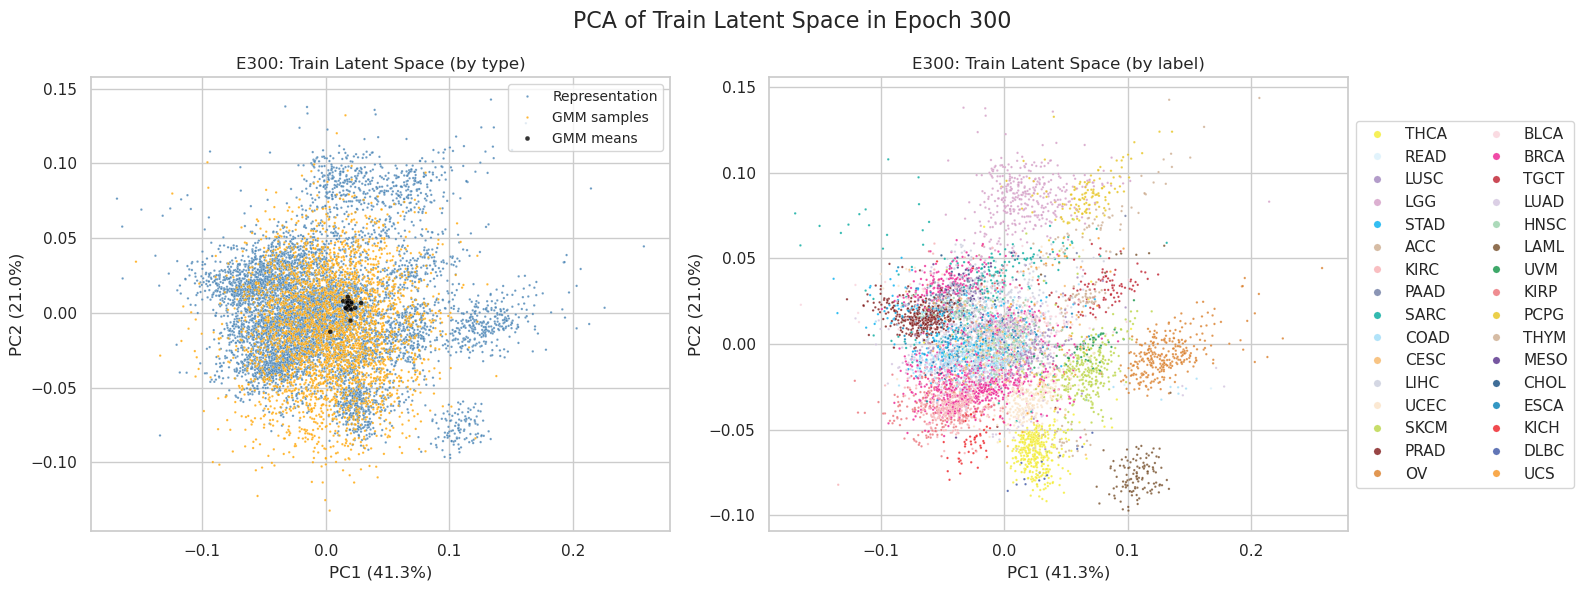

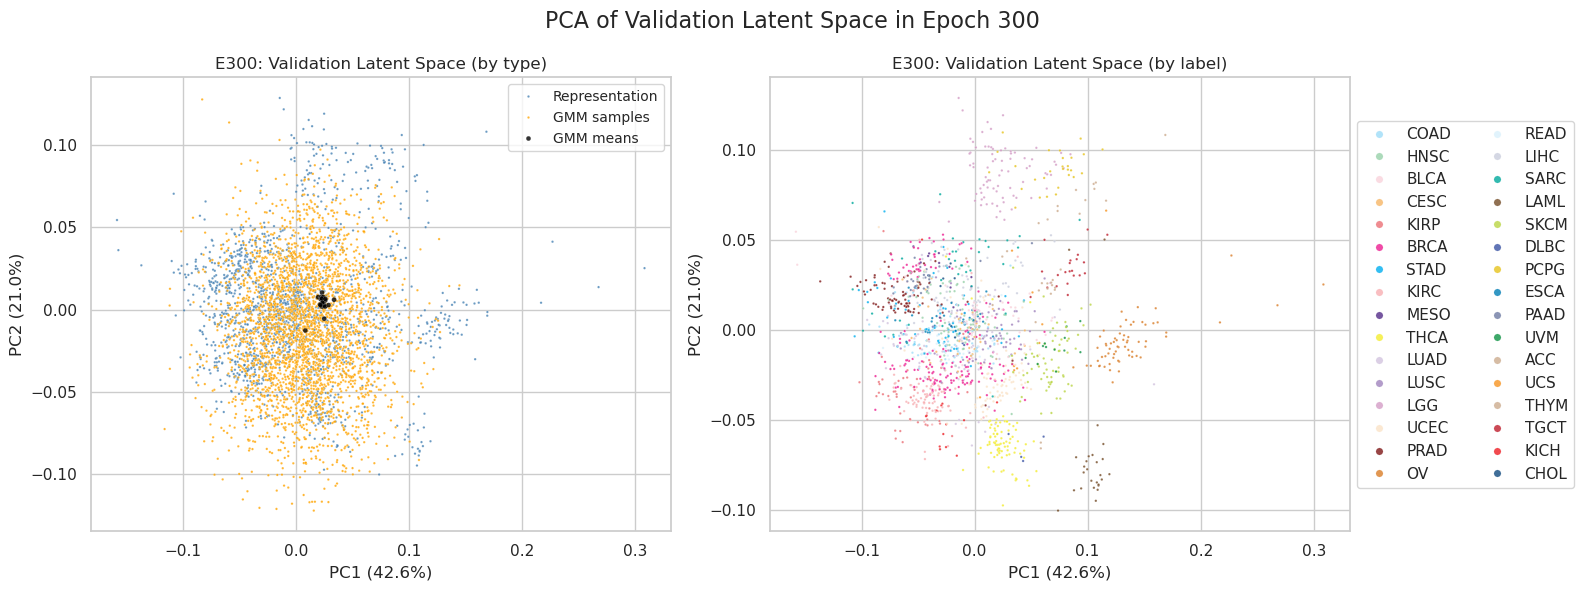

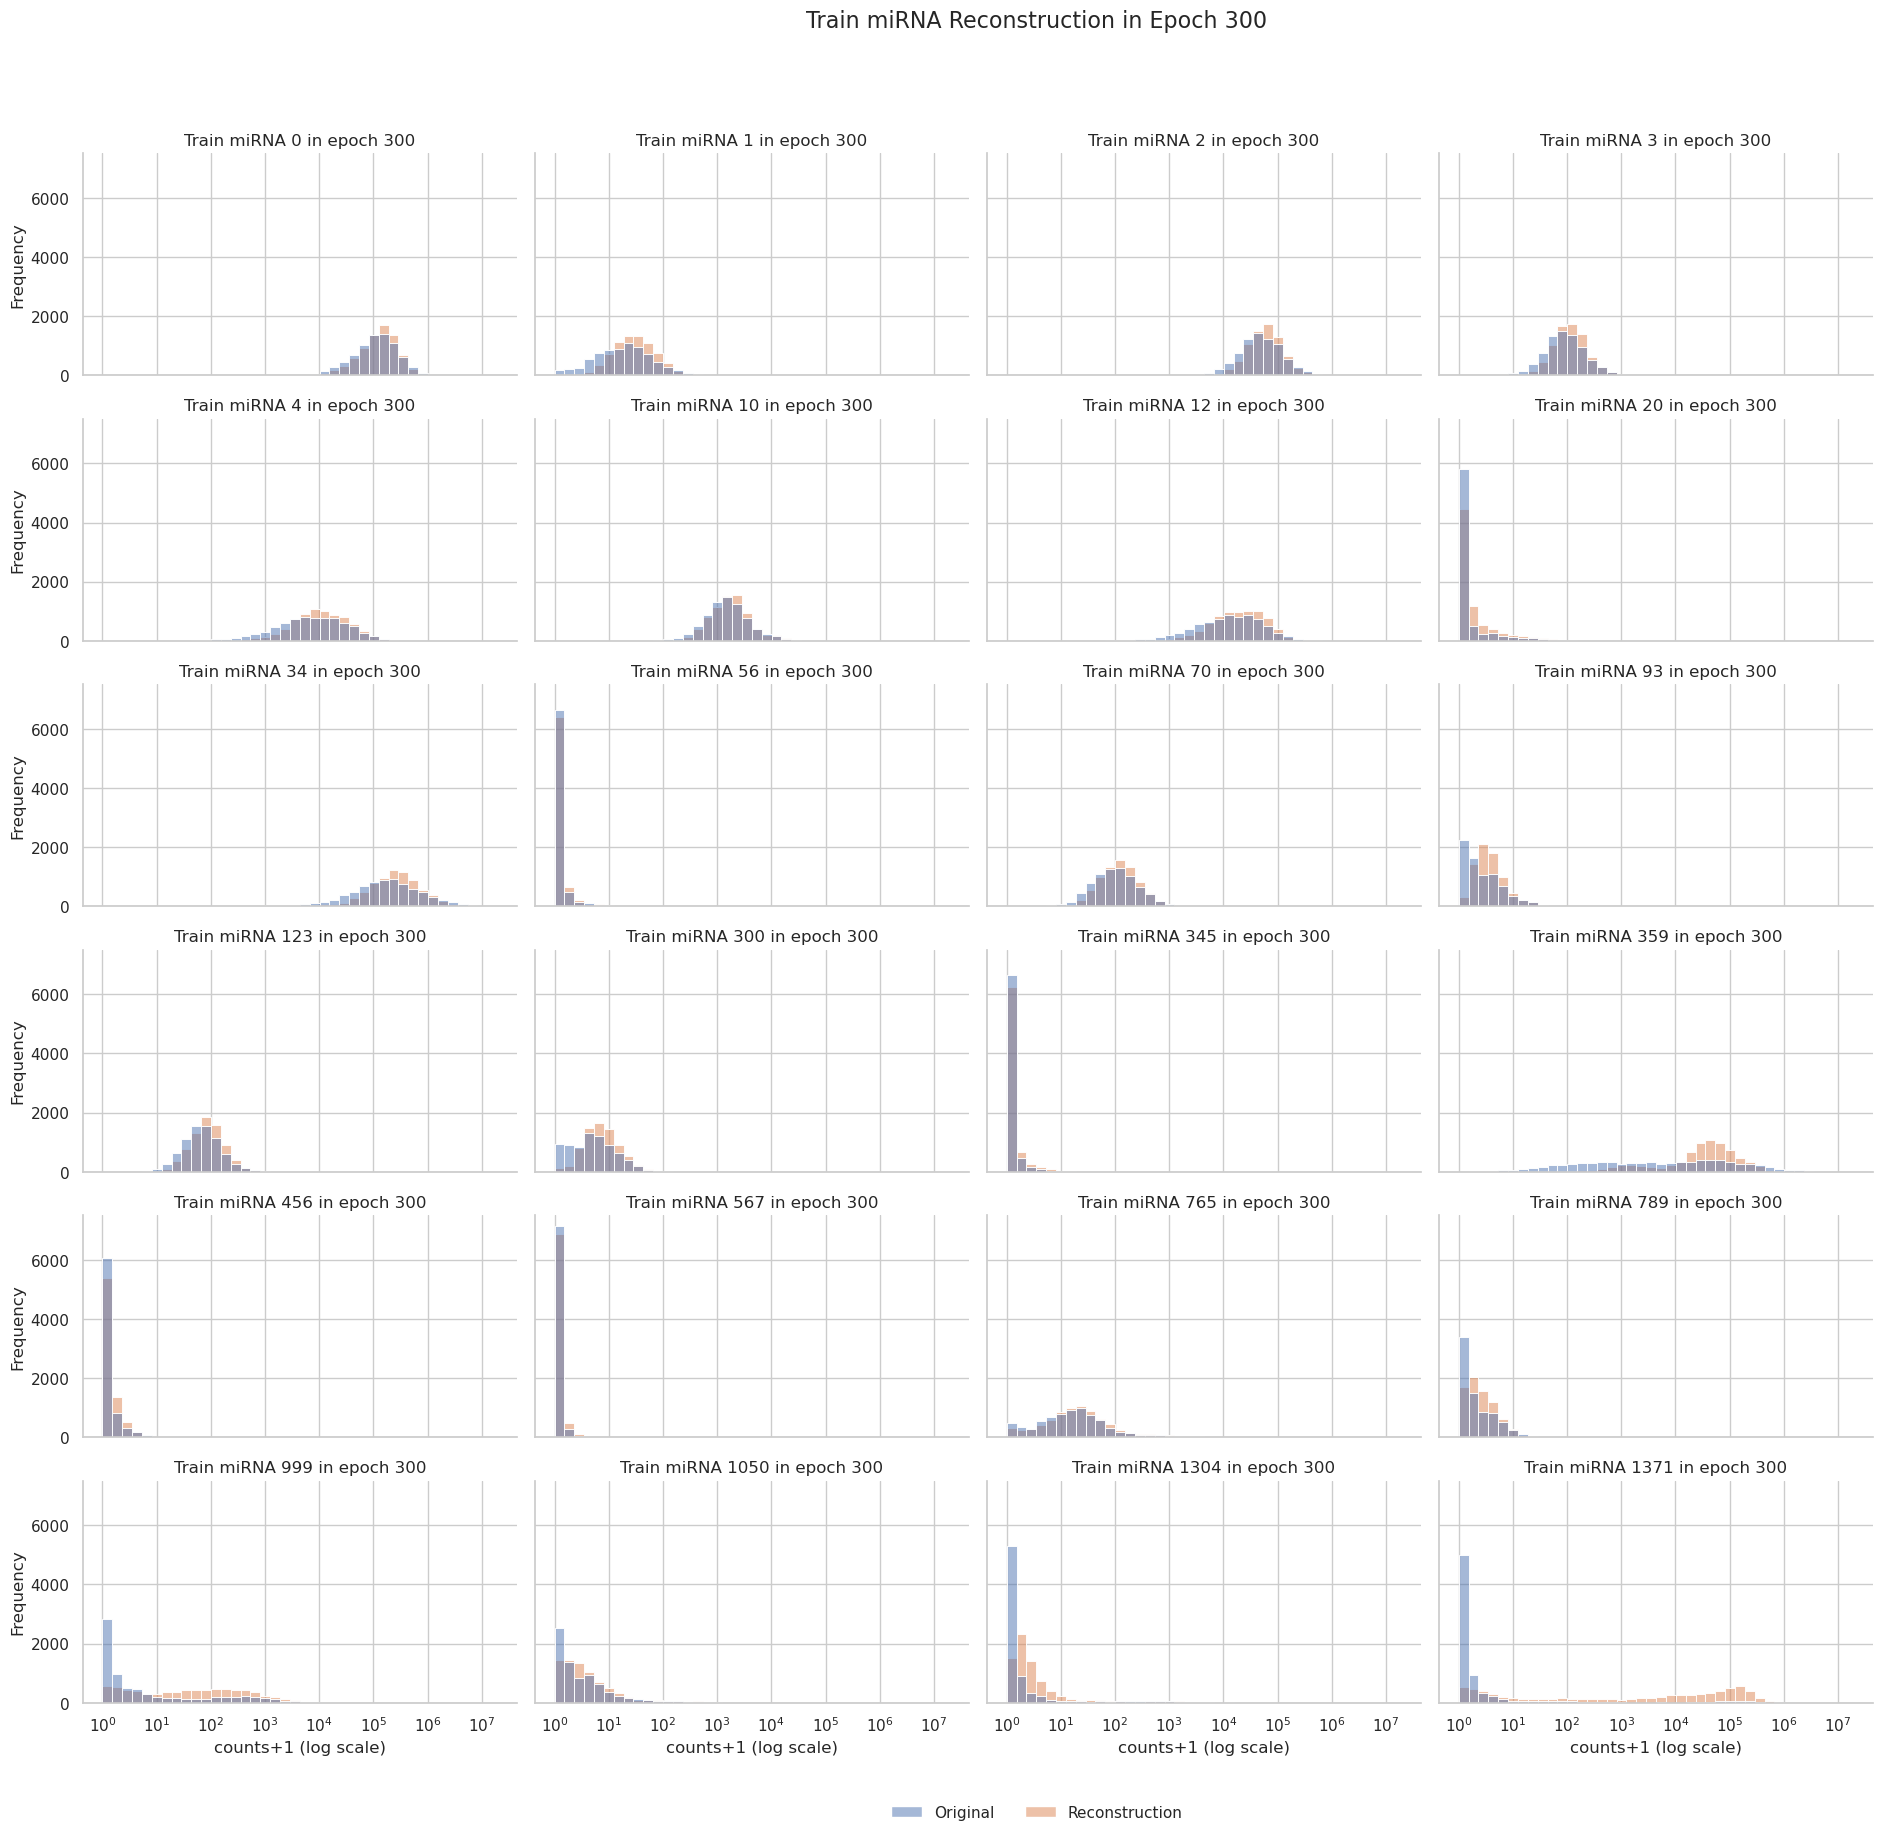

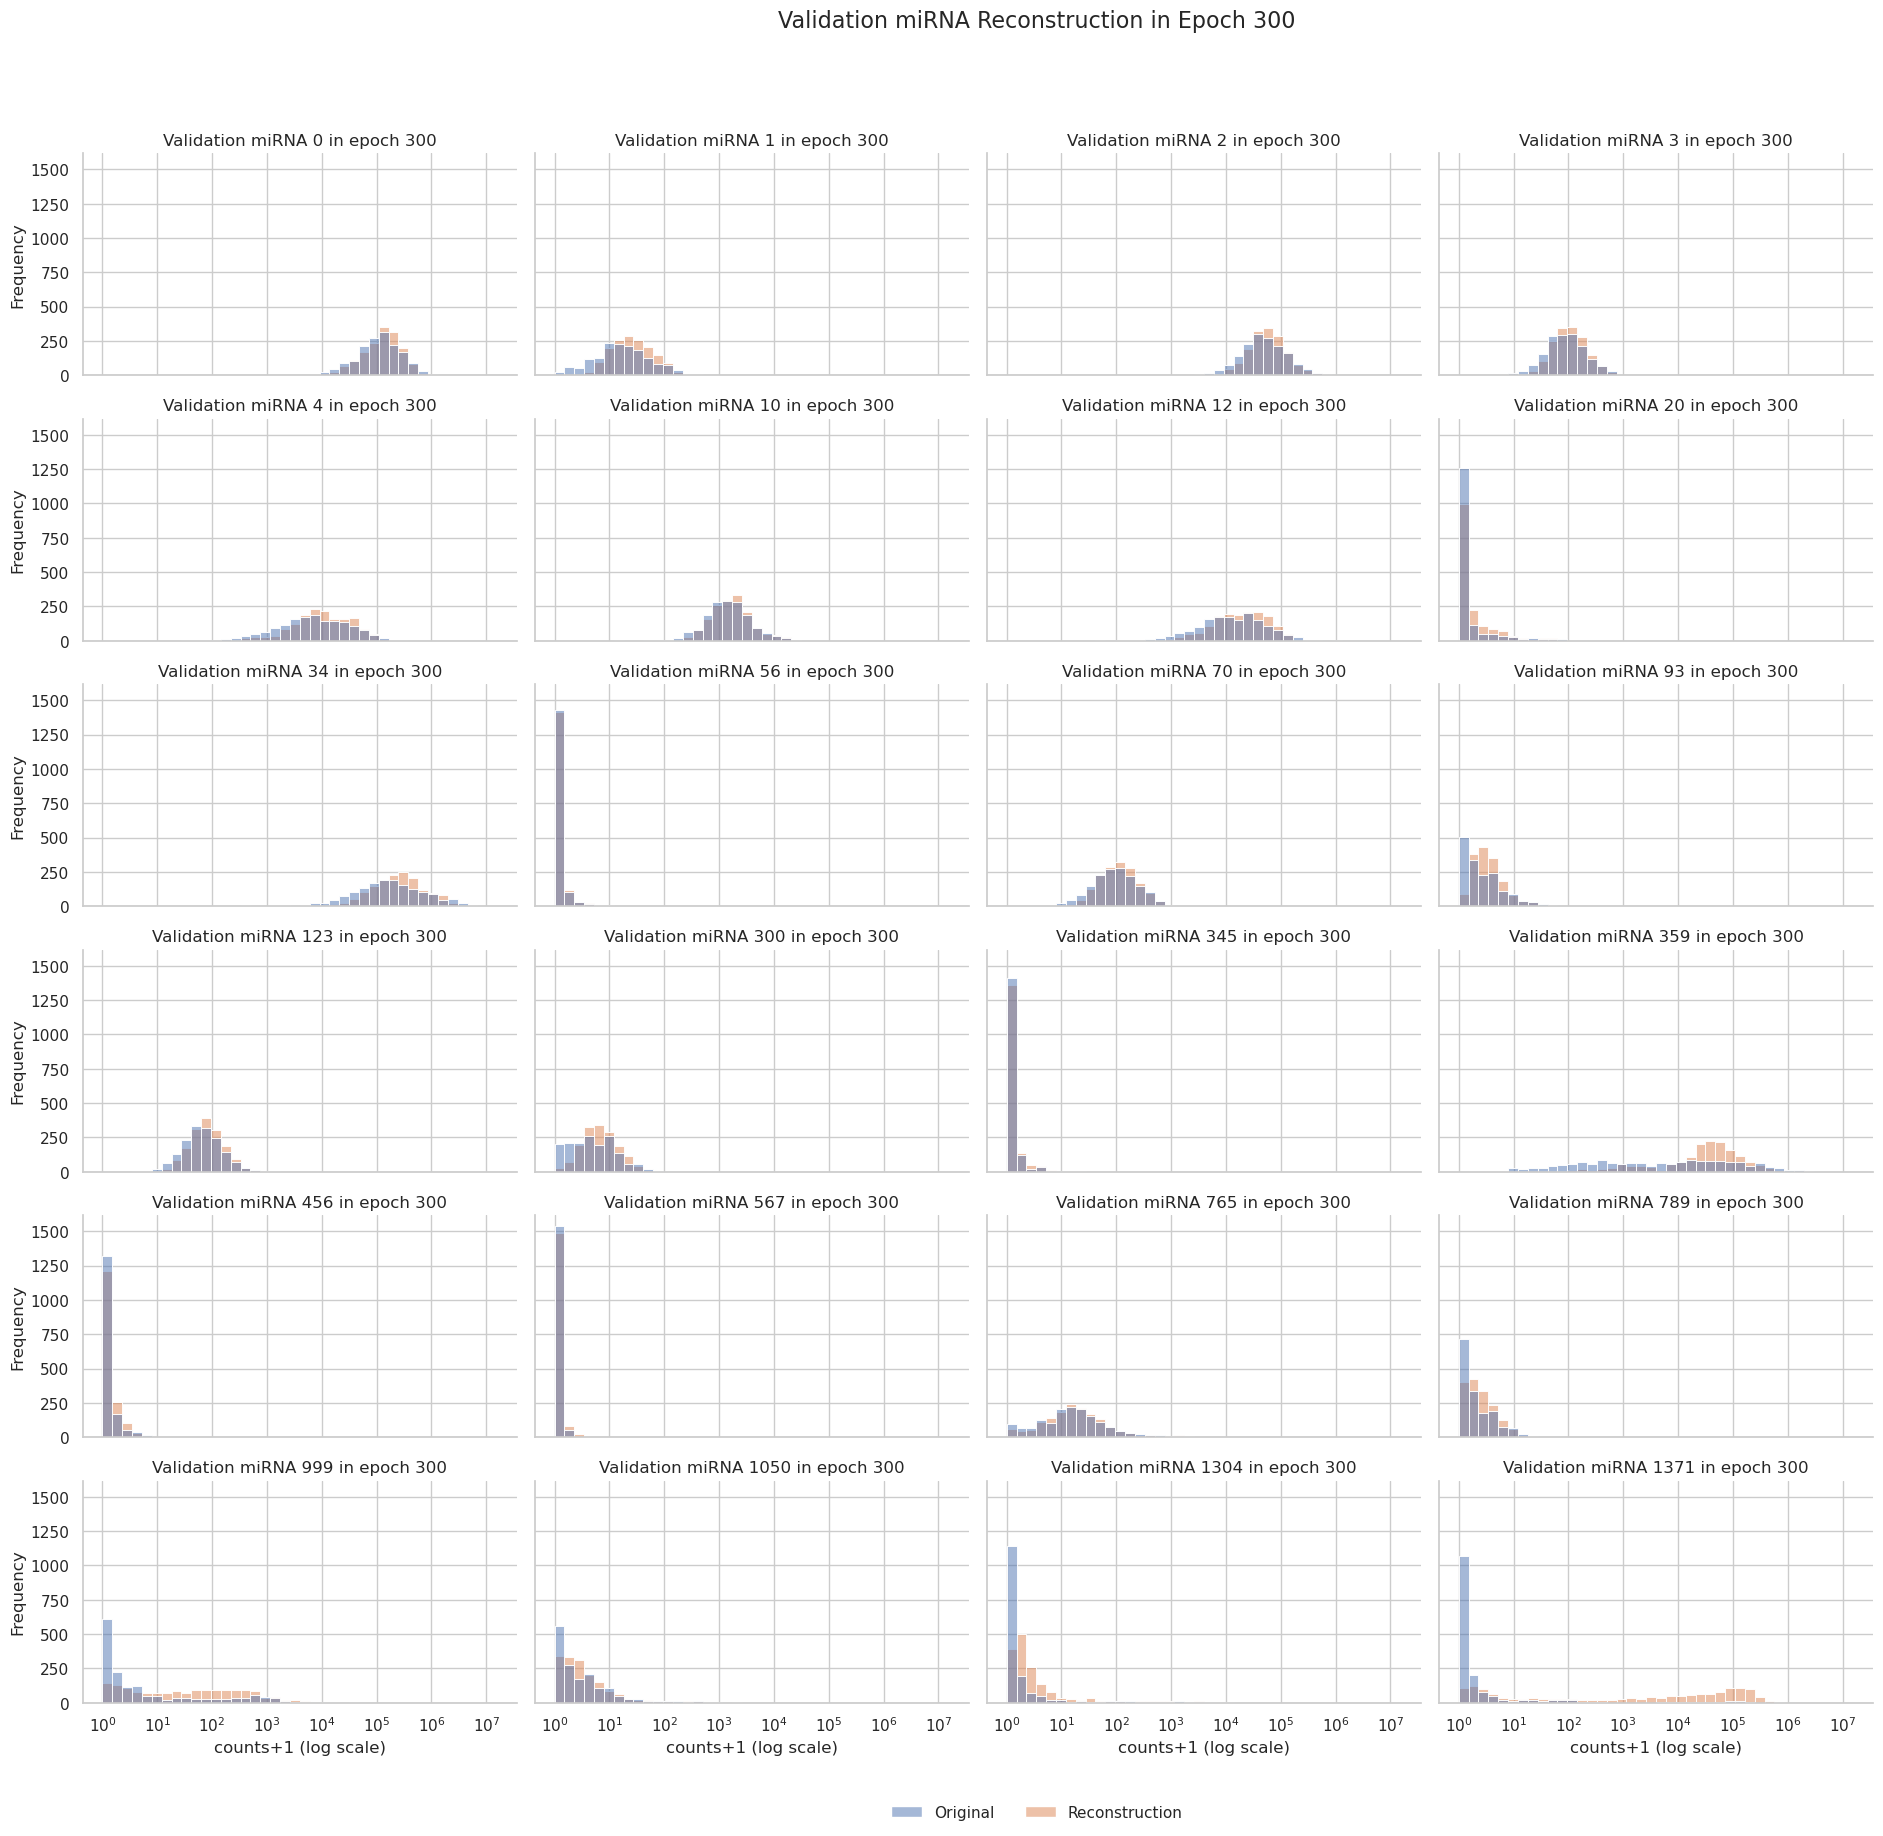

 51%|██████████████████████████████████                                 | 306/601 [11:54<19:58,  4.06s/it]

305 train_loss: 3.2305536555653385 train_recon: 1.8109696802428135 train_gmm: 1.4195839753225248 train_mse: 0.35718828439712524 train_mae: 0.3779376447200775 train_r2: 0.21433401107788086 train_spearman: 0.35305145382881165 train_pearson: 0.4630672037601471 train_msle: 0.10891183465719223
305 test_loss: 3.235026117794237 test_recon: 1.8153339848427243 test_gmm: 1.4196921329515126 test_mse: 0.35693055391311646 test_mae: 0.3847472667694092 test_r2: 0.1785915493965149 test_spearman: 0.2785010039806366 test_pearson: 0.4242030382156372 test_msle: 0.1144491583108902


 52%|██████████████████████████████████▋                                | 311/601 [12:03<11:00,  2.28s/it]

310 train_loss: 3.228560380297641 train_recon: 1.8089119058187868 train_gmm: 1.419648474478854 train_mse: 0.4158761501312256 train_mae: 0.460922509431839 train_r2: 0.08524501323699951 train_spearman: 0.35481488704681396 train_pearson: 0.464944064617157 train_msle: 0.14280232787132263
310 test_loss: 3.2297026575106726 test_recon: 1.8102228143986714 test_gmm: 1.4194798431120013 test_mse: 0.42547285556793213 test_mae: 0.47023525834083557 test_r2: 0.02085435390472412 test_spearman: 0.2798168957233429 test_pearson: 0.4131133258342743 test_msle: 0.15002036094665527


 53%|███████████████████████████████████▏                               | 316/601 [12:13<09:19,  1.96s/it]

315 train_loss: 3.2273273095392634 train_recon: 1.8076131219954419 train_gmm: 1.4197141875438217 train_mse: 0.3562980592250824 train_mae: 0.3656579554080963 train_r2: 0.21629208326339722 train_spearman: 0.35451582074165344 train_pearson: 0.4675995111465454 train_msle: 0.10587791353464127
315 test_loss: 3.2454466186018753 test_recon: 1.8254127006218939 test_gmm: 1.4200339179799815 test_mse: 0.3593278229236603 test_mae: 0.36989492177963257 test_r2: 0.17307472229003906 test_spearman: 0.27725231647491455 test_pearson: 0.41872096061706543 test_msle: 0.11144297569990158


 53%|███████████████████████████████████▊                               | 321/601 [12:22<09:15,  1.98s/it]

320 train_loss: 3.225515991109436 train_recon: 1.8057325686536088 train_gmm: 1.4197834224558272 train_mse: 0.35582706332206726 train_mae: 0.3854338228702545 train_r2: 0.21732807159423828 train_spearman: 0.35437238216400146 train_pearson: 0.4675300717353821 train_msle: 0.1106877475976944
320 test_loss: 3.2192064487110192 test_recon: 1.799344174365762 test_gmm: 1.419862274345257 test_mse: 0.3631218373775482 test_mae: 0.40880441665649414 test_r2: 0.1643434762954712 test_spearman: 0.28064653277397156 test_pearson: 0.42436158657073975 test_msle: 0.12210399657487869


 54%|████████████████████████████████████▎                              | 326/601 [12:32<08:45,  1.91s/it]

325 train_loss: 3.2237824010077736 train_recon: 1.8039359028222945 train_gmm: 1.4198464981854788 train_mse: 0.36710456013679504 train_mae: 0.40784138441085815 train_r2: 0.19252222776412964 train_spearman: 0.3532251715660095 train_pearson: 0.465686559677124 train_msle: 0.11985280364751816
325 test_loss: 3.2208862931945434 test_recon: 1.8010138005859726 test_gmm: 1.419872492608571 test_mse: 0.37405410408973694 test_mae: 0.4215124249458313 test_r2: 0.13918495178222656 test_spearman: 0.280263751745224 test_pearson: 0.4249238967895508 test_msle: 0.12865838408470154


 55%|████████████████████████████████████▉                              | 331/601 [12:41<08:41,  1.93s/it]

330 train_loss: 3.2215885332070586 train_recon: 1.8016654680581978 train_gmm: 1.419923065148861 train_mse: 0.35807257890701294 train_mae: 0.3587922751903534 train_r2: 0.21238887310028076 train_spearman: 0.35487690567970276 train_pearson: 0.467949241399765 train_msle: 0.10440529882907867
330 test_loss: 3.228150221210179 test_recon: 1.8084045772250792 test_gmm: 1.4197456439850997 test_mse: 0.35648033022880554 test_mae: 0.37688371539115906 test_r2: 0.1796276569366455 test_spearman: 0.2797226309776306 test_pearson: 0.4250623285770416 test_msle: 0.112947478890419


 56%|█████████████████████████████████████▍                             | 336/601 [12:51<08:26,  1.91s/it]

335 train_loss: 3.2201587349647074 train_recon: 1.8001655287923217 train_gmm: 1.419993206172386 train_mse: 0.3547801971435547 train_mae: 0.381310373544693 train_r2: 0.21963077783584595 train_spearman: 0.35703232884407043 train_pearson: 0.46944841742515564 train_msle: 0.10964299738407135
335 test_loss: 3.214447073997878 test_recon: 1.7944544978913253 test_gmm: 1.4199925761065528 test_mse: 0.36233848333358765 test_mae: 0.40563204884529114 test_r2: 0.16614621877670288 test_spearman: 0.2800751328468323 test_pearson: 0.4254201054573059 test_msle: 0.12163150310516357


 57%|██████████████████████████████████████                             | 341/601 [13:01<08:18,  1.92s/it]

340 train_loss: 3.218718823039622 train_recon: 1.7986431985186195 train_gmm: 1.4200756245210029 train_mse: 0.35564354062080383 train_mae: 0.3794543743133545 train_r2: 0.21773171424865723 train_spearman: 0.3560766577720642 train_pearson: 0.46692222356796265 train_msle: 0.10889194905757904
340 test_loss: 3.212351969252677 test_recon: 1.7924106054485462 test_gmm: 1.4199413638041307 test_mse: 0.3592317998409271 test_mae: 0.3993316888809204 test_r2: 0.17329567670822144 test_spearman: 0.2802210748195648 test_pearson: 0.425666481256485 test_msle: 0.11894384771585464


 58%|██████████████████████████████████████▌                            | 346/601 [13:10<07:53,  1.86s/it]

345 train_loss: 3.2166312981809977 train_recon: 1.7965127419018083 train_gmm: 1.4201185562791891 train_mse: 0.42384442687034607 train_mae: 0.4747108817100525 train_r2: 0.06771808862686157 train_spearman: 0.35804080963134766 train_pearson: 0.47488343715667725 train_msle: 0.14931514859199524
345 test_loss: 3.221134145422159 test_recon: 1.8009338920616562 test_gmm: 1.420200253360503 test_mse: 0.4163626432418823 test_mae: 0.4648655652999878 test_r2: 0.04181981086730957 test_spearman: 0.28180745244026184 test_pearson: 0.41692304611206055 test_msle: 0.14825014770030975


 58%|███████████████████████████████████████▏                           | 351/601 [13:20<08:05,  1.94s/it]

350 train_loss: 3.2148152370929495 train_recon: 1.7946101487836448 train_gmm: 1.4202050883093047 train_mse: 0.35441920161247253 train_mae: 0.3923306465148926 train_r2: 0.2204248309135437 train_spearman: 0.35756832361221313 train_pearson: 0.47728973627090454 train_msle: 0.11330972611904144
350 test_loss: 3.2112221157071366 test_recon: 1.7910331140307565 test_gmm: 1.4201890016763798 test_mse: 0.3715987205505371 test_mae: 0.41763755679130554 test_r2: 0.14483559131622314 test_spearman: 0.28280848264694214 test_pearson: 0.4233274757862091 test_msle: 0.12669600546360016


 59%|███████████████████████████████████████▋                           | 356/601 [13:30<07:56,  1.95s/it]

355 train_loss: 3.2138004528115505 train_recon: 1.7935460640436665 train_gmm: 1.420254388767884 train_mse: 0.39084523916244507 train_mae: 0.4474000036716461 train_r2: 0.1403025984764099 train_spearman: 0.35794538259506226 train_pearson: 0.47700247168540955 train_msle: 0.13566887378692627
355 test_loss: 3.2197959101869356 test_recon: 1.7993862454419545 test_gmm: 1.420409664744981 test_mse: 0.3808474838733673 test_mae: 0.4348829686641693 test_r2: 0.12355118989944458 test_spearman: 0.28202152252197266 test_pearson: 0.42519599199295044 test_msle: 0.13389529287815094


 60%|████████████████████████████████████████▏                          | 361/601 [13:39<07:40,  1.92s/it]

360 train_loss: 3.211205173381705 train_recon: 1.7908623258817382 train_gmm: 1.4203428474999669 train_mse: 0.38657939434051514 train_mae: 0.4416777193546295 train_r2: 0.14968568086624146 train_spearman: 0.3584289848804474 train_pearson: 0.47512853145599365 train_msle: 0.13303746283054352
360 test_loss: 3.217515563611078 test_recon: 1.7970627069173664 test_gmm: 1.4204528566937116 test_mse: 0.3939606249332428 test_mae: 0.44809696078300476 test_r2: 0.09337377548217773 test_spearman: 0.28429144620895386 test_pearson: 0.42302095890045166 test_msle: 0.13945020735263824


 61%|████████████████████████████████████████▊                          | 366/601 [13:49<07:24,  1.89s/it]

365 train_loss: 3.2101531359289717 train_recon: 1.7897432610163386 train_gmm: 1.420409874912633 train_mse: 0.3518998324871063 train_mae: 0.3750777244567871 train_r2: 0.22596633434295654 train_spearman: 0.3571663796901703 train_pearson: 0.47632336616516113 train_msle: 0.10690426081418991
365 test_loss: 3.206633644905448 test_recon: 1.7863514639596547 test_gmm: 1.4202821809457933 test_mse: 0.35700976848602295 test_mae: 0.3957531750202179 test_r2: 0.17840921878814697 test_spearman: 0.2819054424762726 test_pearson: 0.42935892939567566 test_msle: 0.11800230294466019


 62%|█████████████████████████████████████████▎                         | 371/601 [13:58<07:15,  1.89s/it]

370 train_loss: 3.2083811221817125 train_recon: 1.787915797348055 train_gmm: 1.4204653248336574 train_mse: 0.35349464416503906 train_mae: 0.39039766788482666 train_r2: 0.22245842218399048 train_spearman: 0.36011824011802673 train_pearson: 0.475715696811676 train_msle: 0.11152345687150955
370 test_loss: 3.2074589286263855 test_recon: 1.7871180544197303 test_gmm: 1.4203408742066554 test_mse: 0.36024051904678345 test_mae: 0.4075264632701874 test_r2: 0.1709742546081543 test_spearman: 0.28183412551879883 test_pearson: 0.4293196201324463 test_msle: 0.12173201888799667


 63%|█████████████████████████████████████████▉                         | 376/601 [14:08<07:06,  1.90s/it]

375 train_loss: 3.2068223414509025 train_recon: 1.7862851162901863 train_gmm: 1.4205372251607162 train_mse: 0.4592483937740326 train_mae: 0.4992699921131134 train_r2: -0.010155916213989258 train_spearman: 0.35949742794036865 train_pearson: 0.4794602692127228 train_msle: 0.1614985167980194
375 test_loss: 3.2449429095737163 test_recon: 1.8244077925836248 test_gmm: 1.4205351169900915 test_mse: 0.44696515798568726 test_mae: 0.4850102365016937 test_r2: -0.028606176376342773 test_spearman: 0.2835872173309326 test_pearson: 0.42323121428489685 test_msle: 0.15927007794380188


 63%|██████████████████████████████████████████▍                        | 381/601 [14:17<06:44,  1.84s/it]

380 train_loss: 3.2049461873305045 train_recon: 1.7843546343582615 train_gmm: 1.4205915529722428 train_mse: 0.3551866114139557 train_mae: 0.396893709897995 train_r2: 0.21873682737350464 train_spearman: 0.3592216372489929 train_pearson: 0.4768213927745819 train_msle: 0.11420921236276627
380 test_loss: 3.201664446973746 test_recon: 1.7812101132444396 test_gmm: 1.4204543337293065 test_mse: 0.3628382980823517 test_mae: 0.4095096290111542 test_r2: 0.1649959683418274 test_spearman: 0.2857713997364044 test_pearson: 0.42901191115379333 test_msle: 0.12264706194400787


 64%|███████████████████████████████████████████                        | 386/601 [14:26<06:36,  1.84s/it]

385 train_loss: 3.204427881821512 train_recon: 1.783774800745133 train_gmm: 1.420653081076379 train_mse: 0.3574847877025604 train_mae: 0.35404786467552185 train_r2: 0.21368175745010376 train_spearman: 0.3585769534111023 train_pearson: 0.47741493582725525 train_msle: 0.10286755114793777
385 test_loss: 3.2147708349838844 test_recon: 1.7943607215830397 test_gmm: 1.4204101134008444 test_mse: 0.3543451726436615 test_mae: 0.3788236975669861 test_r2: 0.18454134464263916 test_spearman: 0.2802714407444 test_pearson: 0.43091699481010437 test_msle: 0.11344987154006958


 65%|███████████████████████████████████████████▌                       | 391/601 [14:36<06:49,  1.95s/it]

390 train_loss: 3.2023669099700203 train_recon: 1.7816859392346704 train_gmm: 1.4206809707353498 train_mse: 0.3506873846054077 train_mae: 0.3803824484348297 train_r2: 0.22863322496414185 train_spearman: 0.35860055685043335 train_pearson: 0.4788193702697754 train_msle: 0.1087827980518341
390 test_loss: 3.201286783503556 test_recon: 1.7806853410618486 test_gmm: 1.4206014424417075 test_mse: 0.35752466320991516 test_mae: 0.39913836121559143 test_r2: 0.17722433805465698 test_spearman: 0.2817865312099457 test_pearson: 0.43345487117767334 test_msle: 0.11921686679124832


 66%|████████████████████████████████████████████▏                      | 396/601 [14:46<06:38,  1.95s/it]

395 train_loss: 3.201605869689392 train_recon: 1.7808528625482567 train_gmm: 1.4207530071411352 train_mse: 0.35274675488471985 train_mae: 0.39118891954421997 train_r2: 0.22410345077514648 train_spearman: 0.36043351888656616 train_pearson: 0.4785778522491455 train_msle: 0.11196880787611008
395 test_loss: 3.1990487587426832 test_recon: 1.7782682673239676 test_gmm: 1.4207804914187157 test_mse: 0.36003249883651733 test_mae: 0.4001859724521637 test_r2: 0.171453058719635 test_spearman: 0.28066930174827576 test_pearson: 0.42686060070991516 test_msle: 0.1198415532708168


 67%|████████████████████████████████████████████▌                      | 400/601 [14:53<06:30,  1.94s/it]

400 train_loss: 3.200118244656088 train_recon: 1.7793244074170969 train_gmm: 1.4207938372389914 train_mse: 0.3705044984817505 train_mae: 0.42223551869392395 train_r2: 0.1850438117980957 train_spearman: 0.3617304563522339 train_pearson: 0.4810650944709778 train_msle: 0.12483994662761688
400 test_loss: 3.1993600573093497 test_recon: 1.7784278143462091 test_gmm: 1.4209322429631404 test_mse: 0.36869627237319946 test_mae: 0.41258180141448975 test_r2: 0.1515149474143982 test_spearman: 0.2825310528278351 test_pearson: 0.4243133068084717 test_msle: 0.12494400143623352


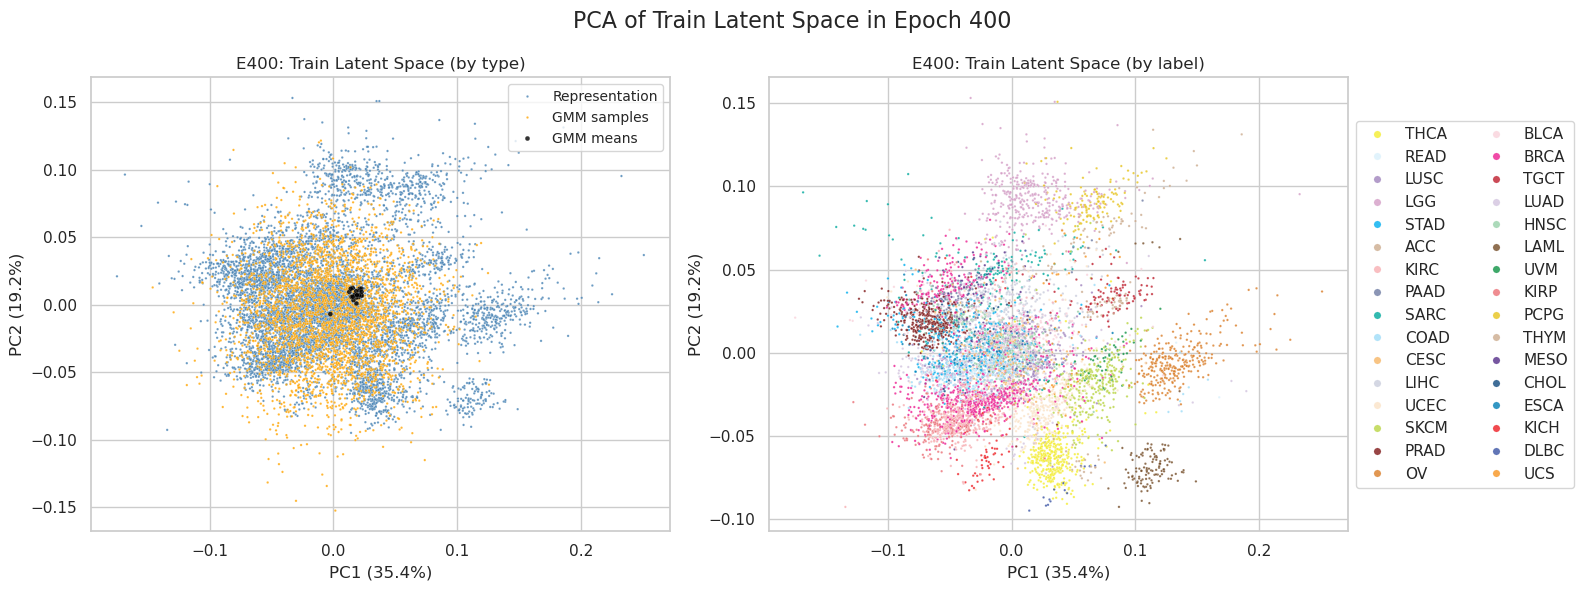

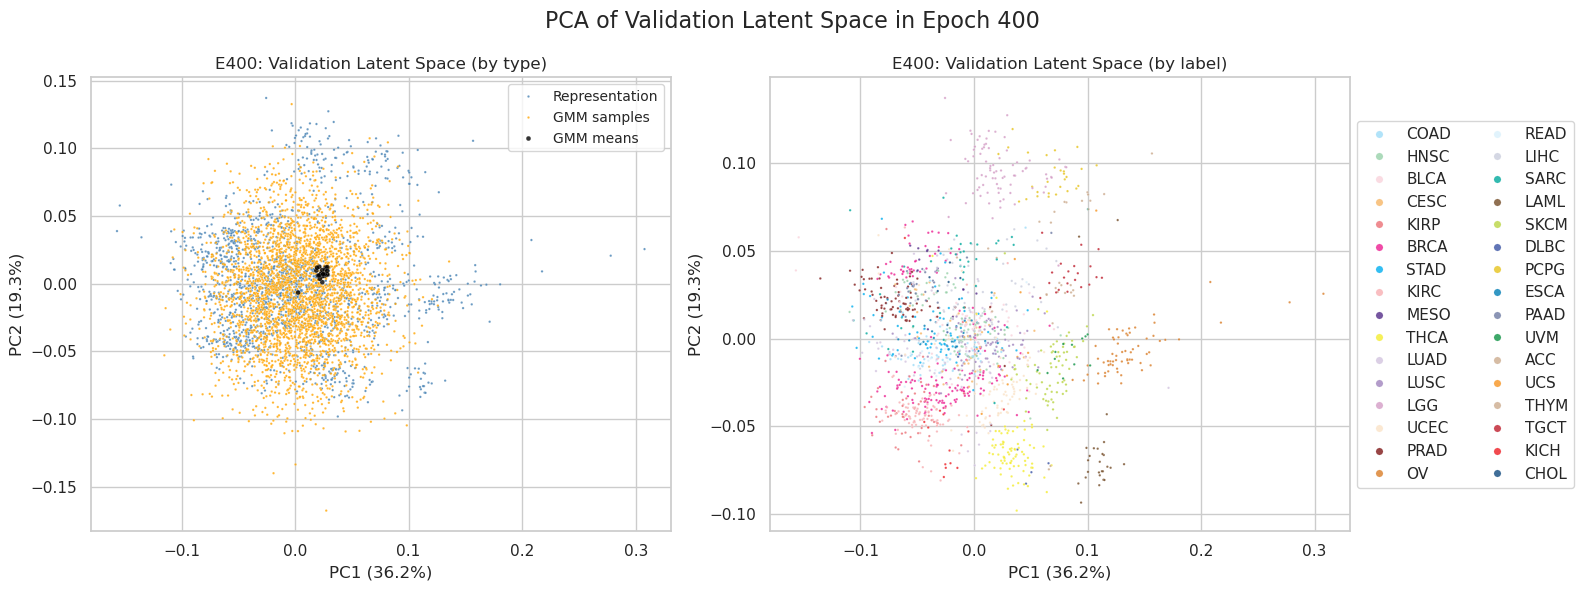

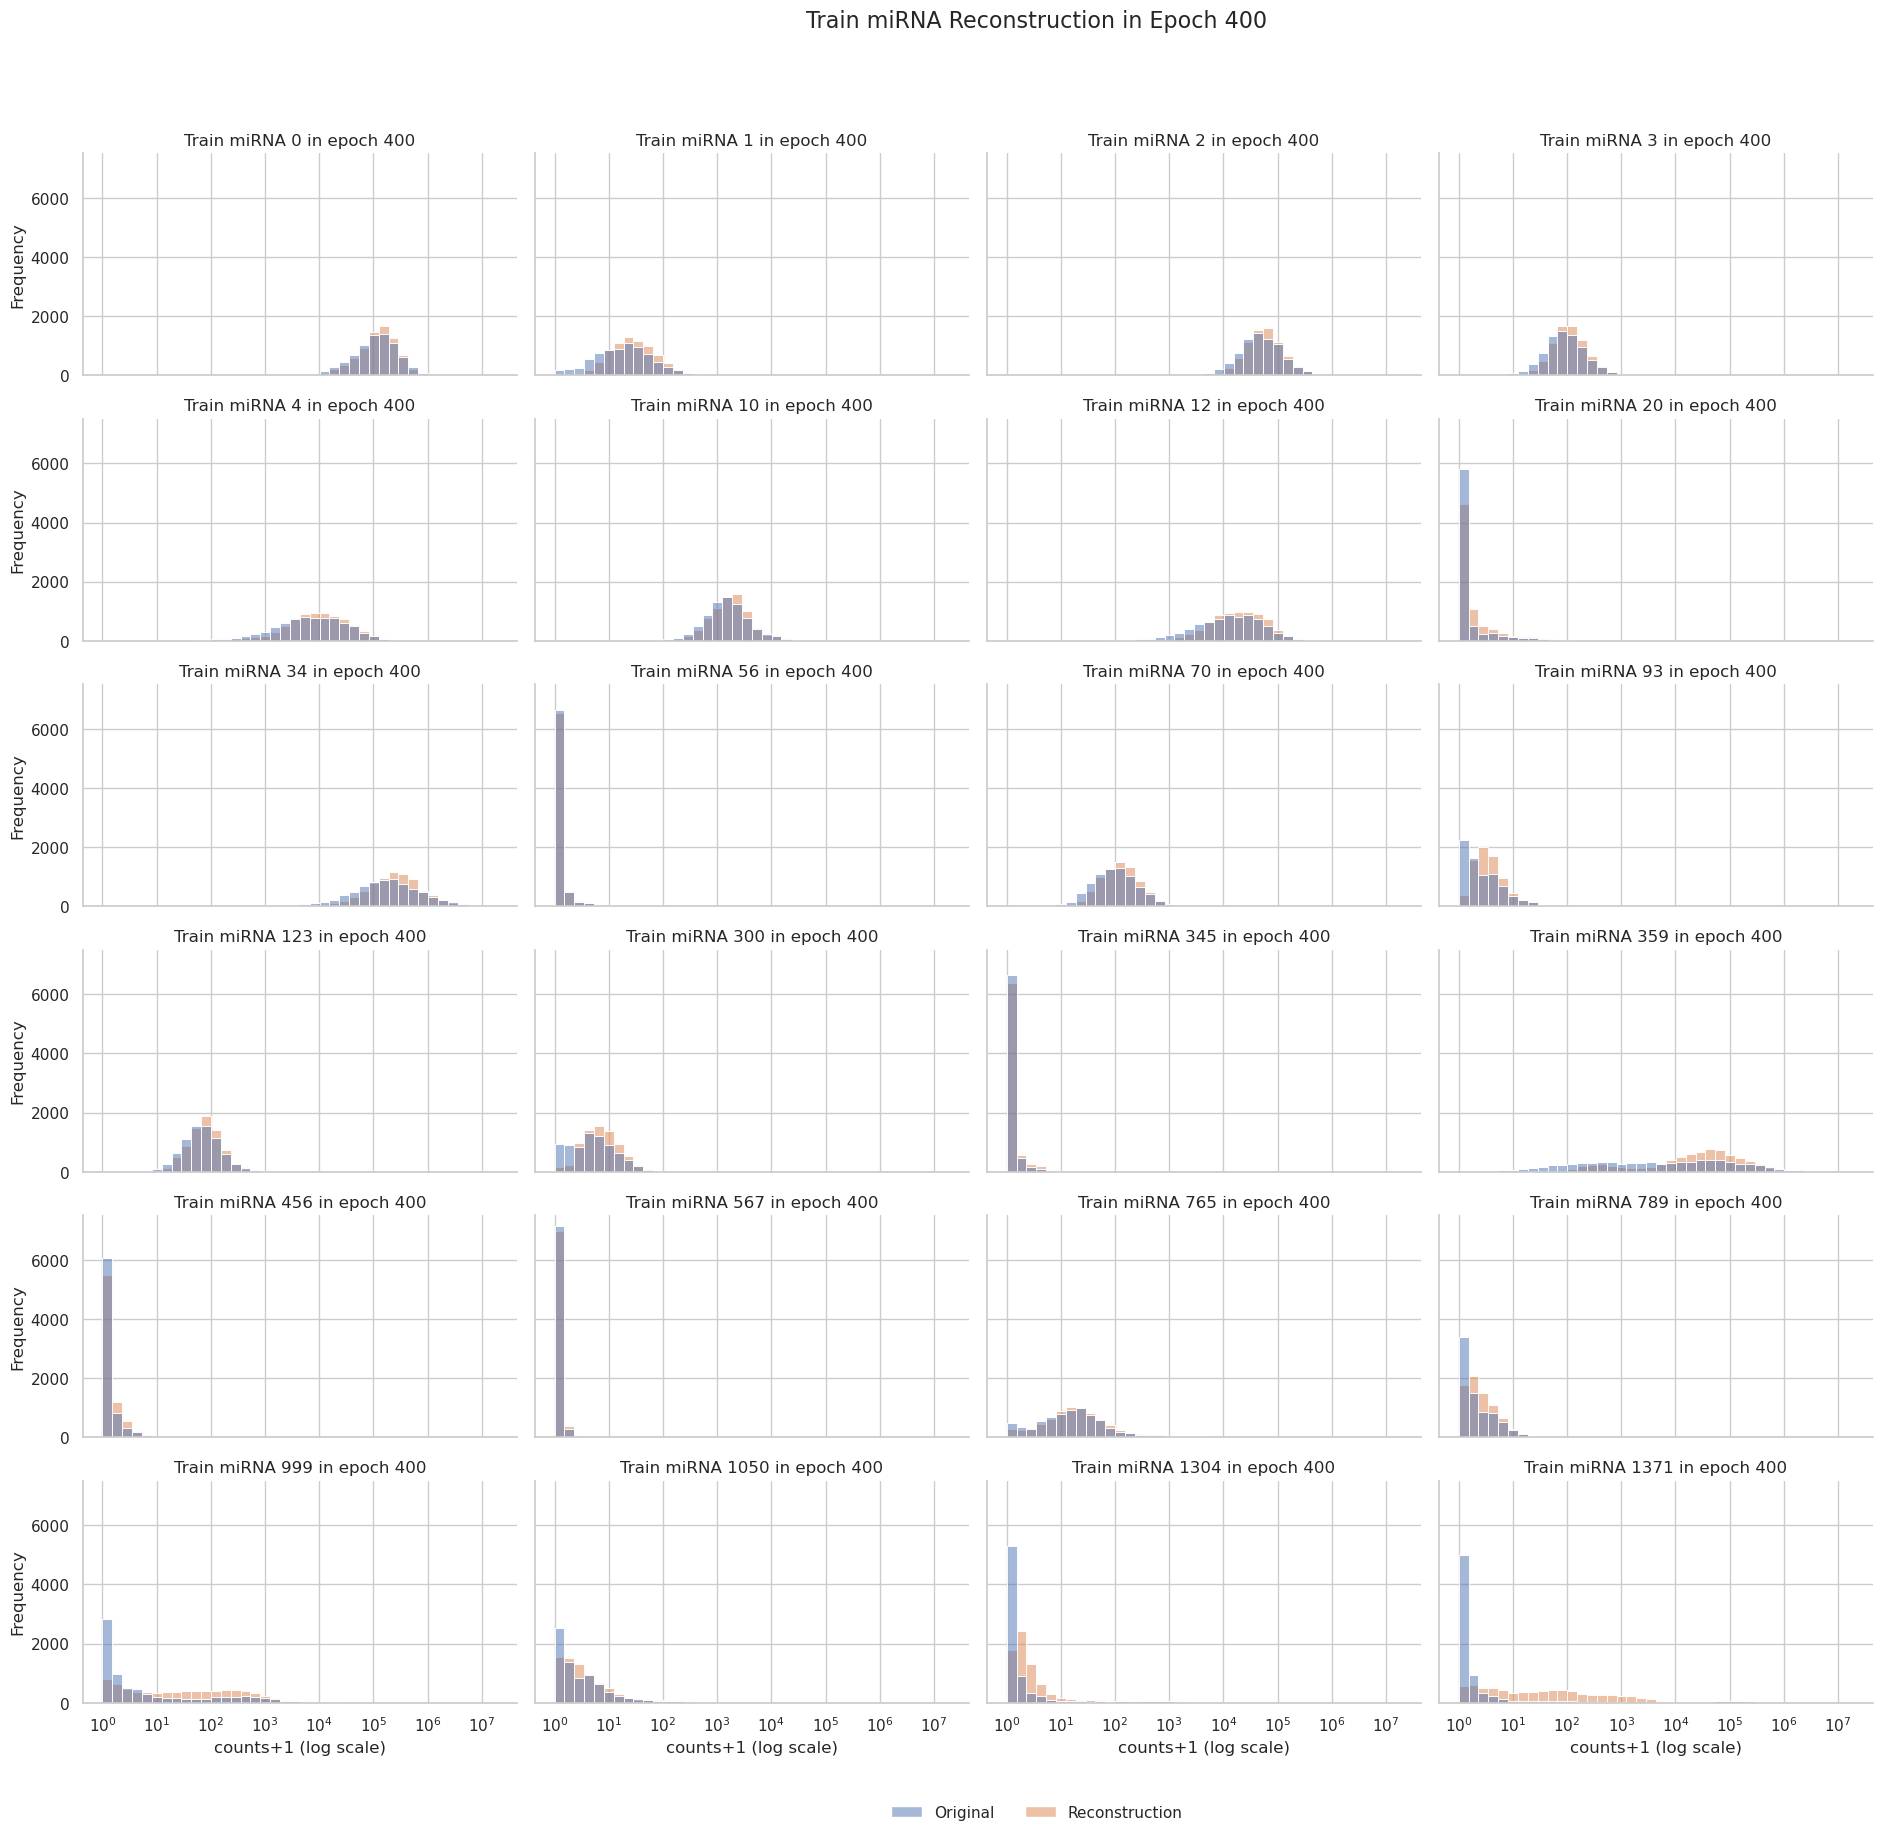

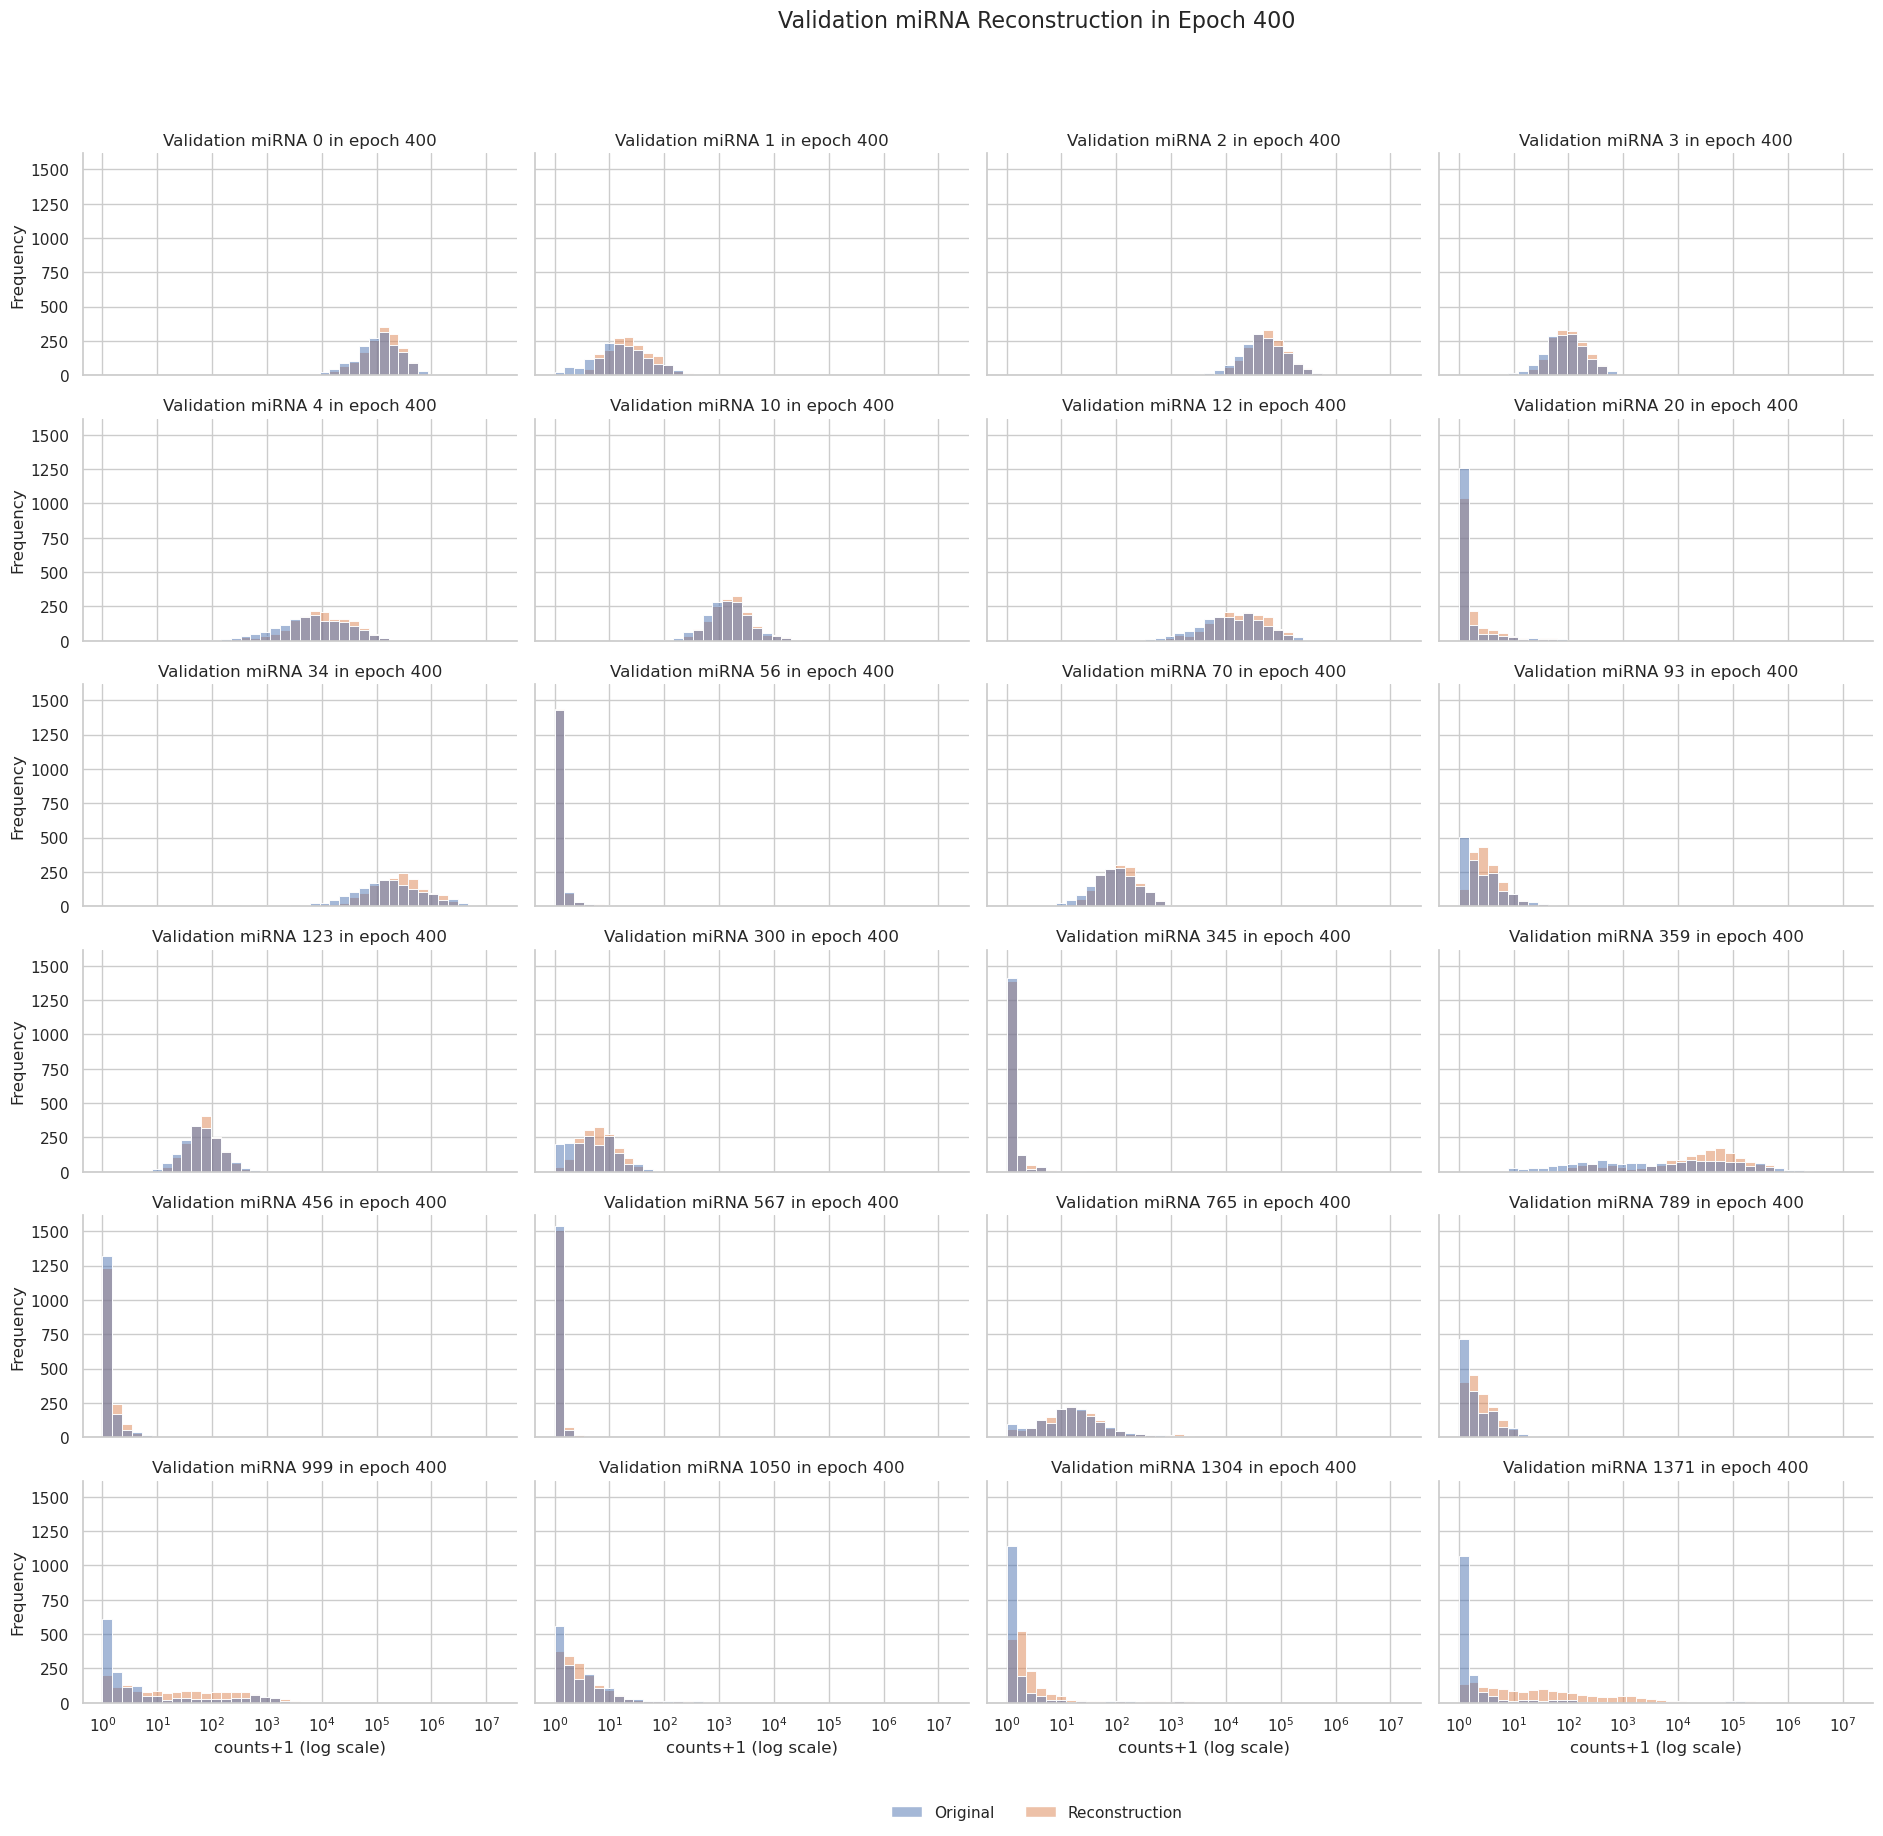

 68%|█████████████████████████████████████████████▎                     | 406/601 [15:49<13:32,  4.17s/it]

405 train_loss: 3.1985618212614764 train_recon: 1.777718846642379 train_gmm: 1.4208429746190971 train_mse: 0.36839354038238525 train_mae: 0.33934223651885986 train_r2: 0.18968701362609863 train_spearman: 0.3608831465244293 train_pearson: 0.48155197501182556 train_msle: 0.10180855542421341
405 test_loss: 3.230376360645453 test_recon: 1.8097971997645987 test_gmm: 1.4205791608808545 test_mse: 0.35831889510154724 test_mae: 0.357551246881485 test_r2: 0.17539656162261963 test_spearman: 0.28193819522857666 test_pearson: 0.42952772974967957 test_msle: 0.1083899661898613


 68%|█████████████████████████████████████████████▊                     | 411/601 [15:59<07:20,  2.32s/it]

410 train_loss: 3.1975564838394863 train_recon: 1.7766834833414125 train_gmm: 1.420873000498074 train_mse: 0.36892861127853394 train_mae: 0.42165887355804443 train_r2: 0.18851011991500854 train_spearman: 0.36375322937965393 train_pearson: 0.48324713110923767 train_msle: 0.1240495890378952
410 test_loss: 3.210567370967503 test_recon: 1.7896239620185506 test_gmm: 1.4209434089489523 test_mse: 0.38339877128601074 test_mae: 0.43778637051582336 test_r2: 0.11767995357513428 test_spearman: 0.28423792123794556 test_pearson: 0.42987021803855896 test_msle: 0.134784534573555


 69%|██████████████████████████████████████████████▍                    | 416/601 [16:08<06:16,  2.03s/it]

415 train_loss: 3.1968083003689616 train_recon: 1.775860823767936 train_gmm: 1.4209474766010255 train_mse: 0.3769780099391937 train_mae: 0.4294247627258301 train_r2: 0.17080479860305786 train_spearman: 0.3625544011592865 train_pearson: 0.48013466596603394 train_msle: 0.12757955491542816
415 test_loss: 3.199651333813597 test_recon: 1.7784031262189763 test_gmm: 1.4212482075946207 test_mse: 0.3676531910896301 test_mae: 0.416625052690506 test_r2: 0.1539154052734375 test_spearman: 0.2830701172351837 test_pearson: 0.43328166007995605 test_msle: 0.12631013989448547


 70%|██████████████████████████████████████████████▉                    | 421/601 [16:18<06:00,  2.00s/it]

420 train_loss: 3.195428529042738 train_recon: 1.7744412720940312 train_gmm: 1.4209872569487068 train_mse: 0.352145791053772 train_mae: 0.3869033455848694 train_r2: 0.22542530298233032 train_spearman: 0.36225953698158264 train_pearson: 0.4813877046108246 train_msle: 0.1113935187458992
420 test_loss: 3.1923297240401816 test_recon: 1.7712832149820517 test_gmm: 1.42104650905813 test_mse: 0.35997629165649414 test_mae: 0.40017592906951904 test_r2: 0.17158234119415283 test_spearman: 0.28644487261772156 test_pearson: 0.4338207542896271 test_msle: 0.12002141028642654


 71%|███████████████████████████████████████████████▍                   | 426/601 [16:28<05:51,  2.01s/it]

425 train_loss: 3.192971680839004 train_recon: 1.7719423550440347 train_gmm: 1.4210293257949693 train_mse: 0.3866364359855652 train_mae: 0.43776968121528625 train_r2: 0.14956021308898926 train_spearman: 0.3644389510154724 train_pearson: 0.4817701280117035 train_msle: 0.13138173520565033
425 test_loss: 3.2303433656998424 test_recon: 1.8095351584391426 test_gmm: 1.4208082072606996 test_mse: 0.40814104676246643 test_mae: 0.4613571763038635 test_r2: 0.06074029207229614 test_spearman: 0.290355920791626 test_pearson: 0.4341672360897064 test_msle: 0.1454148292541504


 72%|████████████████████████████████████████████████                   | 431/601 [16:38<05:28,  1.93s/it]

430 train_loss: 3.1920125442106917 train_recon: 1.7709354817825067 train_gmm: 1.421077062428185 train_mse: 0.3940715789794922 train_mae: 0.4489128887653351 train_r2: 0.13320600986480713 train_spearman: 0.36548060178756714 train_pearson: 0.4796801507472992 train_msle: 0.1362011730670929
430 test_loss: 3.219766323009455 test_recon: 1.7988513810229771 test_gmm: 1.420914941986478 test_mse: 0.40972623229026794 test_mae: 0.4626457393169403 test_r2: 0.057092249393463135 test_spearman: 0.2895600199699402 test_pearson: 0.43222281336784363 test_msle: 0.1463889628648758


 73%|████████████████████████████████████████████████▌                  | 436/601 [16:48<05:19,  1.93s/it]

435 train_loss: 3.1908956710673877 train_recon: 1.7697646350643608 train_gmm: 1.421131036003027 train_mse: 0.35003864765167236 train_mae: 0.36653169989585876 train_r2: 0.23006021976470947 train_spearman: 0.3630342483520508 train_pearson: 0.47989943623542786 train_msle: 0.10542582720518112
435 test_loss: 3.196823346756754 test_recon: 1.775720659935243 test_gmm: 1.4211026868215113 test_mse: 0.35112136602401733 test_mae: 0.37902894616127014 test_r2: 0.19196033477783203 test_spearman: 0.28792959451675415 test_pearson: 0.4403032064437866 test_msle: 0.11273828893899918


 73%|█████████████████████████████████████████████████▏                 | 441/601 [16:58<05:29,  2.06s/it]

440 train_loss: 3.189729323117571 train_recon: 1.768542026121111 train_gmm: 1.42118729699646 train_mse: 0.35004106163978577 train_mae: 0.38414984941482544 train_r2: 0.23005491495132446 train_spearman: 0.36619633436203003 train_pearson: 0.48388877511024475 train_msle: 0.11002951860427856
440 test_loss: 3.189442060712439 test_recon: 1.7684073326515295 test_gmm: 1.4210347280609097 test_mse: 0.35996127128601074 test_mae: 0.4053293764591217 test_r2: 0.17161691188812256 test_spearman: 0.28689131140708923 test_pearson: 0.43994370102882385 test_msle: 0.1213887557387352


 74%|█████████████████████████████████████████████████▋                 | 446/601 [17:08<05:02,  1.95s/it]

445 train_loss: 3.1883212988331686 train_recon: 1.7670731584461639 train_gmm: 1.4212481403870048 train_mse: 0.3490668833255768 train_mae: 0.378943532705307 train_r2: 0.23219770193099976 train_spearman: 0.3649838864803314 train_pearson: 0.48338159918785095 train_msle: 0.10841761529445648
445 test_loss: 3.194271381685629 test_recon: 1.772900277671996 test_gmm: 1.421371104013633 test_mse: 0.35270535945892334 test_mae: 0.3920176923274994 test_r2: 0.1883150339126587 test_spearman: 0.2873820662498474 test_pearson: 0.4430488348007202 test_msle: 0.11667442321777344


 75%|██████████████████████████████████████████████████▎                | 451/601 [17:17<04:55,  1.97s/it]

450 train_loss: 3.186541904294119 train_recon: 1.765246624508309 train_gmm: 1.4212952797858103 train_mse: 0.3548632562160492 train_mae: 0.39895209670066833 train_r2: 0.2194480299949646 train_spearman: 0.36677229404449463 train_pearson: 0.4833676517009735 train_msle: 0.11491329222917557
450 test_loss: 3.1885634932447395 test_recon: 1.7673097959171393 test_gmm: 1.4212536973276 test_mse: 0.3563884198665619 test_mae: 0.4022569954395294 test_r2: 0.17983919382095337 test_spearman: 0.2875639796257019 test_pearson: 0.4416421353816986 test_msle: 0.11987286806106567


 76%|██████████████████████████████████████████████████▊                | 456/601 [17:27<04:39,  1.93s/it]

455 train_loss: 3.185561444767984 train_recon: 1.7642263651946746 train_gmm: 1.4213350795733097 train_mse: 0.35288378596305847 train_mae: 0.35478144884109497 train_r2: 0.2238020896911621 train_spearman: 0.3646722733974457 train_pearson: 0.4833209216594696 train_msle: 0.10226136445999146
455 test_loss: 3.19494122642382 test_recon: 1.7737322434502398 test_gmm: 1.4212089829735806 test_mse: 0.3523579239845276 test_mae: 0.3737092912197113 test_r2: 0.18911463022232056 test_spearman: 0.2909441292285919 test_pearson: 0.43637967109680176 test_msle: 0.11102461069822311


 77%|███████████████████████████████████████████████████▍               | 461/601 [17:37<04:34,  1.96s/it]

460 train_loss: 3.1856598635894553 train_recon: 1.7642679355082116 train_gmm: 1.421391928081244 train_mse: 0.34752288460731506 train_mae: 0.3731955885887146 train_r2: 0.23559385538101196 train_spearman: 0.3648099899291992 train_pearson: 0.4855506718158722 train_msle: 0.10672403126955032
460 test_loss: 3.18503660051684 test_recon: 1.7640089450871244 test_gmm: 1.4210276554297159 test_mse: 0.35559380054473877 test_mae: 0.40089792013168335 test_r2: 0.18166780471801758 test_spearman: 0.290910542011261 test_pearson: 0.4438024163246155 test_msle: 0.11937282234430313


 78%|███████████████████████████████████████████████████▉               | 466/601 [17:47<04:27,  1.98s/it]

465 train_loss: 3.183349294616642 train_recon: 1.7619021920117959 train_gmm: 1.4214471026048459 train_mse: 0.3994901776313782 train_mae: 0.4500233232975006 train_r2: 0.12128734588623047 train_spearman: 0.36821937561035156 train_pearson: 0.4839229881763458 train_msle: 0.13733287155628204
465 test_loss: 3.2132735730532485 test_recon: 1.7918195080335166 test_gmm: 1.421454065019732 test_mse: 0.39933356642723083 test_mae: 0.44979581236839294 test_r2: 0.08100903034210205 test_spearman: 0.288417249917984 test_pearson: 0.43843352794647217 test_msle: 0.1411493867635727


 78%|████████████████████████████████████████████████████▌              | 471/601 [17:56<04:01,  1.86s/it]

470 train_loss: 3.1836215769256446 train_recon: 1.7621042544580119 train_gmm: 1.4215173224676327 train_mse: 0.36150357127189636 train_mae: 0.41165590286254883 train_r2: 0.20484209060668945 train_spearman: 0.36516880989074707 train_pearson: 0.48847439885139465 train_msle: 0.12038576602935791
470 test_loss: 3.1860256208334574 test_recon: 1.7643561556296337 test_gmm: 1.421669465203824 test_mse: 0.3561583459377289 test_mae: 0.4016761779785156 test_r2: 0.18036866188049316 test_spearman: 0.2900916039943695 test_pearson: 0.4434305429458618 test_msle: 0.11958452314138412


 79%|█████████████████████████████████████████████████████              | 476/601 [18:06<04:14,  2.04s/it]

475 train_loss: 3.1814539402481192 train_recon: 1.7599086795219707 train_gmm: 1.4215452607261485 train_mse: 0.34954407811164856 train_mae: 0.35452911257743835 train_r2: 0.23114800453186035 train_spearman: 0.3663887679576874 train_pearson: 0.49034205079078674 train_msle: 0.10194192081689835
475 test_loss: 3.1921317721198745 test_recon: 1.7707373228781171 test_gmm: 1.4213944492417574 test_mse: 0.349160760641098 test_mae: 0.3693056106567383 test_r2: 0.19647228717803955 test_spearman: 0.2905505895614624 test_pearson: 0.44558748602867126 test_msle: 0.10898054391145706


 80%|█████████████████████████████████████████████████████▌             | 481/601 [18:16<03:55,  1.96s/it]

480 train_loss: 3.17959109808313 train_recon: 1.7579934751270583 train_gmm: 1.4215976229560716 train_mse: 0.3656546175479889 train_mae: 0.41359058022499084 train_r2: 0.19571155309677124 train_spearman: 0.3657403588294983 train_pearson: 0.48994180560112 train_msle: 0.12226375192403793
480 test_loss: 3.1846513059517827 test_recon: 1.7631863723697887 test_gmm: 1.4214649335819942 test_mse: 0.3689512014389038 test_mae: 0.4204710125923157 test_r2: 0.15092825889587402 test_spearman: 0.29100969433784485 test_pearson: 0.4459379315376282 test_msle: 0.127932608127594


 81%|██████████████████████████████████████████████████████▏            | 486/601 [18:26<03:48,  1.99s/it]

485 train_loss: 3.178838420023367 train_recon: 1.757188129200233 train_gmm: 1.421650290823134 train_mse: 0.3503398895263672 train_mae: 0.3915026783943176 train_r2: 0.22939759492874146 train_spearman: 0.367610901594162 train_pearson: 0.4899238049983978 train_msle: 0.1125466600060463
485 test_loss: 3.1845836737653075 test_recon: 1.7632508315269853 test_gmm: 1.421332842238322 test_mse: 0.3614741861820221 test_mae: 0.41120120882987976 test_r2: 0.16813522577285767 test_spearman: 0.29240721464157104 test_pearson: 0.4413197338581085 test_msle: 0.12308365851640701


 82%|██████████████████████████████████████████████████████▋            | 491/601 [18:36<03:43,  2.03s/it]

490 train_loss: 3.1772501245774913 train_recon: 1.7555737401185771 train_gmm: 1.4216763844589144 train_mse: 0.3461146950721741 train_mae: 0.36365601420402527 train_r2: 0.2386912703514099 train_spearman: 0.36617910861968994 train_pearson: 0.48882800340652466 train_msle: 0.10473300516605377
490 test_loss: 3.1836277404487525 test_recon: 1.7620042498682271 test_gmm: 1.4216234905805256 test_mse: 0.3493882715702057 test_mae: 0.38055846095085144 test_r2: 0.19594866037368774 test_spearman: 0.29207098484039307 test_pearson: 0.4456060528755188 test_msle: 0.11279497295618057


 83%|███████████████████████████████████████████████████████▎           | 496/601 [18:46<03:29,  2.00s/it]

495 train_loss: 3.1768000095363673 train_recon: 1.7550793012122958 train_gmm: 1.4217207083240713 train_mse: 0.3683166801929474 train_mae: 0.4193790555000305 train_r2: 0.18985611200332642 train_spearman: 0.3681383728981018 train_pearson: 0.49216434359550476 train_msle: 0.1238870844244957
495 test_loss: 3.18654399172482 test_recon: 1.7649653062377022 test_gmm: 1.421578685487118 test_mse: 0.37077444791793823 test_mae: 0.4262988567352295 test_r2: 0.14673244953155518 test_spearman: 0.2934948801994324 test_pearson: 0.4448258876800537 test_msle: 0.12949608266353607


 83%|███████████████████████████████████████████████████████▋           | 500/601 [18:54<03:22,  2.00s/it]

500 train_loss: 3.1757030167061266 train_recon: 1.7539444536563513 train_gmm: 1.4217585630497753 train_mse: 0.3527218699455261 train_mae: 0.3936794102191925 train_r2: 0.22415822744369507 train_spearman: 0.36884424090385437 train_pearson: 0.4890957474708557 train_msle: 0.11380480974912643
500 test_loss: 3.1850141523812656 test_recon: 1.76346529998852 test_gmm: 1.4215488523927453 test_mse: 0.36574187874794006 test_mae: 0.4103834331035614 test_r2: 0.15831393003463745 test_spearman: 0.29347074031829834 test_pearson: 0.43558409810066223 test_msle: 0.12332676351070404


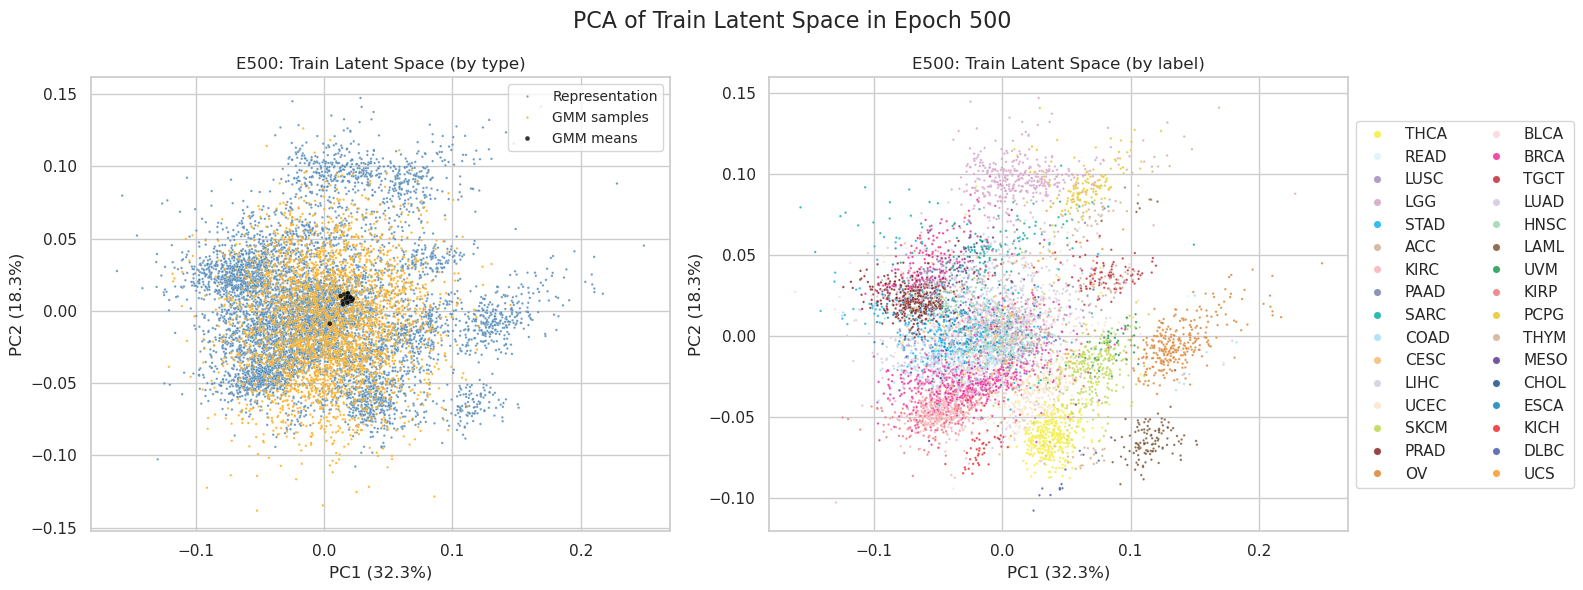

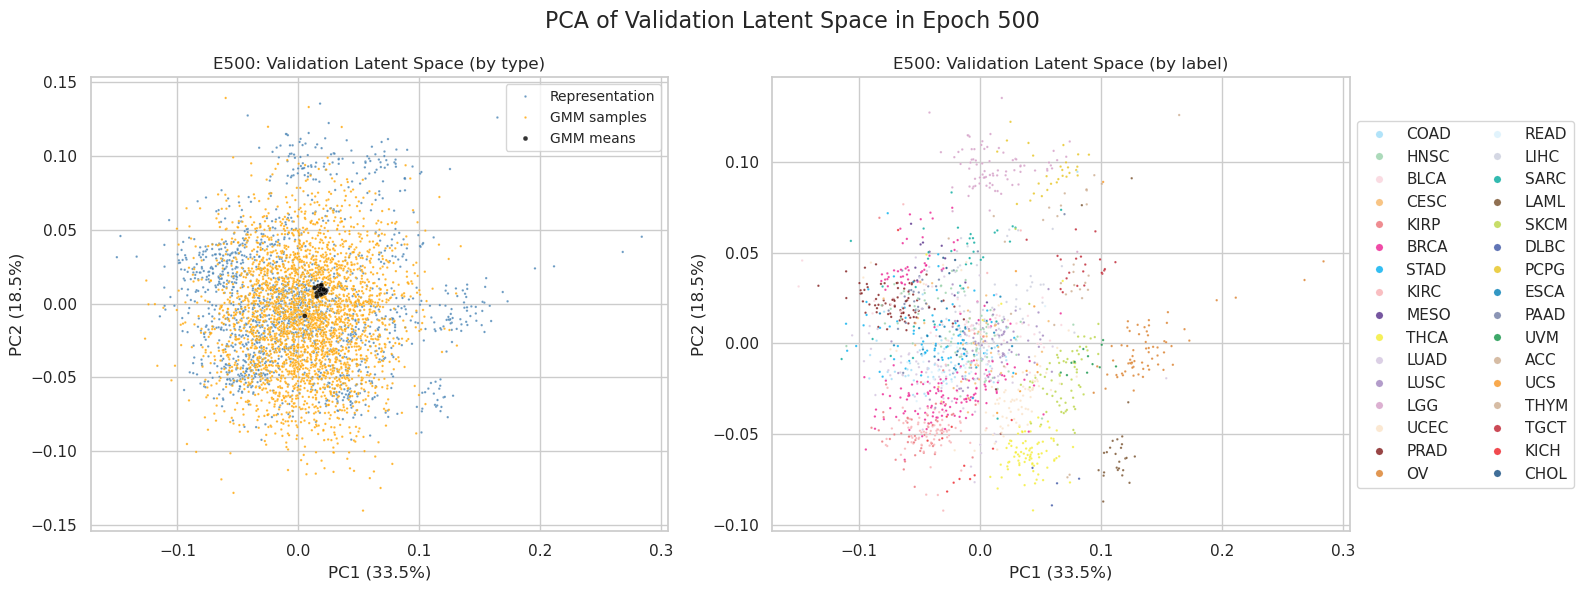

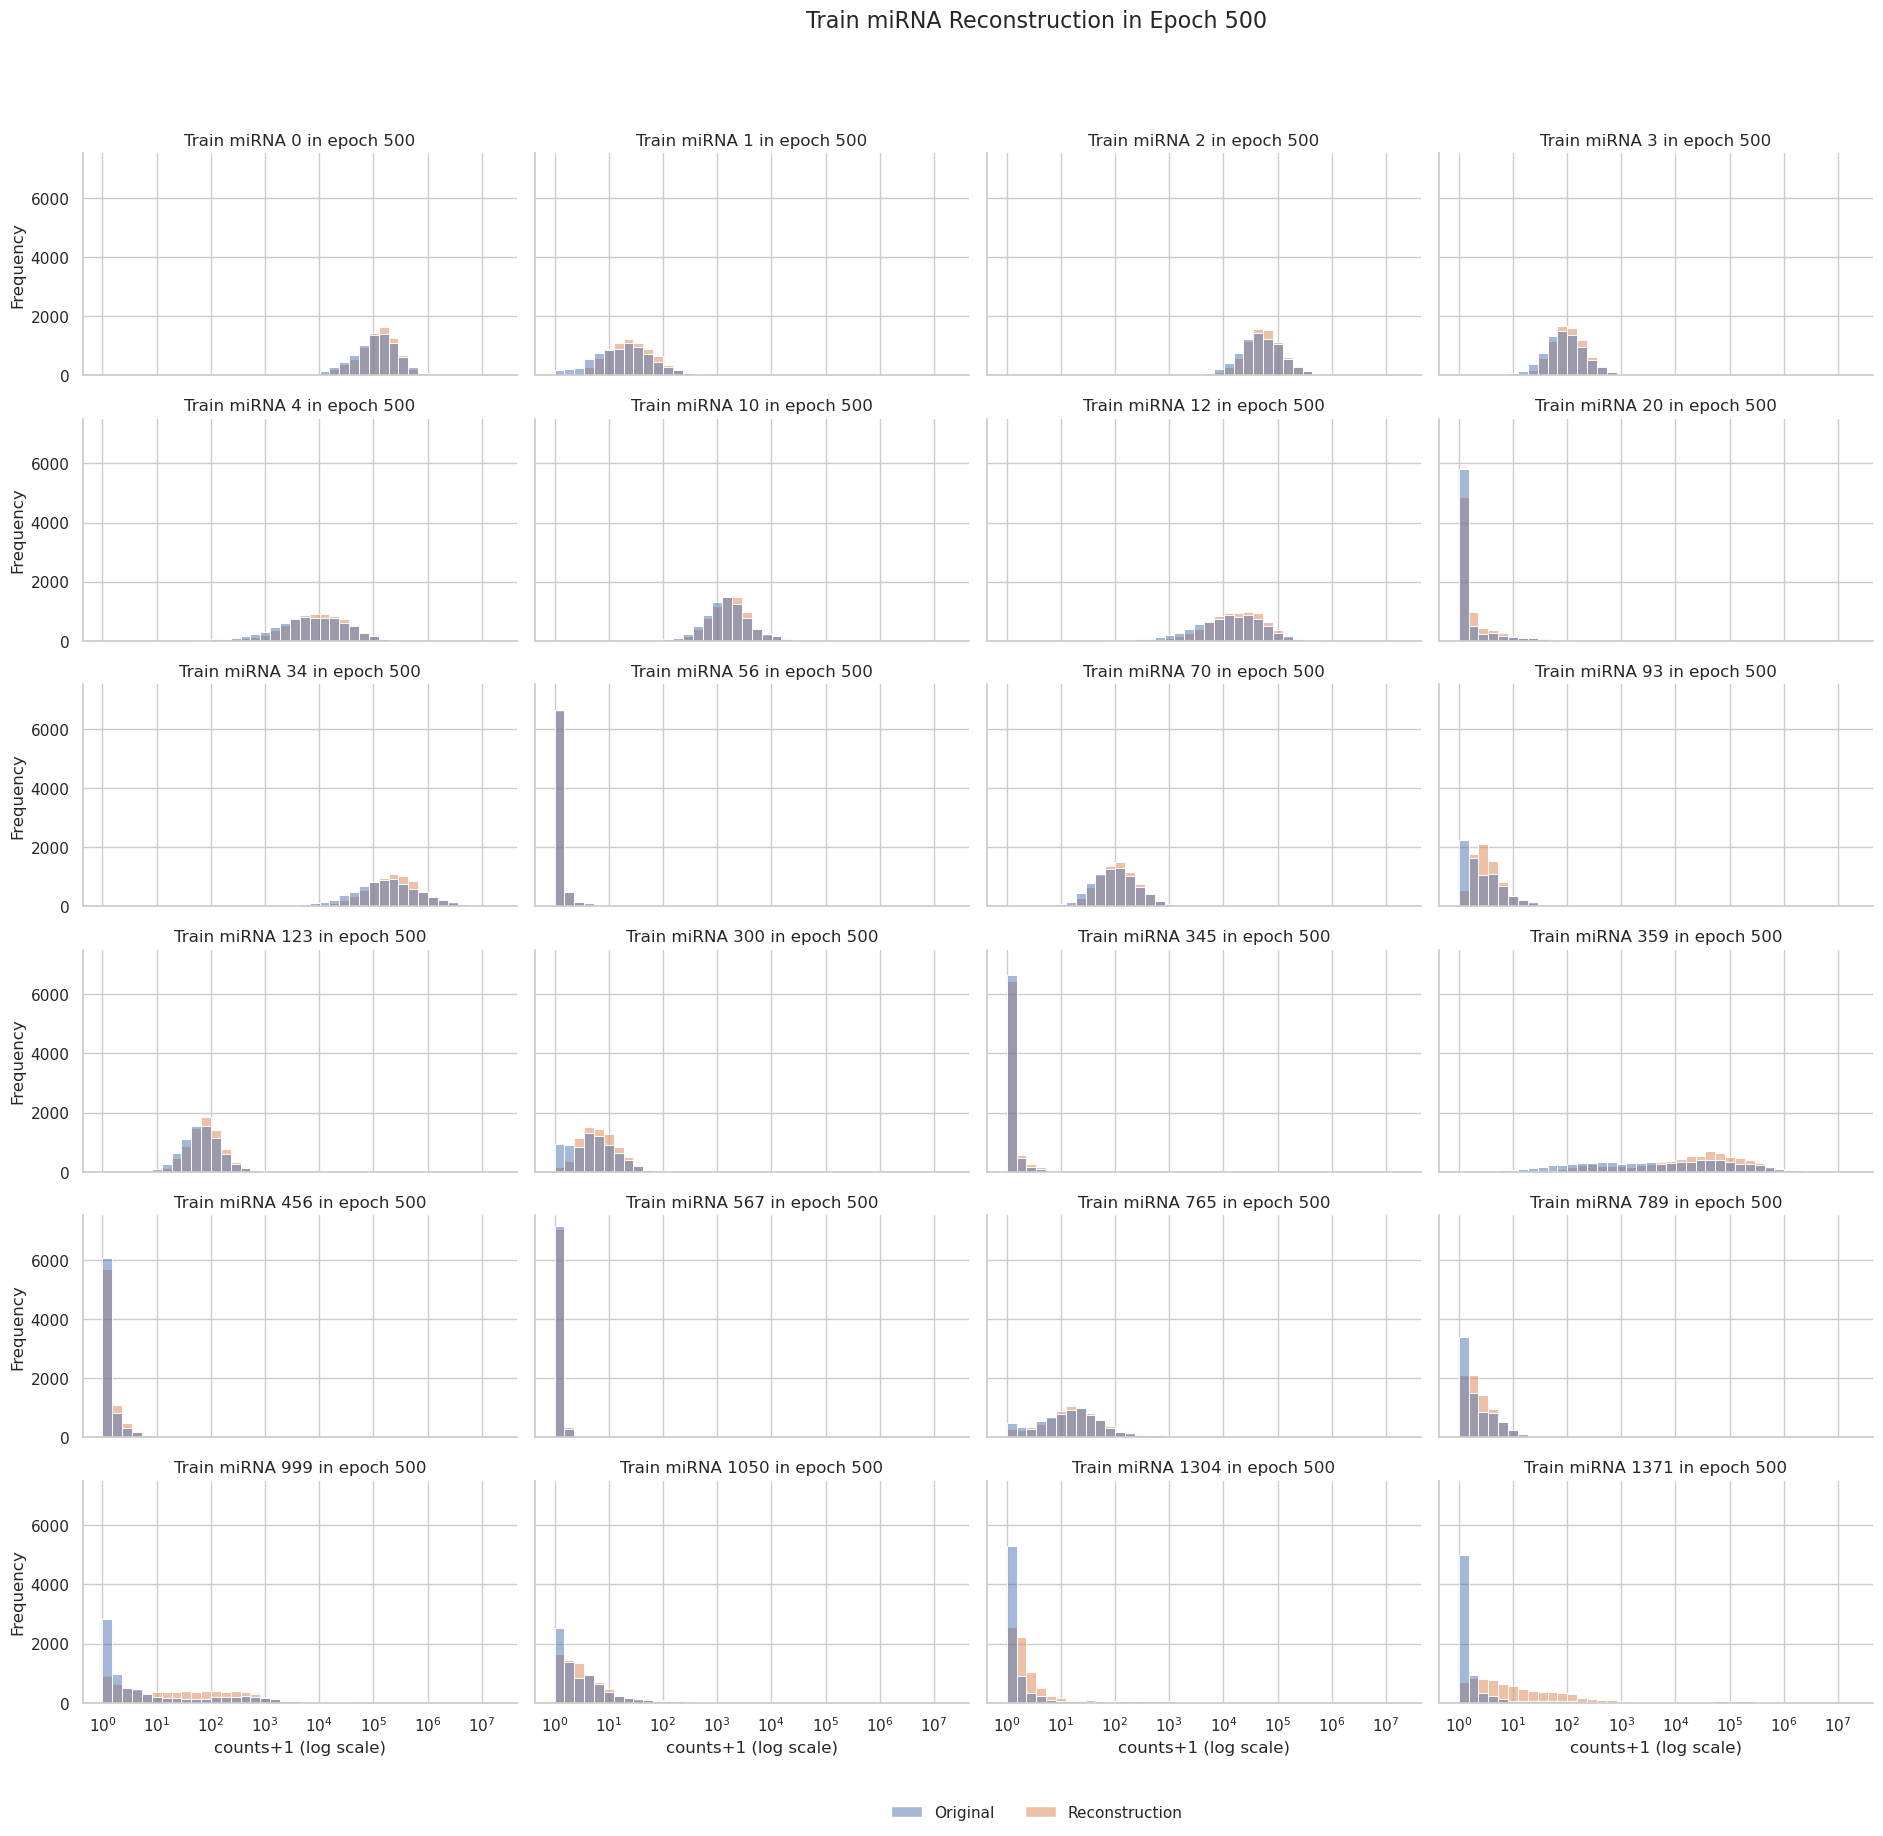

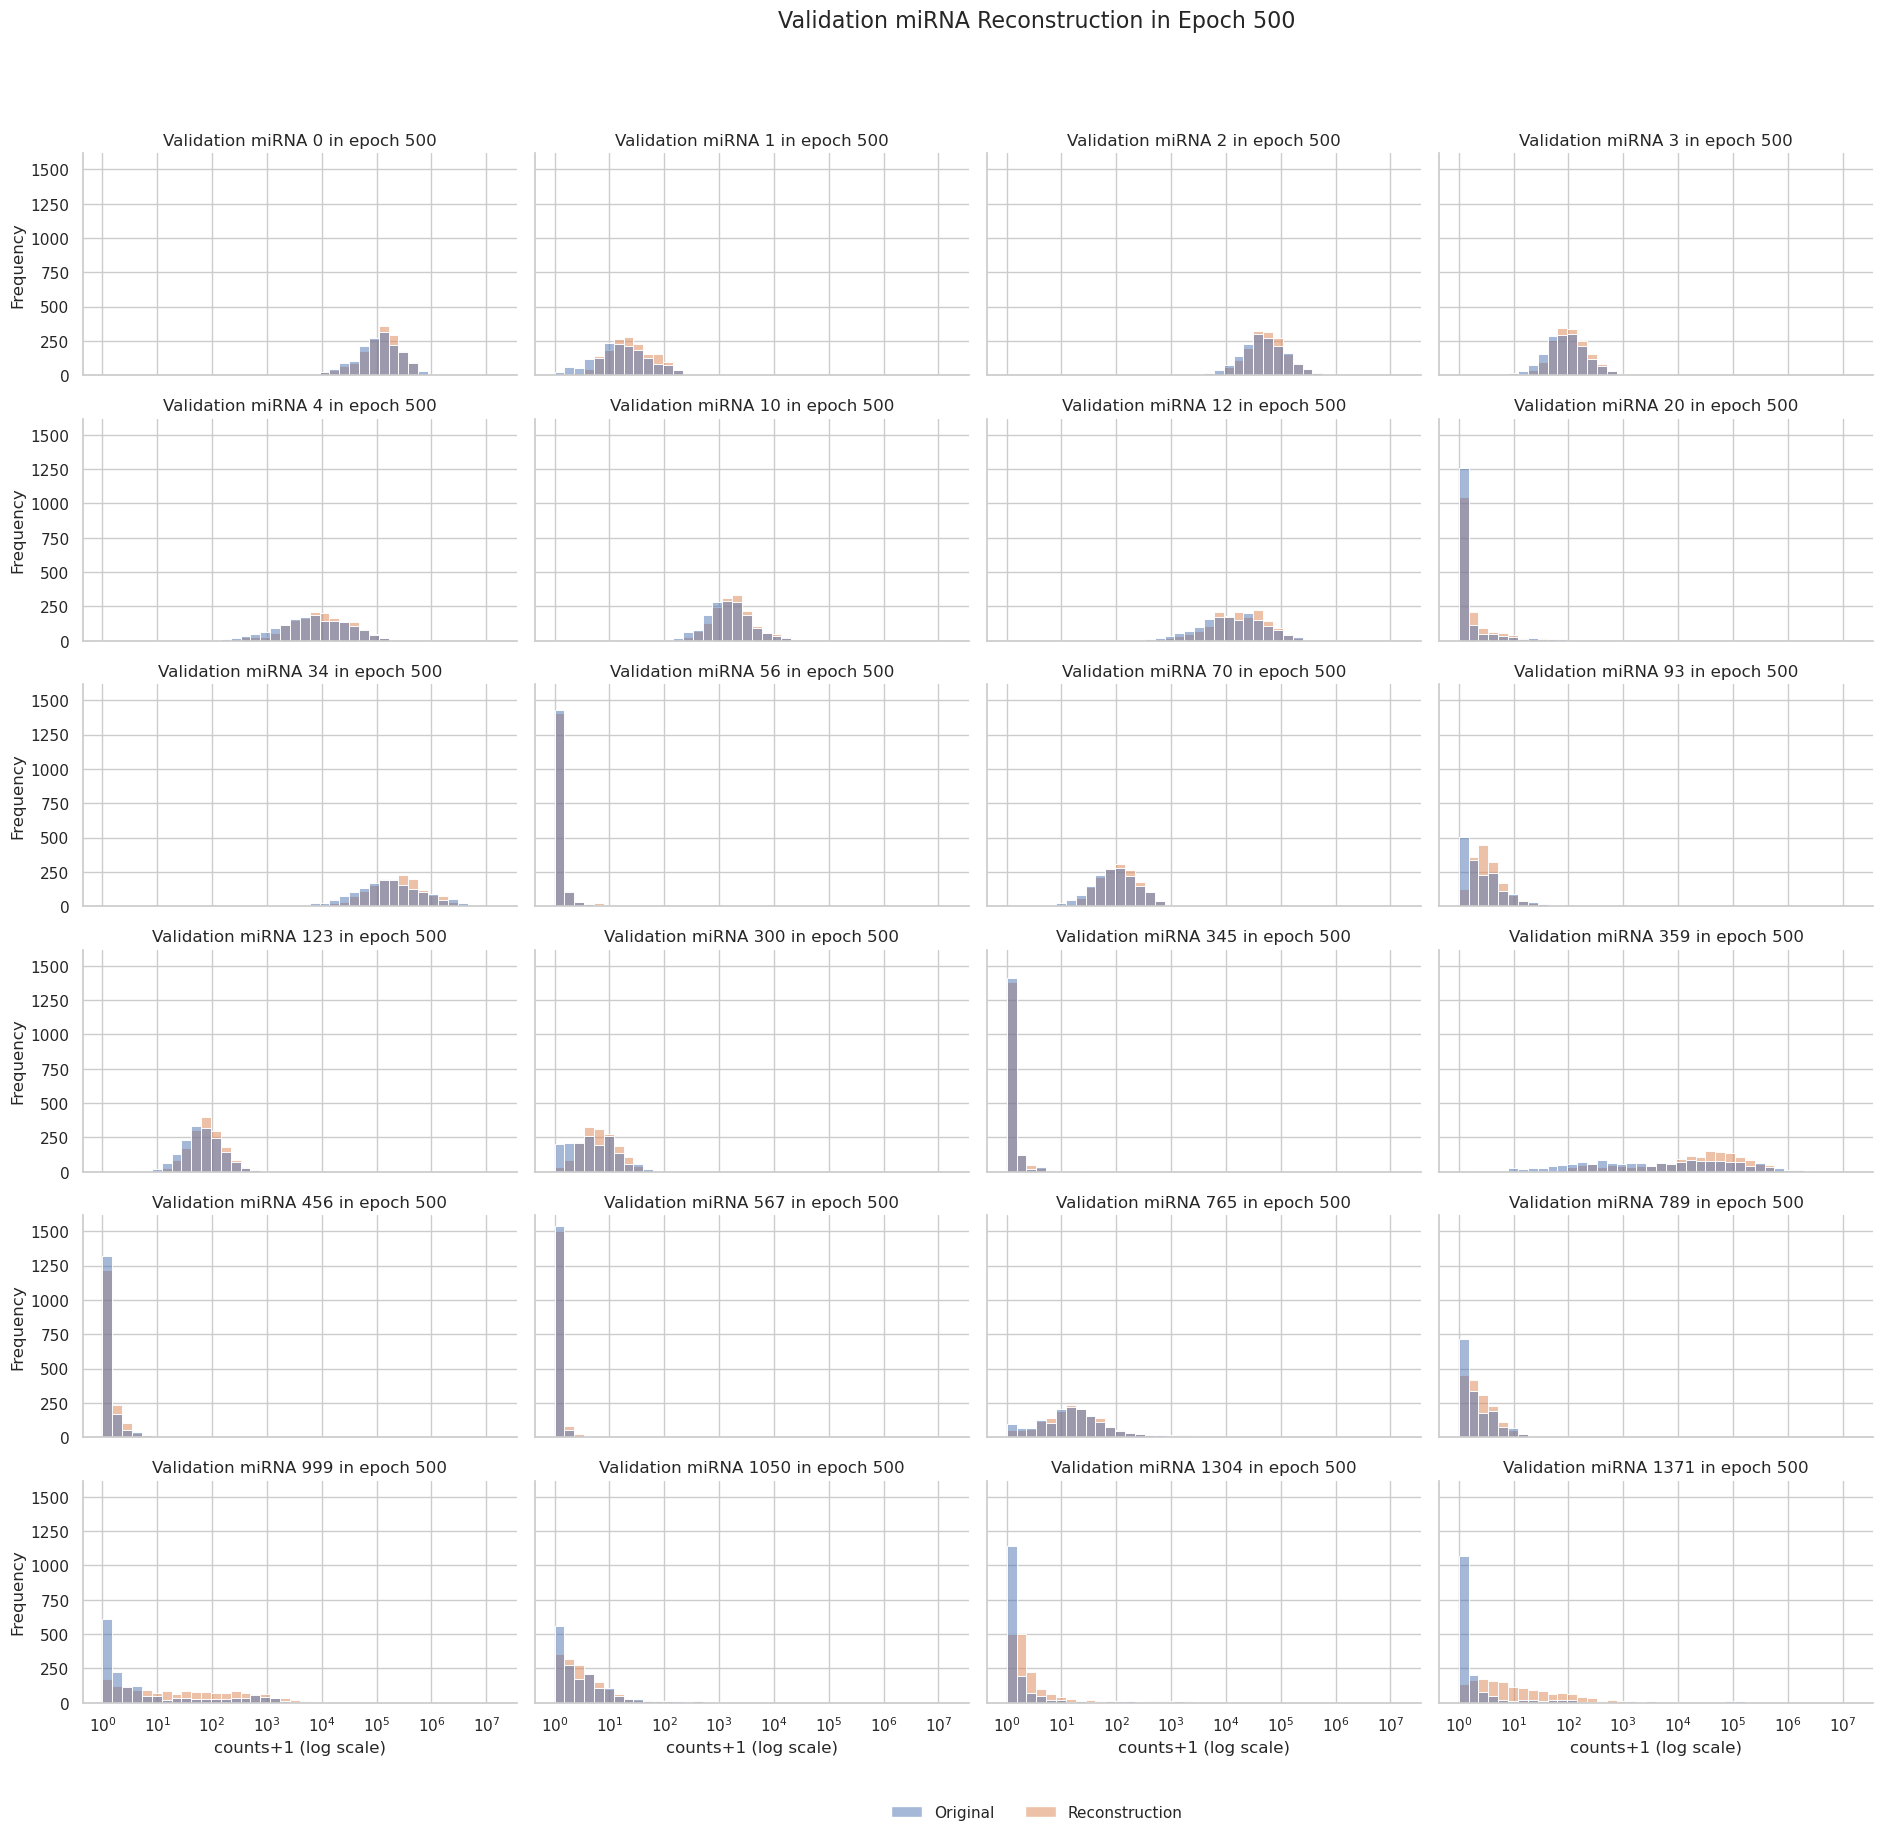

 84%|████████████████████████████████████████████████████████▍          | 506/601 [19:50<06:50,  4.32s/it]

505 train_loss: 3.1748339317480316 train_recon: 1.7530404850247452 train_gmm: 1.4217934467232864 train_mse: 0.3464254140853882 train_mae: 0.3817332983016968 train_r2: 0.23800784349441528 train_spearman: 0.3692231774330139 train_pearson: 0.4917607009410858 train_msle: 0.10918714106082916
505 test_loss: 3.1790401783560087 test_recon: 1.7572623501584979 test_gmm: 1.4217778281975109 test_mse: 0.35083138942718506 test_mae: 0.38783466815948486 test_r2: 0.19262760877609253 test_spearman: 0.29401856660842896 test_pearson: 0.4442978799343109 test_msle: 0.11455050855875015


 85%|████████████████████████████████████████████████████████▉          | 511/601 [20:01<03:40,  2.45s/it]

510 train_loss: 3.1735451347320858 train_recon: 1.751712259737823 train_gmm: 1.421832874994263 train_mse: 0.3530457615852356 train_mae: 0.3945452570915222 train_r2: 0.22344577312469482 train_spearman: 0.3680420517921448 train_pearson: 0.4946955442428589 train_msle: 0.11481671035289764
510 test_loss: 3.1766396937070303 test_recon: 1.7549975713054835 test_gmm: 1.4216421224015465 test_mse: 0.36364778876304626 test_mae: 0.41357895731925964 test_r2: 0.1631331443786621 test_spearman: 0.29657527804374695 test_pearson: 0.4459817409515381 test_msle: 0.1245722696185112


 86%|█████████████████████████████████████████████████████████▌         | 516/601 [20:11<02:55,  2.06s/it]

515 train_loss: 3.172990136096953 train_recon: 1.7511166599626904 train_gmm: 1.4218734761342624 train_mse: 0.34519749879837036 train_mae: 0.36231729388237 train_r2: 0.24070864915847778 train_spearman: 0.3696928918361664 train_pearson: 0.49383506178855896 train_msle: 0.10318344831466675
515 test_loss: 3.1854008911053278 test_recon: 1.763367097176172 test_gmm: 1.4220337939291559 test_mse: 0.3488861322402954 test_mae: 0.3694649934768677 test_r2: 0.1971043348312378 test_spearman: 0.29425710439682007 test_pearson: 0.4459969401359558 test_msle: 0.10860811918973923


 87%|██████████████████████████████████████████████████████████         | 521/601 [20:21<02:50,  2.13s/it]

520 train_loss: 3.1722784452031414 train_recon: 1.7503733404849025 train_gmm: 1.4219051047182392 train_mse: 0.34557124972343445 train_mae: 0.35663679242134094 train_r2: 0.2398865818977356 train_spearman: 0.3685658872127533 train_pearson: 0.49252814054489136 train_msle: 0.10285212844610214
520 test_loss: 3.1940041434480206 test_recon: 1.7721061107666773 test_gmm: 1.4218980326813433 test_mse: 0.351319283246994 test_mae: 0.37348493933677673 test_r2: 0.1915048360824585 test_spearman: 0.29520735144615173 test_pearson: 0.4390166401863098 test_msle: 0.11078253388404846


 88%|██████████████████████████████████████████████████████████▋        | 526/601 [20:31<02:29,  1.99s/it]

525 train_loss: 3.17083243908292 train_recon: 1.7488751697729084 train_gmm: 1.421957269310012 train_mse: 0.3451387584209442 train_mae: 0.35621342062950134 train_r2: 0.24083787202835083 train_spearman: 0.36750319600105286 train_pearson: 0.4937821924686432 train_msle: 0.10280786454677582
525 test_loss: 3.180204279226057 test_recon: 1.7585282001290572 test_gmm: 1.4216760790970002 test_mse: 0.3482663035392761 test_mae: 0.3788498044013977 test_r2: 0.1985306739807129 test_spearman: 0.2972814738750458 test_pearson: 0.4469034969806671 test_msle: 0.11167287826538086


 88%|███████████████████████████████████████████████████████████▏       | 531/601 [20:41<02:21,  2.02s/it]

530 train_loss: 3.1701555121246106 train_recon: 1.7481620458733786 train_gmm: 1.4219934662512317 train_mse: 0.36124011874198914 train_mae: 0.40570682287216187 train_r2: 0.2054215669631958 train_spearman: 0.36927762627601624 train_pearson: 0.4943575859069824 train_msle: 0.1196262538433075
530 test_loss: 3.1778022408294406 test_recon: 1.7558295901246257 test_gmm: 1.4219726507048152 test_mse: 0.37102559208869934 test_mae: 0.4184597134590149 test_r2: 0.1461544632911682 test_spearman: 0.2977120876312256 test_pearson: 0.44545334577560425 test_msle: 0.12763701379299164


 89%|███████████████████████████████████████████████████████████▊       | 536/601 [20:51<02:08,  1.98s/it]

535 train_loss: 3.1692932472557276 train_recon: 1.7472744962811444 train_gmm: 1.422018750974583 train_mse: 0.3515043258666992 train_mae: 0.39714106917381287 train_r2: 0.22683626413345337 train_spearman: 0.3705091178417206 train_pearson: 0.4983678460121155 train_msle: 0.11529345065355301
535 test_loss: 3.1764069388478458 test_recon: 1.7545308499751884 test_gmm: 1.4218760888726572 test_mse: 0.36493730545043945 test_mae: 0.4126434326171875 test_r2: 0.16016554832458496 test_spearman: 0.2983325719833374 test_pearson: 0.44057512283325195 test_msle: 0.12414658069610596


 90%|████████████████████████████████████████████████████████████▎      | 541/601 [21:01<02:01,  2.03s/it]

540 train_loss: 3.167920260050357 train_recon: 1.7458638865478966 train_gmm: 1.42205637350246 train_mse: 0.34323328733444214 train_mae: 0.3733767569065094 train_r2: 0.24502915143966675 train_spearman: 0.36807554960250854 train_pearson: 0.4952520430088043 train_msle: 0.10617609322071075
540 test_loss: 3.173285117268885 test_recon: 1.7514046628234454 test_gmm: 1.4218804544454395 test_mse: 0.3540501594543457 test_mae: 0.3865440785884857 test_r2: 0.18522024154663086 test_spearman: 0.2969948649406433 test_pearson: 0.43483081459999084 test_msle: 0.11401303112506866


 91%|████████████████████████████████████████████████████████████▊      | 546/601 [21:11<01:48,  1.97s/it]

545 train_loss: 3.167352611164926 train_recon: 1.745266440741346 train_gmm: 1.4220861704235799 train_mse: 0.34894251823425293 train_mae: 0.35177648067474365 train_r2: 0.23247122764587402 train_spearman: 0.3691554069519043 train_pearson: 0.4963764250278473 train_msle: 0.10118889808654785
545 test_loss: 3.1823350403864095 test_recon: 1.7603352938920955 test_gmm: 1.421999746494314 test_mse: 0.3506099581718445 test_mae: 0.3694285452365875 test_r2: 0.19313716888427734 test_spearman: 0.2984379529953003 test_pearson: 0.44076603651046753 test_msle: 0.10898631811141968


 92%|█████████████████████████████████████████████████████████████▍     | 551/601 [21:21<01:37,  1.96s/it]

550 train_loss: 3.166609290560192 train_recon: 1.7444821841997462 train_gmm: 1.422127106360446 train_mse: 0.34836679697036743 train_mae: 0.3886985182762146 train_r2: 0.23373758792877197 train_spearman: 0.36938878893852234 train_pearson: 0.49255838990211487 train_msle: 0.11165303736925125
550 test_loss: 3.1735643556809796 test_recon: 1.7515060721991937 test_gmm: 1.4220582834817856 test_mse: 0.34892523288726807 test_mae: 0.38976702094078064 test_r2: 0.19701427221298218 test_spearman: 0.30008310079574585 test_pearson: 0.4503604769706726 test_msle: 0.11486078053712845


 93%|█████████████████████████████████████████████████████████████▉     | 556/601 [21:31<01:30,  2.01s/it]

555 train_loss: 3.1653633733690056 train_recon: 1.7432003875843682 train_gmm: 1.4221629857846374 train_mse: 0.35351067781448364 train_mae: 0.40072548389434814 train_r2: 0.22242319583892822 train_spearman: 0.36894306540489197 train_pearson: 0.49957337975502014 train_msle: 0.11709485948085785
555 test_loss: 3.185506490712046 test_recon: 1.7635147292838838 test_gmm: 1.421991761428162 test_mse: 0.3701154589653015 test_mae: 0.41827136278152466 test_r2: 0.14824903011322021 test_spearman: 0.303816556930542 test_pearson: 0.44269534945487976 test_msle: 0.1265999674797058


 93%|██████████████████████████████████████████████████████████████▌    | 561/601 [21:41<01:19,  1.98s/it]

560 train_loss: 3.165341203477371 train_recon: 1.7431409850412076 train_gmm: 1.4222002184361635 train_mse: 0.3429403603076935 train_mae: 0.3627466857433319 train_r2: 0.24567347764968872 train_spearman: 0.36879634857177734 train_pearson: 0.4962506592273712 train_msle: 0.10398881882429123
560 test_loss: 3.179338409574081 test_recon: 1.7572728619001712 test_gmm: 1.42206554767391 test_mse: 0.3485803008079529 test_mae: 0.37105000019073486 test_r2: 0.19780808687210083 test_spearman: 0.3001694679260254 test_pearson: 0.44553089141845703 test_msle: 0.10929717868566513


 94%|███████████████████████████████████████████████████████████████    | 566/601 [21:51<01:09,  1.99s/it]

565 train_loss: 3.1642563751837134 train_recon: 1.742015390369097 train_gmm: 1.4222409848146165 train_mse: 0.3426132798194885 train_mae: 0.36938655376434326 train_r2: 0.24639290571212769 train_spearman: 0.3701430857181549 train_pearson: 0.4965168237686157 train_msle: 0.10571656376123428
565 test_loss: 3.1694726253854575 test_recon: 1.7473249787296354 test_gmm: 1.422147646655822 test_mse: 0.3495848476886749 test_mae: 0.3834226131439209 test_r2: 0.1954963207244873 test_spearman: 0.3002184331417084 test_pearson: 0.44489550590515137 test_msle: 0.1127285286784172


 95%|███████████████████████████████████████████████████████████████▋   | 571/601 [22:01<01:00,  2.03s/it]

570 train_loss: 3.163534897656281 train_recon: 1.7412697610277104 train_gmm: 1.4222651366285708 train_mse: 0.3443877100944519 train_mae: 0.3535979390144348 train_r2: 0.24248993396759033 train_spearman: 0.3692132234573364 train_pearson: 0.49719586968421936 train_msle: 0.1020408347249031
570 test_loss: 3.178406779947834 test_recon: 1.7562441915394404 test_gmm: 1.422162588408394 test_mse: 0.35044610500335693 test_mae: 0.3700830340385437 test_r2: 0.19351428747177124 test_spearman: 0.3017975986003876 test_pearson: 0.44111788272857666 test_msle: 0.1093665063381195


 96%|████████████████████████████████████████████████████████████████▏  | 576/601 [22:11<00:49,  1.97s/it]

575 train_loss: 3.1630029743669166 train_recon: 1.740706658430164 train_gmm: 1.4222963159367525 train_mse: 0.34859615564346313 train_mae: 0.3917941451072693 train_r2: 0.23323309421539307 train_spearman: 0.36989620327949524 train_pearson: 0.4965148866176605 train_msle: 0.11296888440847397
575 test_loss: 3.172053310130445 test_recon: 1.7495383705959466 test_gmm: 1.422514939534498 test_mse: 0.3529016375541687 test_mae: 0.3918071389198303 test_r2: 0.18786334991455078 test_spearman: 0.30235418677330017 test_pearson: 0.4434412717819214 test_msle: 0.11585450917482376


 97%|████████████████████████████████████████████████████████████████▊  | 581/601 [22:21<00:42,  2.11s/it]

580 train_loss: 3.162094265988367 train_recon: 1.739763550213575 train_gmm: 1.422330715774792 train_mse: 0.3519003391265869 train_mae: 0.40018269419670105 train_r2: 0.2259652018547058 train_spearman: 0.37046849727630615 train_pearson: 0.49743685126304626 train_msle: 0.11587072163820267
580 test_loss: 3.1759627767759993 test_recon: 1.7539236040175608 test_gmm: 1.4220391727584387 test_mse: 0.37110841274261475 test_mae: 0.42315474152565 test_r2: 0.1459639072418213 test_spearman: 0.2995103597640991 test_pearson: 0.43563130497932434 test_msle: 0.12794509530067444


 98%|█████████████████████████████████████████████████████████████████▎ | 586/601 [22:31<00:29,  1.96s/it]

585 train_loss: 3.1609172778372665 train_recon: 1.7385552002360012 train_gmm: 1.4223620776012653 train_mse: 0.3714136481285095 train_mae: 0.42129290103912354 train_r2: 0.18304407596588135 train_spearman: 0.3693549335002899 train_pearson: 0.4970126450061798 train_msle: 0.12536020576953888
585 test_loss: 3.1803056246020445 test_recon: 1.7578351725730954 test_gmm: 1.4224704520289488 test_mse: 0.36236798763275146 test_mae: 0.41037073731422424 test_r2: 0.1660783290863037 test_spearman: 0.30243566632270813 test_pearson: 0.44289034605026245 test_msle: 0.12315773963928223


 98%|█████████████████████████████████████████████████████████████████▉ | 591/601 [22:41<00:20,  2.03s/it]

590 train_loss: 3.160840985895658 train_recon: 1.7384376451205896 train_gmm: 1.4224033407750685 train_mse: 0.35542067885398865 train_mae: 0.4041682779788971 train_r2: 0.21822196245193481 train_spearman: 0.3704259693622589 train_pearson: 0.4965609312057495 train_msle: 0.11767751723527908
590 test_loss: 3.1740857183420217 test_recon: 1.7515142935384382 test_gmm: 1.4225714248035835 test_mse: 0.3586089611053467 test_mae: 0.40375006198883057 test_r2: 0.17472898960113525 test_spearman: 0.29866769909858704 test_pearson: 0.4374680519104004 test_msle: 0.12016467750072479


 99%|██████████████████████████████████████████████████████████████████▍| 596/601 [22:51<00:10,  2.04s/it]

595 train_loss: 3.159564157468564 train_recon: 1.737147479898319 train_gmm: 1.4224166775702447 train_mse: 0.3476666212081909 train_mae: 0.34971389174461365 train_r2: 0.23527765274047852 train_spearman: 0.36924874782562256 train_pearson: 0.4948307275772095 train_msle: 0.10131575912237167
595 test_loss: 3.2003224215060633 test_recon: 1.778032167819705 test_gmm: 1.4222902536863582 test_mse: 0.35023483633995056 test_mae: 0.36484861373901367 test_r2: 0.1940004825592041 test_spearman: 0.3003787100315094 test_pearson: 0.4429699182510376 test_msle: 0.10813723504543304


100%|██████████████████████████████████████████████████████████████████▉| 600/601 [22:59<00:01,  1.96s/it]

600 train_loss: 3.159070417691391 train_recon: 1.7366150883629021 train_gmm: 1.422455329328489 train_mse: 0.34741199016571045 train_mae: 0.3502627909183502 train_r2: 0.23583775758743286 train_spearman: 0.36872637271881104 train_pearson: 0.4957221448421478 train_msle: 0.10123933851718903
600 test_loss: 3.182414016530637 test_recon: 1.7601015619406597 test_gmm: 1.4223124545899772 test_mse: 0.34882238507270813 test_mae: 0.36398616433143616 test_r2: 0.19725102186203003 test_spearman: 0.29942387342453003 test_pearson: 0.44754838943481445 test_msle: 0.10774803906679153


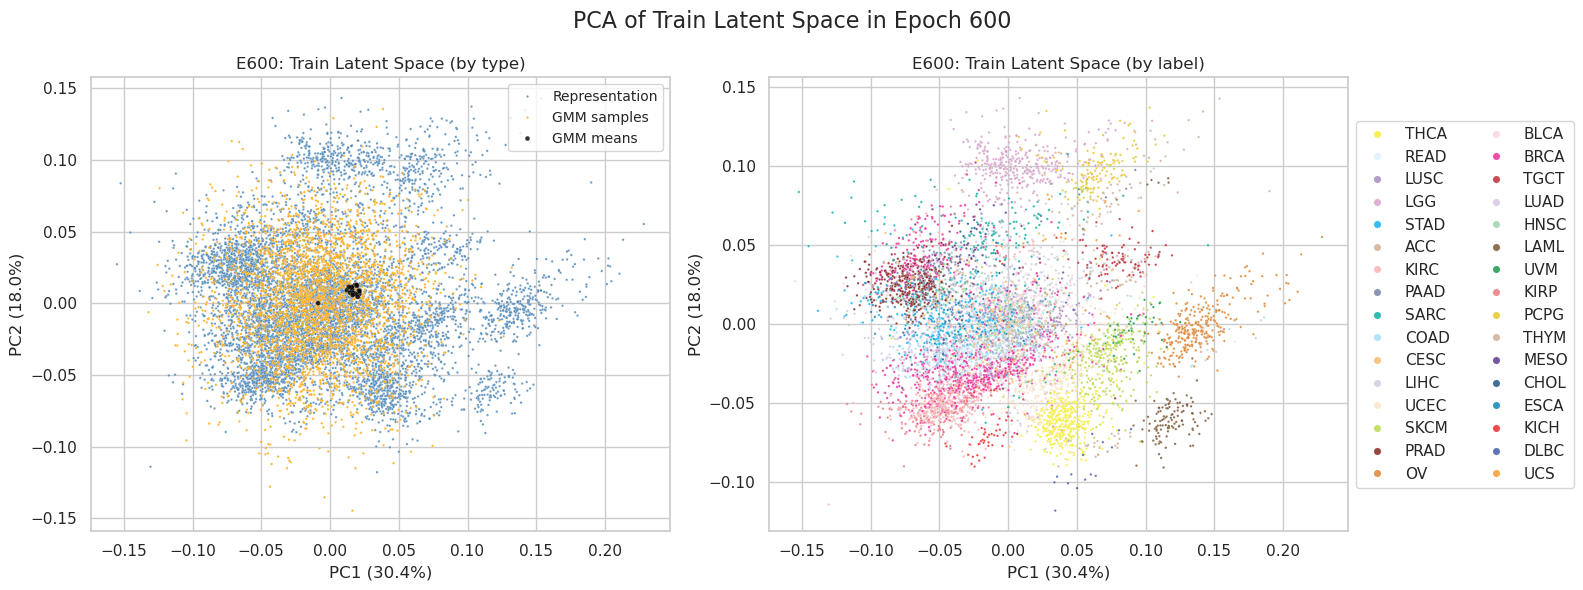

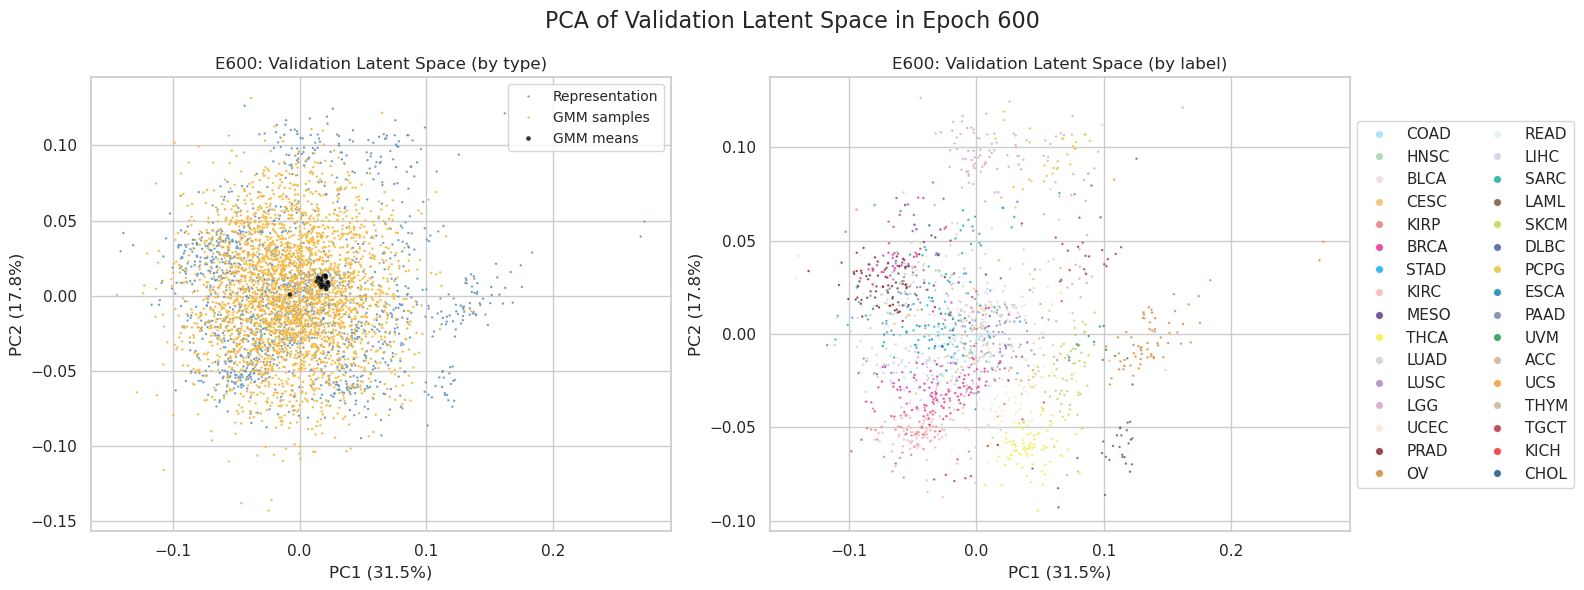

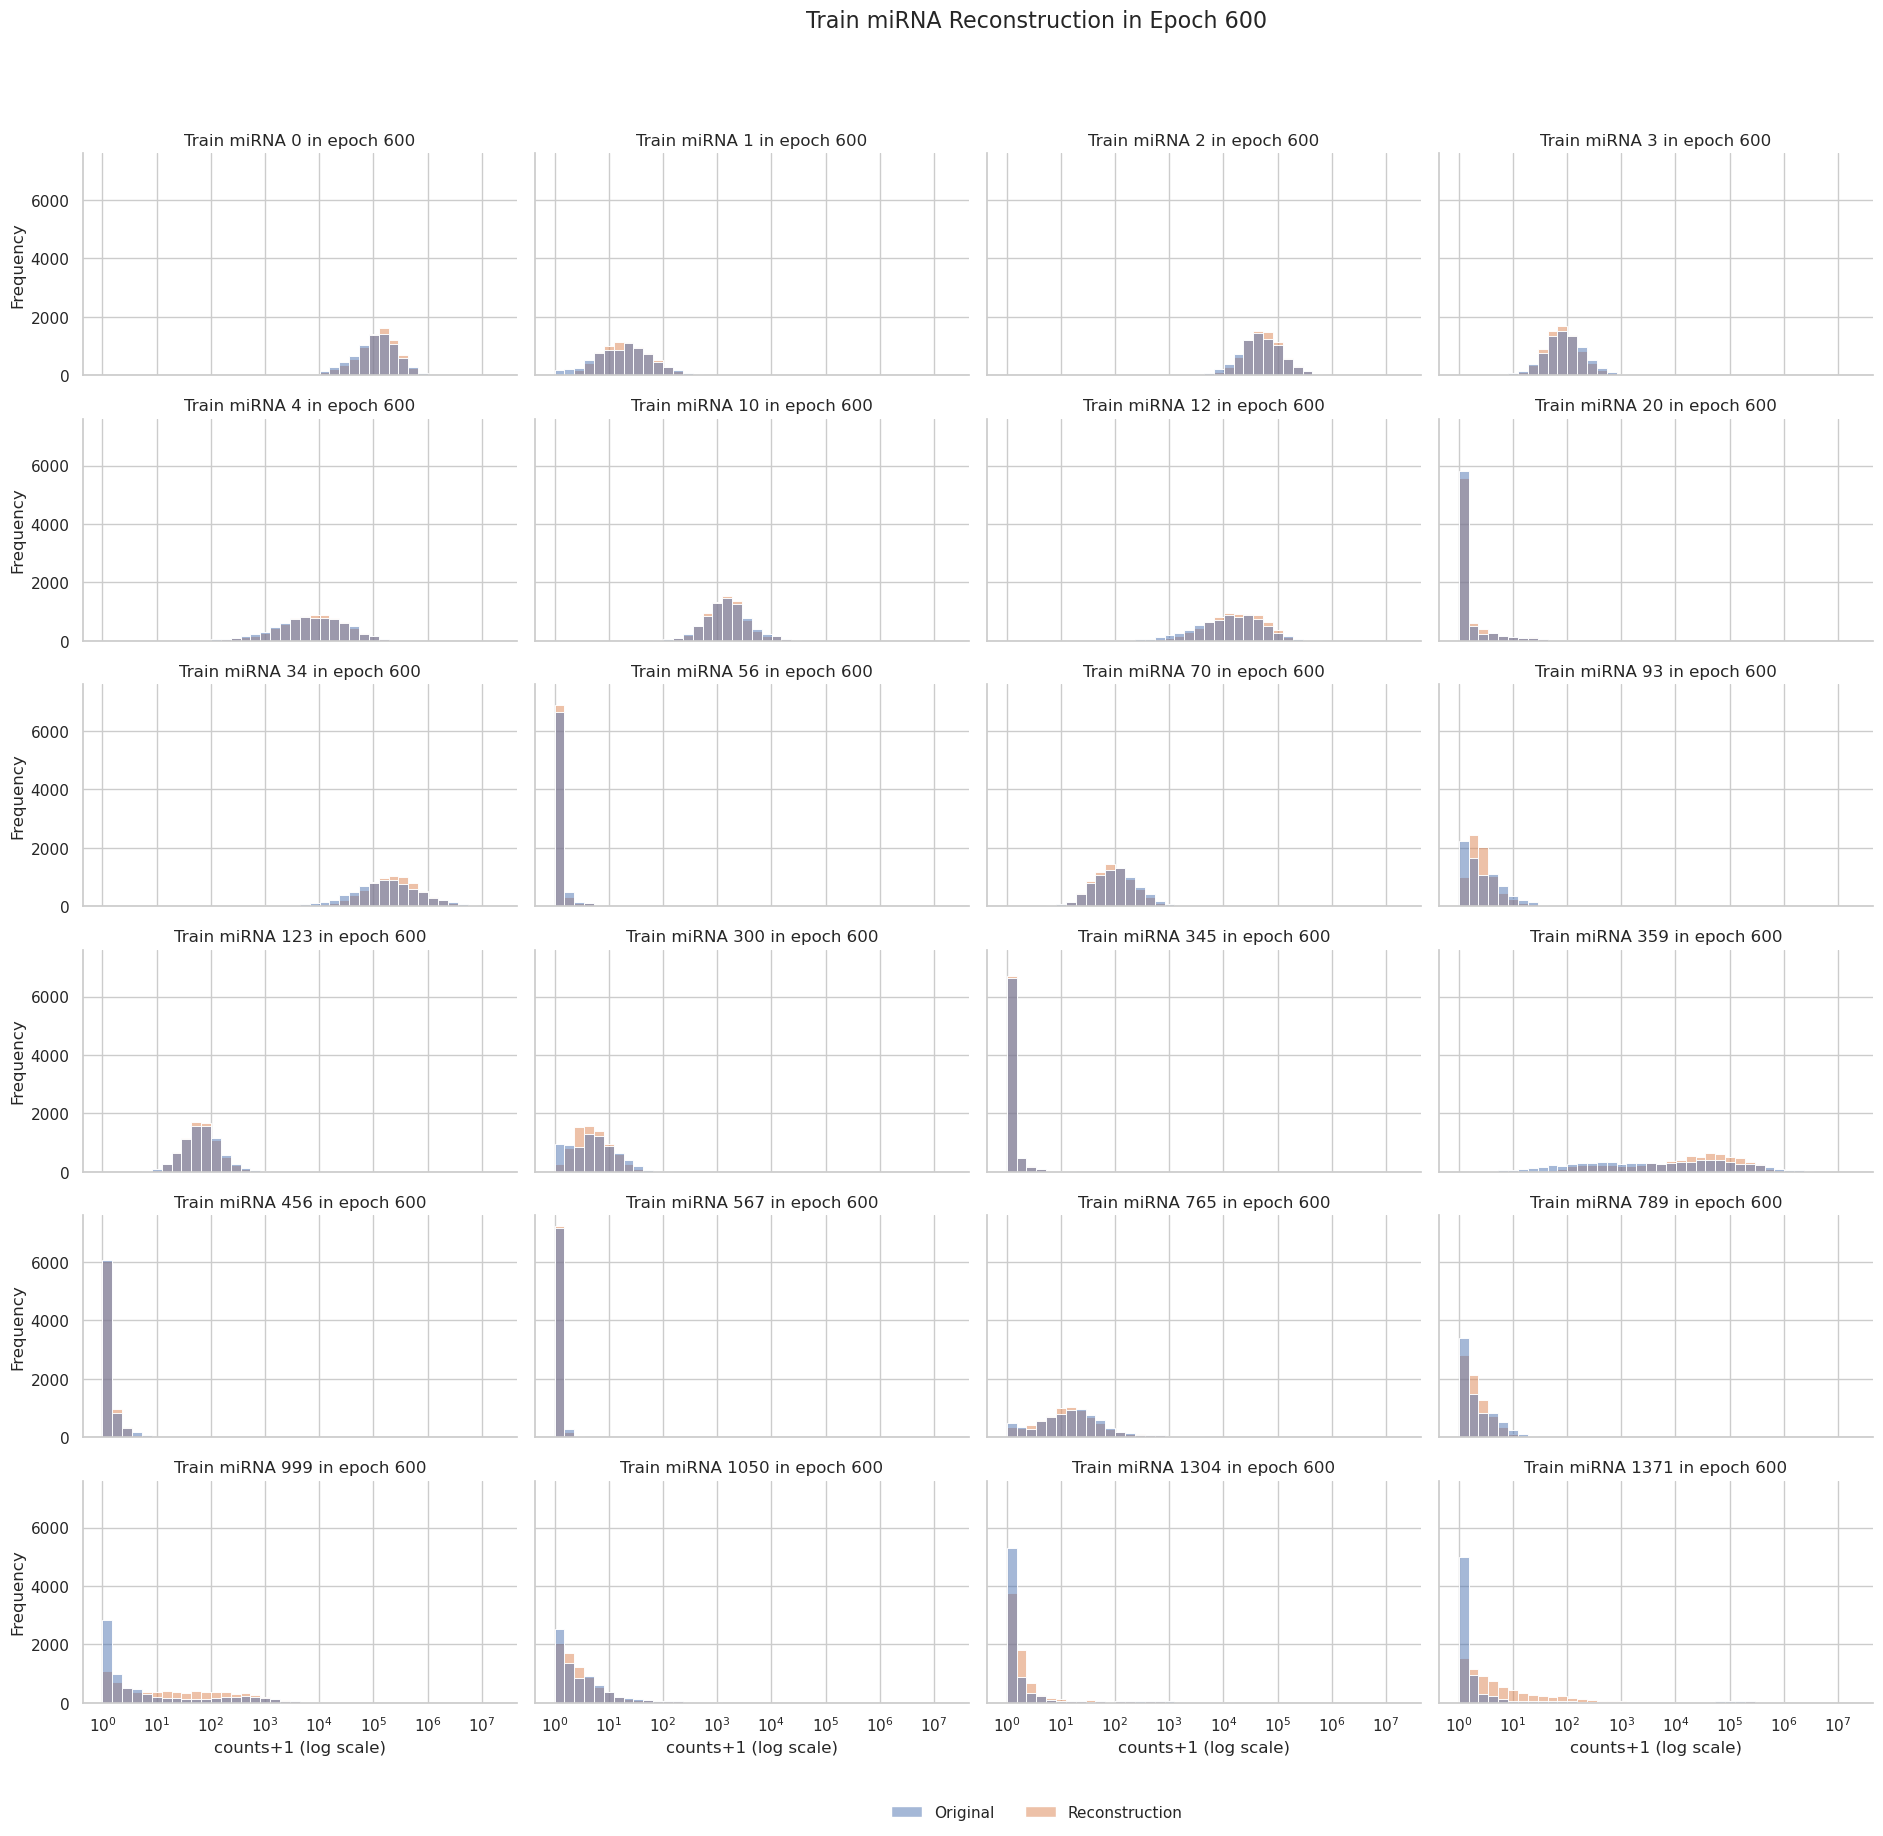

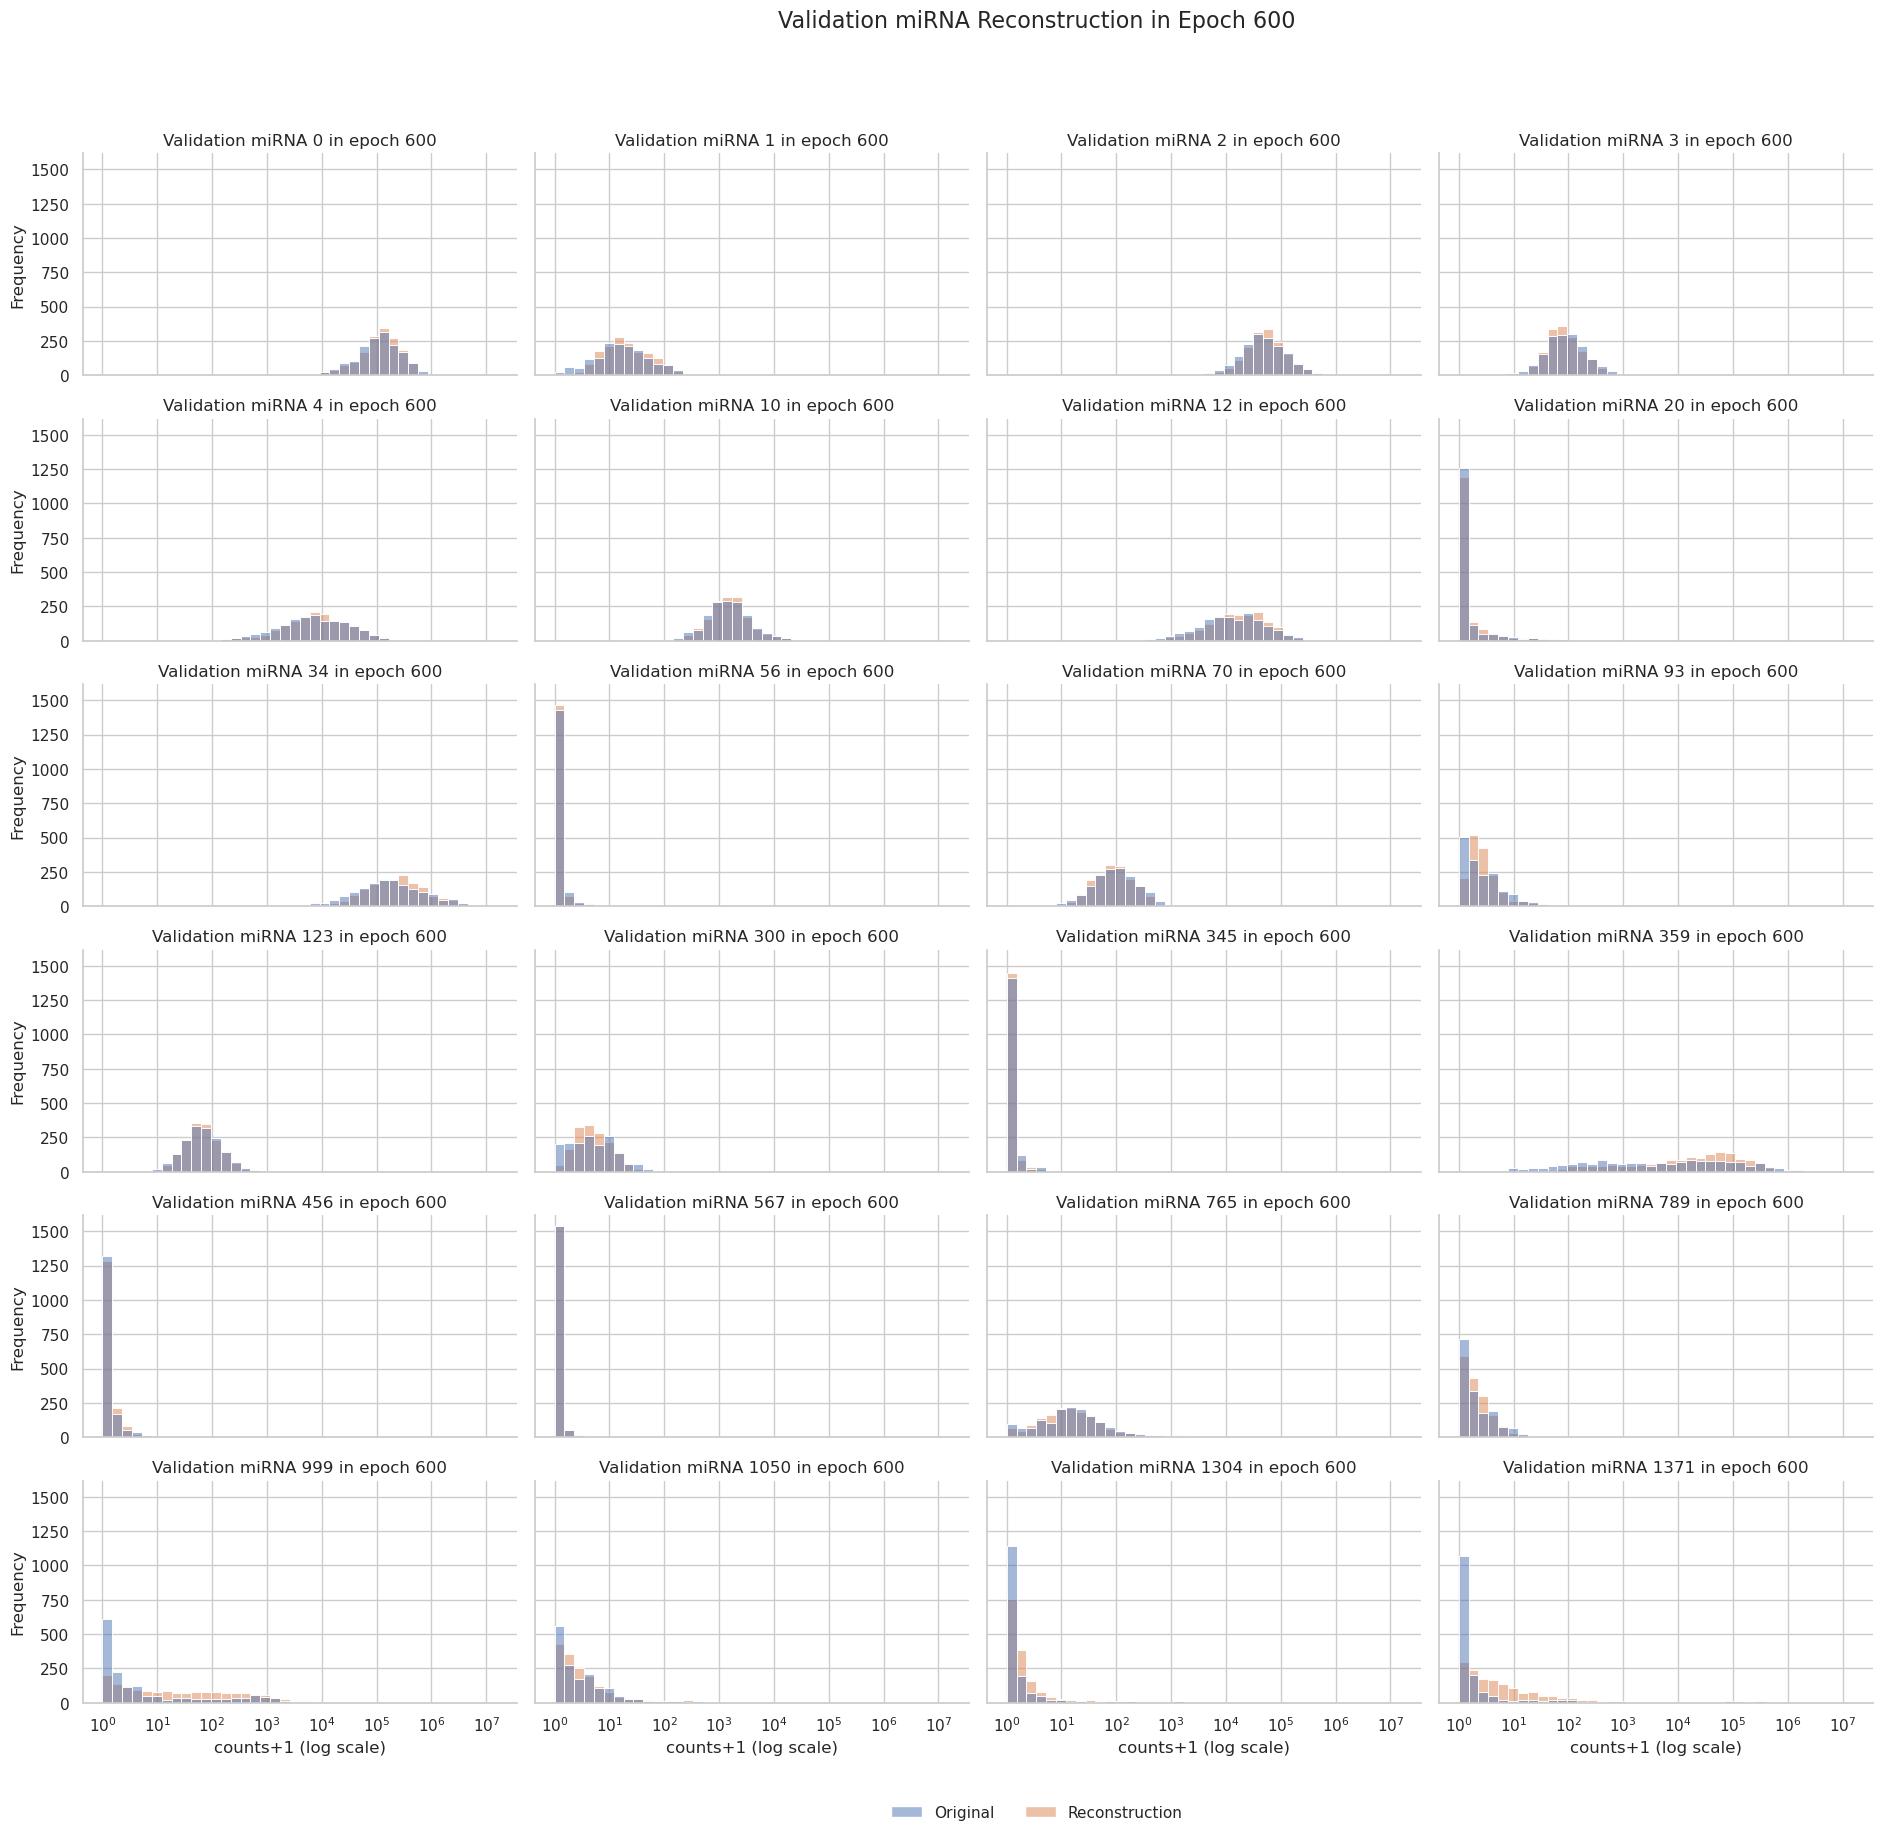

100%|███████████████████████████████████████████████████████████████████| 601/601 [23:46<00:00,  2.37s/it]


In [19]:
loss_tab = train_dgd_mirna(
        dgd, train_loader, validation_loader, device,
        learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
        nepochs=nepochs, pr=pr, plot=plot, is_plot=True, 
        reduction_type=reduction_type, scaling_type=scaling_type,
        sample_index=sample_index, subset=subset, wandb_log=False
    )

# Plotting

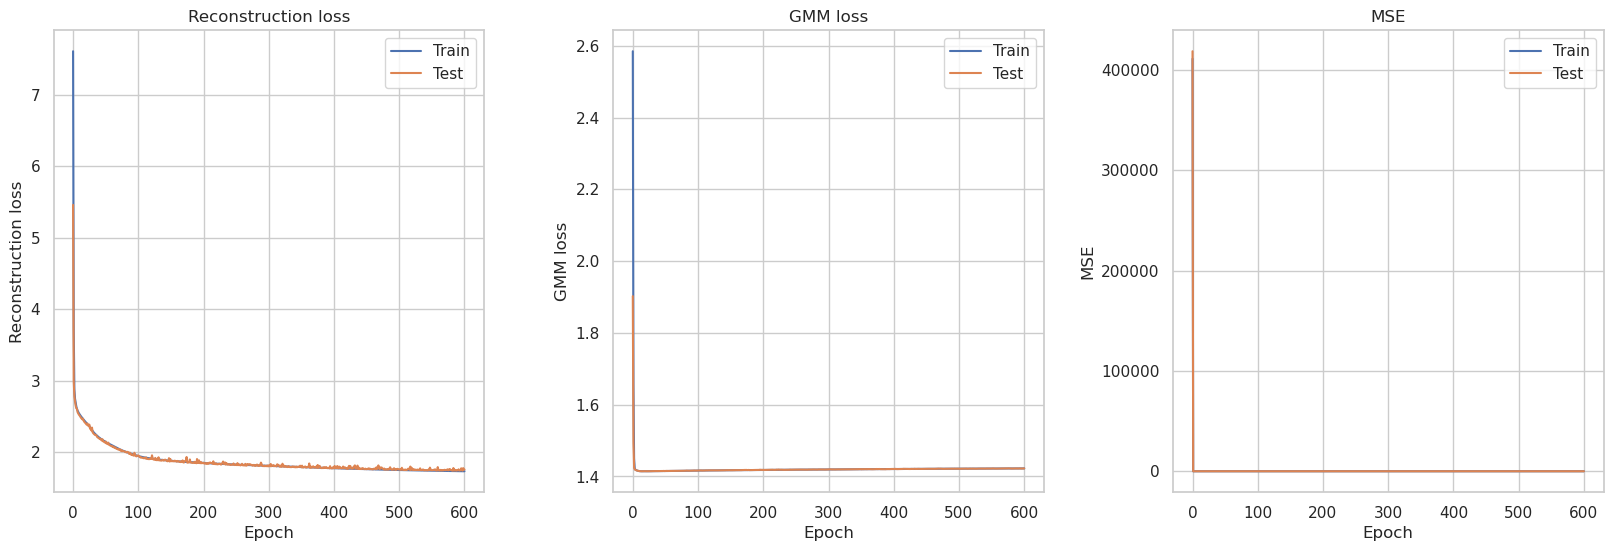

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

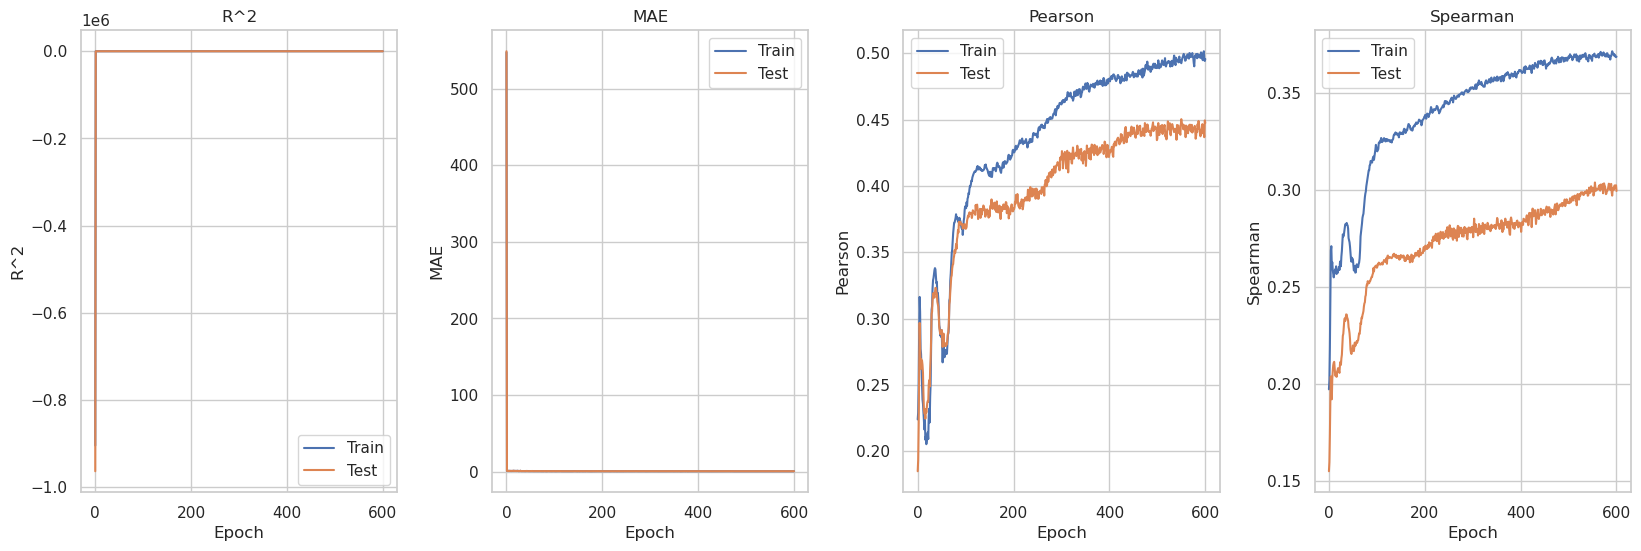

In [21]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Third subplot for RMSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for RMSE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Display the plots
plt.show()

# Save Model

In [22]:
save_model = False

# Set results paths
if save_model:
    loss_path = 'results/0511_loss_mirna.pickle'
    dgd_path = 'results/0511_dgd_mirna.pickle'
    
    torch.save(loss_tab, loss_path)
    torch.save(dgd, dgd_path)

# Simple Analysis

## Test Set

In [23]:
def prepare_potential_reps(sample_list):
    """
    takes a list of samples drawn from the DGD's distributions.
    The length gives the number of distributions which defines
    the dimensionality of the output tensor.
    If the list of samples is longer than 1, we will create representations
    from the combination of each GMM's samples.
    """
    return sample_list[0]

def learn_new_representation(dgd, 
                             data_loader,
                             test_epochs=50,
                             learning_rates=1e-2, 
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="sum",
                             resampling_type="mean"):
    """
    This function learns a new representation layer for the DGD.
    The new representation layer is learned by sampling new points
    from the GMMs and finding the best fitting GMM for each sample.
    The new representation layer is then optimized to minimize the
    reconstruction loss of the DGD.
    """
    
    gmm_loss = True
    n_samples_new = len(data_loader.dataset)
    potential_reps = prepare_potential_reps([dgd.gmm.sample_new_points(resampling_type)])

    dgd.eval()
    X_mirna = dgd.decoder(potential_reps.to(device))

    rep_init_values = torch.zeros((n_samples_new, potential_reps.shape[-1]))

    for (mirna_data, lib_mirna, i) in tqdm(data_loader.dataset):
        loss = torch.empty(0).to(device)
        for X in X_mirna:
            mirna_recon_loss = dgd.decoder.loss(
                nn_output=X.to(device), 
                target=mirna_data.to(device), 
                scale=lib_mirna, 
                mod_id="single",
                feature_ids=None, 
                reduction=reduction_type, 
                type="mirna"
            )
            loss = torch.cat((loss, mirna_recon_loss.unsqueeze(0)))
        best_fit_ids = torch.argmin(loss, dim=-1).detach().cpu()
        rep_init_values[i, :] = potential_reps.clone()[best_fit_ids, :]

    Ntest=len(data_loader.dataset)
    new_rep = RepresentationLayer(n_rep=dgd.rep_dim, 
                                  n_sample=Ntest,
                                  value_init=rep_init_values).to(device)
    test_rep_optimizer = torch.optim.AdamW(new_rep.parameters(), lr=learning_rates, weight_decay=weight_decay, betas=betas)

    for epoch in tqdm(range(test_epochs)):
        test_rep_optimizer.zero_grad()
        for (mirna_data, lib_mirna, index) in data_loader:
            mirna_recon_loss, gmm_loss = dgd.forward_and_loss(
                z=new_rep(index),
                target=mirna_data.to(device),
                scale=lib_mirna.unsqueeze(1).to(device), 
                gmm_loss=gmm_loss,
                reduction=reduction_type,
                type="mirna"
            )
            loss = mirna_recon_loss + gmm_loss
            loss.backward()
        test_rep_optimizer.step()
    
    return new_rep 

In [24]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.08it/s]


In [37]:
scaling = torch.sum(test_loader.dataset.data, dim=-1)

recon = dgd.forward(dgd.test_rep())
X = recon * scaling.unsqueeze(1).to(device)
data = test_loader.dataset.data
X = X.detach().cpu()
y = data.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [38]:
from scipy import stats

mirna_features = train_mirna.shape[1]-4
spearman_corr = []
pearson_corr = []
spearman_pval = []
pearson_pval = []

for i in range(y.shape[1]):
    # Calculate Spearman correlation coefficient
    spearman, spearman_p = stats.spearmanr(X[:,i], y[:,i])
    pearson, pearson_p = stats.pearsonr(X[:,i], y[:,i])
    spearman_corr.append(spearman)
    pearson_corr.append(pearson)
    spearman_pval.append(spearman_p)
    pearson_pval.append(spearman_p)
    
corr_data = pd.DataFrame(
    data={
        'spearman': spearman_corr, 
        'pearson': pearson_corr,
        'spearman_p': spearman_pval,
        'pearson_p': pearson_pval,
        'mirna': np.arange(0,mirna_features)
    },
    index=np.arange(0,mirna_features)
)
corr_data

spearman   pearson     spearman_p      pearson_p  mirna
0     0.859815  0.792785   0.000000e+00   0.000000e+00      0
1     0.672344  0.408289  2.927527e-211  2.927527e-211      1
2     0.759943  0.628458  1.172242e-301  1.172242e-301      2
3     0.801868  0.740542   0.000000e+00   0.000000e+00      3
4     0.836317  0.643551   0.000000e+00   0.000000e+00      4
...        ...       ...            ...            ...    ...
2019  0.051368  0.027534   3.980541e-02   3.980541e-02   2019
2020  0.057154  0.068156   2.215624e-02   2.215624e-02   2020
2021  0.067298  0.045115   7.048003e-03   7.048003e-03   2021
2022  0.116081  0.028363   3.188485e-06   3.188485e-06   2022
2023  0.115164  0.177417   3.815097e-06   3.815097e-06   2023

[2024 rows x 5 columns]

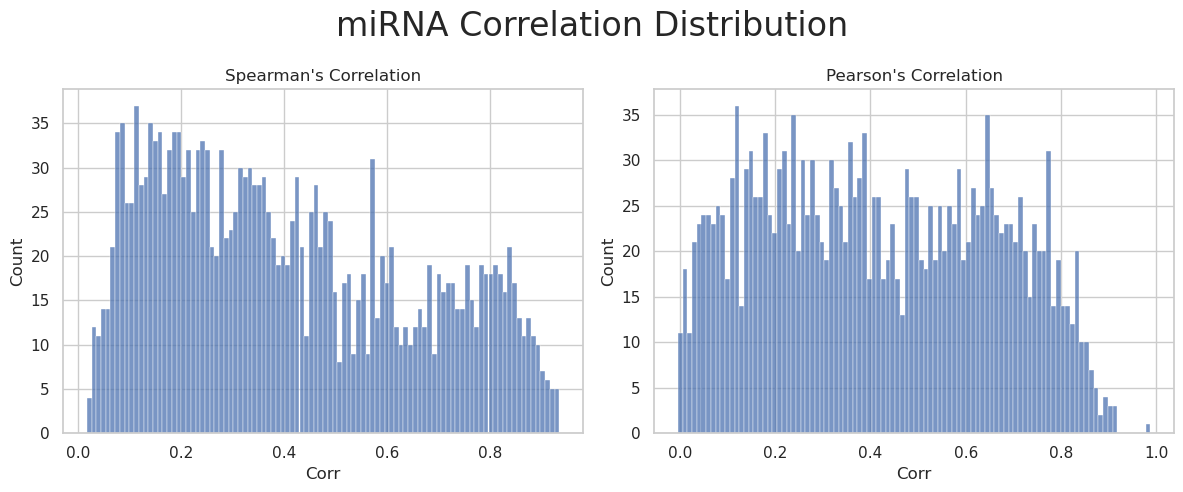

In [39]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
plt.title("Spearman's Correlation")
plt.xlabel("Corr")

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
plt.title("Pearson's Correlation")
plt.xlabel("Corr")

# Add the main title to the figure
fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
plt.tight_layout()
plt.show()

In [40]:
miR_122_5p = pd.DataFrame(
    data={
        'X': X[:,1371], 
        'y': y[:,1371],
        'cancer_type': cancer_type,
        'color': color
    }
)

In [41]:
miR_122_5p[miR_122_5p['cancer_type'] == 'LIHC']

X         y cancer_type    color
9     198730.031250  167451.0        LIHC  #CACDDD
44     33912.828125   70147.0        LIHC  #CACDDD
58    227783.515625  146422.0        LIHC  #CACDDD
72    208454.390625  177812.0        LIHC  #CACDDD
95    137903.968750  119181.0        LIHC  #CACDDD
...             ...       ...         ...      ...
1474  142038.703125   59562.0        LIHC  #CACDDD
1530   87269.726562  249838.0        LIHC  #CACDDD
1579   40291.578125   29609.0        LIHC  #CACDDD
1580   67622.460938   69957.0        LIHC  #CACDDD
1591    2876.052246   41753.0        LIHC  #CACDDD

[63 rows x 4 columns]

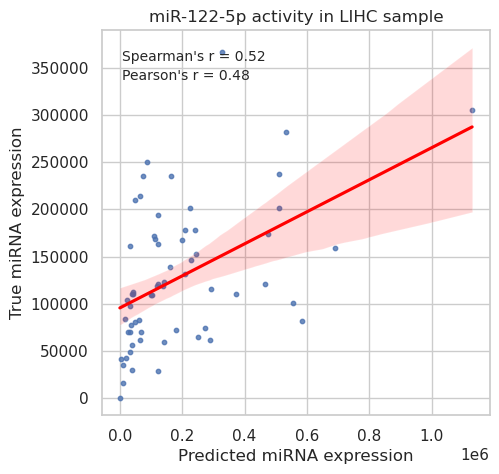

In [42]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lihc_data = miR_122_5p[miR_122_5p['cancer_type'] == 'LIHC']

# Create scatterplot
sns.regplot(data=lihc_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lihc_data['X'], lihc_data['y'])
pearson_corr, _ = stats.pearsonr(lihc_data['X'], lihc_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in LIHC sample")
plt.show()

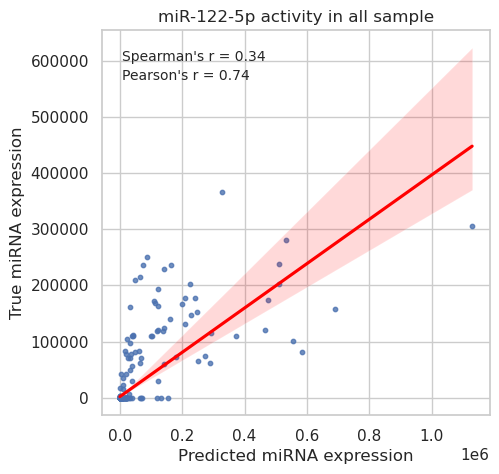

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lihc_data = miR_122_5p

# Create scatterplot
sns.regplot(data=lihc_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lihc_data['X'], lihc_data['y'])
pearson_corr, _ = stats.pearsonr(lihc_data['X'], lihc_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in all sample")
plt.show()

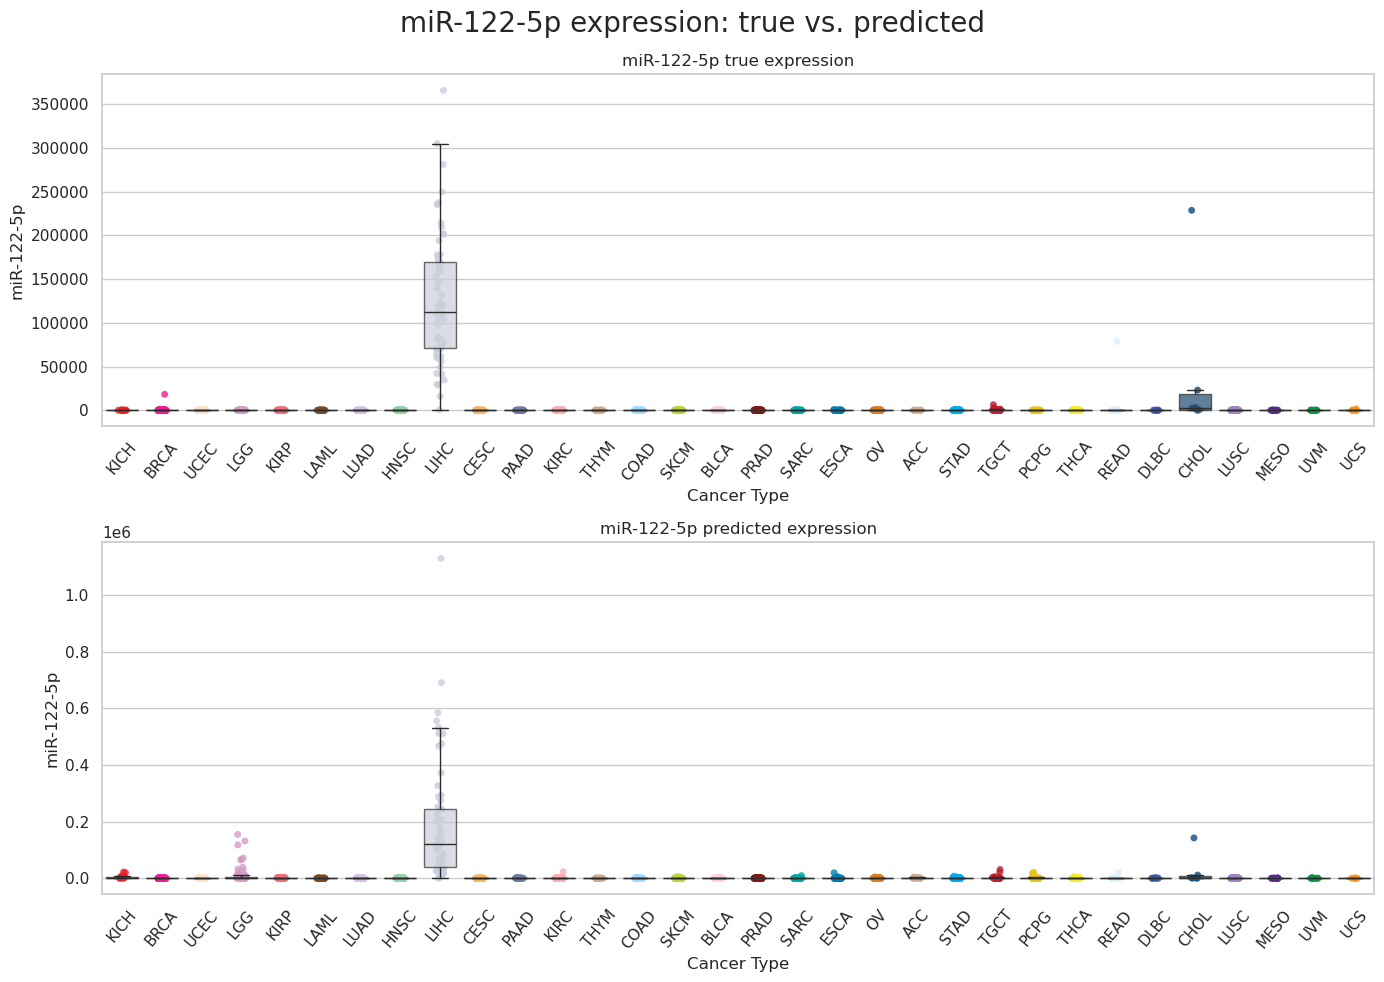

In [44]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_122_5p, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.subplot(2, 1, 2)
sns.boxplot(data=miR_122_5p, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.suptitle("miR-122-5p expression: true vs. predicted", fontsize=20)
plt.tight_layout()
plt.show()

In [45]:
miR_124_3p = pd.DataFrame(
    data={
        'X': X[:,1304], 
        'y': y[:,1304],
        'cancer_type': cancer_type,
        'color': color
    }
)

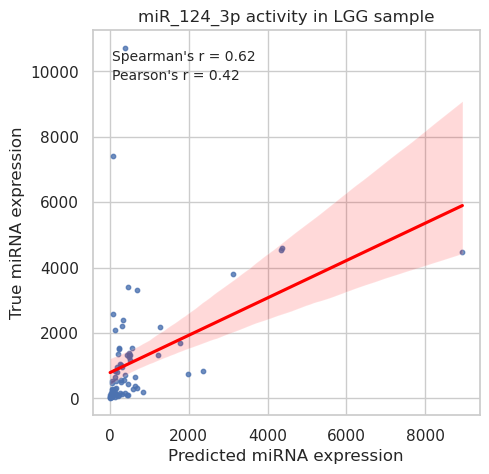

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lgg_data = miR_124_3p[miR_124_3p['cancer_type'] == 'LGG']

# Create scatterplot
sns.regplot(data=lgg_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lgg_data['X'], lgg_data['y'])
pearson_corr, _ = stats.pearsonr(lgg_data['X'], lgg_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR_124_3p activity in LGG sample")
plt.show()

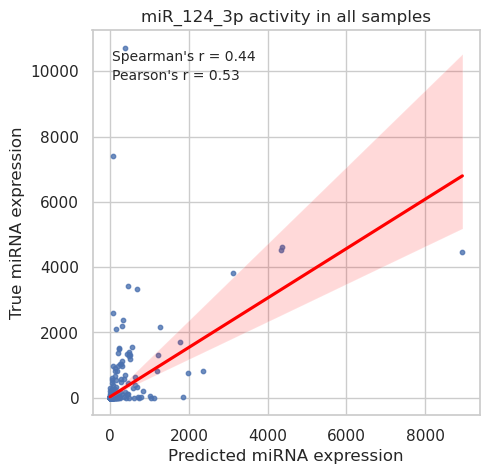

In [47]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 5))

# Filter data for LIHC tissue type
lgg_data = miR_124_3p

# Create scatterplot
sns.regplot(data=lgg_data, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})

# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(lgg_data['X'], lgg_data['y'])
pearson_corr, _ = stats.pearsonr(lgg_data['X'], lgg_data['y'])

# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR_124_3p activity in all samples")
plt.show()

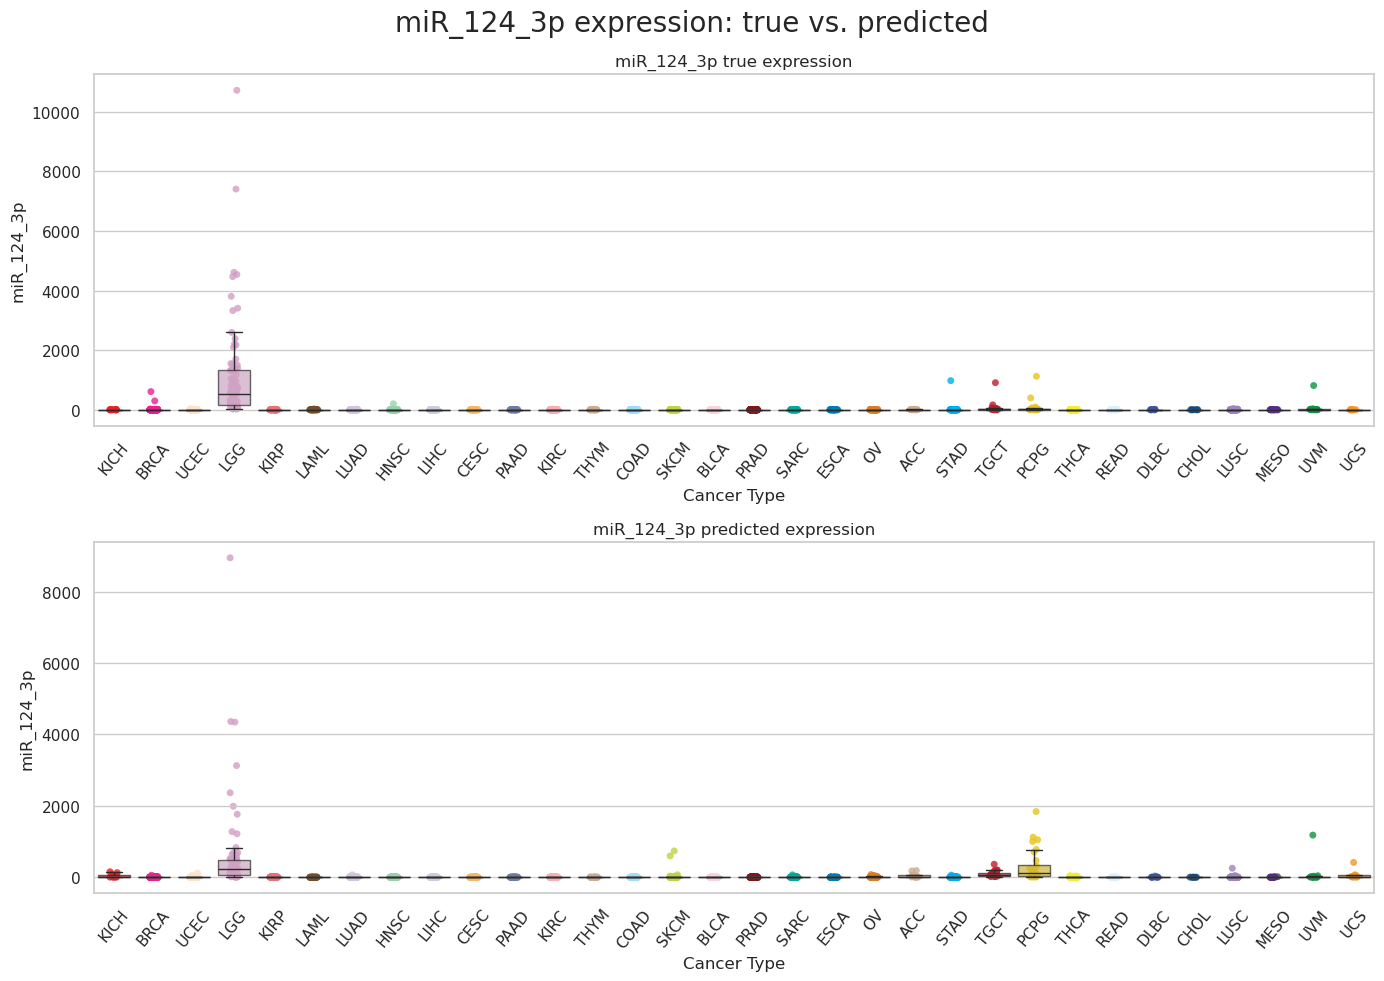

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_124_3p, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_124_3p, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)


plt.subplot(2, 1, 2)
sns.boxplot(data=miR_124_3p, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=0.7), showfliers=False)
sns.stripplot(data=miR_124_3p, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)

plt.suptitle("miR_124_3p expression: true vs. predicted", fontsize=20)
plt.tight_layout()

plt.show()